# Forest Cover Type
## Supervised Learning, Classification

## Table of Contents

- [Description](#description)
- [Getting Started](#Getting-Started)
    - [Explanation of the Data](#Explanation-of-the-Data)
- [Data Exploration](#Data-Exploration)
    - [Feature Statistics](#Feature-Statistics)
        - [Feature Description](#Feature-Description)
        - [Feature Skewness](#Feature-Skewness)
        - [Class Distribution](#Class-Distribution)
    - [Feature Visualization](#Feature-Visualization)
        - [Feature Spread](#Feature-Spread)
        - [Feature Distribution](#Feature-Distribution)
        - [Feature Comparison](#Feature-Comparison)
        - [Feature Correlation](#Feature-Correlation)       
- [Data Engineering](#Data-Engineering)
    - [Observation Cleaning](#Observation-Cleaning)
        - [Handling Missing Values](#Handling-Missing-Values)
        - [Handling Duplicates](#Handling-Duplicates)
    - [Dimensionality Reduction](#Dimensionality-Reduction)
        - [Random Forest Classifier](#Random-Forest-Classifier)
        - [Gradient Boosting Classifier](#Gradient-Boosting-Classifier)
    - [Train-Test Split](#Train-Test-Split)
    - [Feature Scaling](#Feature-Scaling)
- [Model Evaluations](#Model-Evaluations)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [Stochastic Gradient Descent Classifier](#Stochastic-Gradient-Descent-Classifier)
    - [Logistic Regression](#Logistic-Regression)
    - [Choosing the Best Model](#Choosing-the-Best-Model)
- [Testing the Model](#Testing-the-Model)


## Description

Our goal in this notebook is to classify the forest cover type based on the given data. The data comes from 4 Wilderness Areas in the Roosevelt National Forest, Northern Colorado, representing minimally disturbed forest ecosystems.

Each observation represents a 30m x 30m forest area, characterized by 54 attributes, including both binary and quantitative variables. The task is to predict the forest cover type based on these features.

Steps in the notebook:

- **Data Exploration**: Visualize and understand the data, handle missing values, and scale the features.
- **Dimensionality Reduction**: Use `Random Forest (RF)` and `AdaBoost Classifier (ADBC)` to determine the most important features.
- **Train-Test Split**: Split the data into 75% training and 25% testing, and use 10-fold cross-validation on the training set.
- **Model Training**: Train three models (`RF`, `SGDC`, and `Logistic Regression`) to evaluate performance.
- **Model Evaluation**: Use accuracy and F1 score metrics to select the best model for testing on the test set.

In [110]:
# Importing required libraries for the project
import sys
import numpy as np 
import pandas as pd 
import matplotlib 
import seaborn as sns 
import sklearn
import os
import boto3
from botocore.exceptions import NoCredentialsError
from dotenv import load_dotenv
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import alembic.config
import mlflow.store.db.utils

In [112]:
print('Python: {}'.format(sys.version))
print('numpy: {}'.format(np.__version__)) 
print('pandas: {}'.format(pd.__version__))  
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__)) 
print('sklearn: {}'.format(sklearn.__version__)) 

Python: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.10.0
seaborn: 0.13.2
sklearn: 1.6.0


In [113]:
import warnings
# will ignore any warnings
warnings.filterwarnings("ignore")

------
------

# EDA

First, we will import data and have a look about it.

In [114]:
# importing the dataset to a variable
data = pd.read_csv("../src/covtype_80.csv")

# displaying first 3 observations
data.head(3)

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2590      56      2                               212   
1       2785     155     18                               242   
2       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              -6                              390   
1                             118                             3090   
2                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            220             235            151   
1            238             238            122   
2            220             234            150   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6225  ...            0            0   
1                                6211  ...            0            0   
2                                6172  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   

   Soil_Type39  Soil_Type40  Cover_Type  
0            0            0           5  
1            0            0           2  
2            0            0           5  

[3 rows x 55 columns]

We can see that the data has been imported successfully but there are missing column names. We need to give column names in order to keep track of columns and make sense of features and data we have.

The column names are given here on [Kaggle](https://www.kaggle.com/uciml/forest-cover-type-dataset)

In [115]:
# since the data doesn't have column names, we will provide it in a form of list
feature_names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 
                'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7',
                'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 
                 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 
                 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 
                 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

# Feeding column names to the data
data.columns = feature_names

In [116]:
# displaying first 5 observation
data.head(5)

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2590      56      2                               212   
1       2785     155     18                               242   
2       2595      45      2                               153   
3       2579     132      6                               300   
4       2617      45      9                               240   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                              -6                              390   
1                             118                             3090   
2                              -1                              391   
3                             -15                               67   
4                              56                              666   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            220             235            151   
1            238             238            122   
2            220             234            150   
3            230             237            140   
4            223             221            133   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6225  ...            0            0   
1                                6211  ...            0            0   
2                                6172  ...            0            0   
3                                6031  ...            0            0   
4                                6244  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  Cover_Type  
0            0            0           5  
1            0            0           2  
2            0            0           5  
3            0            0           2  
4            0            0           5  

[5 rows x 55 columns]

Let's look at the datatypes of each feature and see if it needs any processing if the feature is not in its appropriate form..

In [117]:
# datatypes of features
data.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_Area1                      int64
Wilderness_Area2                      int64
Wilderness_Area3                      int64
Wilderness_Area4                      int64
Soil_Type1                            int64
Soil_Type2                            int64
Soil_Type3                            int64
Soil_Type4                            int64
Soil_Type5                            int64
Soil_Type6                            int64
Soil_Type7                            int64
Soil_Type8                            int64
Soil_Type9                      

Well since all are numeric integer and should be so, then we do not need to do any convertions here.

---------

### Explaination of the data

Our dataset has `54` features and `1` target variable `'Cover_Type'`. From `54` features, `10` are `numeric` and `44` are `catrgorical`. From `44` categorical, `40` are of `Soil_Type` and `4` of `Wilderness_Area`.

We have been provided the names of all `Soil_Type` and `Wilderness_Areas` for this dataset. The table below lists all the names with respect to their feature names in the column

| Feature Name | Names |
| ------------ | ----- |
| Wilderness_Area1 | Rawah Wilderness Area |
| Wilderness_Area2 | Neota Wilderness Area |
| Wilderness_Area3 | Comanche Wilderness Area |
| Wilderness_Area4 | Cache La Poudre Wilderness Area |
| Soil_Type1 | Cathedral family - Rock outcrop complex, extremely stony |
| Soil_Type2 | Vanet - Ratake families complex, very stony |
| Soil_Type3 | Haploborolis - Rock outcrop complex, rubbly |
| Soil_Type4 | Ratake family - Rock outcrop complex, rubbly |
| Soil_Type5 | Vanet family - Rock outcrop complex, rubbly |
| Soil_Type6 | Vanet - Wetmore families - Rock outcrop complex, stony |
| Soil_Type7 | Gothic family |
| Soil_Type8 | Supervisor - Limber families complex |
| Soil_Type9 | Troutville family, very stony |
| Soil_Type10 | Bullwark - Catamount families - Rock outcrop complex, rubbly |
| Soil_Type11 | Bullwark - Catamount families - Rock land complex, rubbly |
| Soil_Type12 | Legault family - Rock land complex, stony |
| Soil_Type13 | Catamount family - Rock land - Bullwark family complex, rubbly |
| Soil_Type14 | Pachic Argiborolis - Aquolis complex |
| Soil_Type15 | _unspecified in the USFS Soil and ELU Survey_ |
| Soil_Type16 | Cryaquolis - Cryoborolis complex |
| Soil_Type17 | Gateview family - Cryaquolis complex |
| Soil_Type18 | Rogert family, very stony |
| Soil_Type19 | Typic Cryaquolis - Borohemists complex |
| Soil_Type20 | Typic Cryaquepts - Typic Cryaquolls complex |
| Soil_Type21 | Typic Cryaquolls - Leighcan family, till substratum complex |
| Soil_Type22 | Leighcan family, till substratum, extremely bouldery |
| Soil_Type23 | Leighcan family, till substratum, - Typic Cryaquolls complex. |
| Soil_Type24 | Leighcan family, extremely stony |
| Soil_Type25 | Leighcan family, warm, extremely stony |
| Soil_Type26 | Granile - Catamount families complex, very stony |
| Soil_Type27 | Leighcan family, warm - Rock outcrop complex, extremely stony |
| Soil_Type28 | Leighcan family - Rock outcrop complex, extremely stony |
| Soil_Type29 | Como - Legault families complex, extremely stony |
| Soil_Type30 | Como family - Rock land - Legault family complex, extremely stony |
| Soil_Type31 | Leighcan - Catamount families complex, extremely stony |
| Soil_Type32 | Catamount family - Rock outcrop - Leighcan family complex, extremely stony |
| Soil_Type33 | Leighcan - Catamount families - Rock outcrop complex, extremely stony |
| Soil_Type34 | Cryorthents - Rock land complex, extremely stony |
| Soil_Type35 | Cryumbrepts - Rock outcrop - Cryaquepts complex |
| Soil_Type36 | Bross family - Rock land - Cryumbrepts complex, extremely stony |
| Soil_Type37 | Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony |
| Soil_Type38 | Leighcan - Moran families - Cryaquolls complex, extremely stony |
| Soil_Type39 | Moran family - Cryorthents - Leighcan family complex, extremely stony |
| Soil_Type40 | Moran family - Cryorthents - Rock land complex, extremely stony |


Just to clarify, the categorical variable we have here is 2. And these alone have 44 features. But an observation can only have presence of any 2 feature from 44, 1 for Soil and 1 for Wilderness. So if an observation has `'1'` in `Wilderness_Area4` and `'1'` in `Soil_Type12`, it means that it's respective Soil and Wilderness is present, while all other 42 features will have `'0'` hence its absence. And this is what a categorical feature means. And also these are `one-hot encoded` for us, so thanks to the authors!

Talking about numeric features, `Aspect` and `Slope` have measurement in `degrees` while 3 `Hillshade..` features have values range from `0 to 255` index, describing summer solstice. Remaining 5 out of 10 numeric features have measurement in `Meters`. 

The target variable `Cover_Type` ranges bewtween integer value `1 - 7` and each number is a key reprsenting names of different forest type. Let's look at what number represents which forest cover types.

| Key | Name |
| --- | ---- |
| 1 | Spruce / Fir |
| 2 | Lodgepole Pine |
| 3 | Ponderosa Pine |
| 4 | Cottonwood / Willow |
| 5 | Aspen |
| 6 | Douglas-fir |
| 7 | Krummholz |

## Data Exploration

### Feature Statistics

#### Feature Describe

We will split the data in 2 parts. First part will contain all `numerical features` and second part will contain all `binary or categorical features` of the data. The target variable `Cover_Type` is excluded.

**We will look at the statistics of numerical features and extract useful info out of it.**

In [118]:
# Extracting all numerical features from data
num_fea = data.iloc[:, :10]

# extracting all binary features from data
binary_fea = data.iloc[:, 10:-1]


# statistics of numerical features
num_fea.describe()

Elevation         Aspect          Slope  \
count  464810.000000  464810.000000  464810.000000   
mean     2959.065285     155.614324      14.097795   
std       280.115252     111.903981       7.486634   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2995.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     464810.000000                   464810.000000   
mean                         269.318457                       46.370859   
std                          212.464202                       58.272836   
min                            0.000000                     -166.000000   
25%                          108.000000                        7.000000   
50%                          218.000000                       29.000000   
75%                          384.000000                       69.000000   
max                         1397.000000                      601.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                    464810.000000  464810.000000   464810.000000   
mean                       2350.328504     212.154932      223.316682   
std                        1559.598066      26.757534       19.768421   
min                           0.000000       0.000000        0.000000   
25%                        1104.000000     198.000000      213.000000   
50%                        1996.000000     218.000000      226.000000   
75%                        3331.000000     231.000000      237.000000   
max                        7117.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  
count  464810.000000                       464810.000000  
mean      142.521594                         1980.729055  
std        38.241287                         1325.420703  
min         0.000000                            0.000000  
25%       119.000000                         1024.000000  
50%       143.000000                         1710.000000  
75%       168.000000                         2549.000000  
max       254.000000                         7173.000000

- The mean of the features ranges from 14 to 2959, indicating significant variability. The standard deviation helps us understand this spread, with 'Horizontal_Distance_To_Roadways' being the most spread out, followed by `Horizontal_Distance_To_Fire_Points` and `Elevation`. `Slope` and `Hillshade` features are the most concentrated around the mean.

- All features except `Elevation` and 'Vertical_Distance_To_Hydrology' have a minimum value of '0'. `Elevation` has the highest minimum, while `Vertical_Distance_To_Hydrology` can be negative.

- We will later document and visualize the data distribution across different percentiles (min-25%, 25%-50%, 50%-75%, 75%-max) to understand how spread or dense each feature is.

- `Hillshade` features have a maximum value of `254`, while `Horizontal_Distance_To_Fire_Points` and `Horizontal_Distance_To_Roadways` have the highest ranges. `Slope` has the lowest maximum and range, followed by 'Aspect'.

- The variability in feature ranges is due to differences in measurement units: some features (e.g., `Elevation`, `Horizontal_Distance_To_Roadways`) are in meters, while others (e.g., `Aspect`, `Slope`) are in degrees or constrained values (e.g., `Hillshade` maxing at 255).


**Taking statistical look at binary or categorical features.**

In [119]:
# statistics of binary or categorical features
binary_fea.describe()

Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4  \
count     464810.000000     464810.000000     464810.000000     464810.000000   
mean           0.449319          0.051412          0.435490          0.063779   
std            0.497425          0.220838          0.495821          0.244359   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            1.000000          0.000000          1.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

          Soil_Type1     Soil_Type2     Soil_Type3     Soil_Type4  \
count  464810.000000  464810.000000  464810.000000  464810.000000   
mean        0.005206       0.012949       0.008339       0.021318   
std         0.071968       0.113056       0.090936       0.144444   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Soil_Type5     Soil_Type6  ...    Soil_Type31    Soil_Type32  \
count  464810.000000  464810.000000  ...  464810.000000  464810.000000   
mean        0.002760       0.011319  ...       0.044115       0.090381   
std         0.052466       0.105785  ...       0.205350       0.286727   
min         0.000000       0.000000  ...       0.000000       0.000000   
25%         0.000000       0.000000  ...       0.000000       0.000000   
50%         0.000000       0.000000  ...       0.000000       0.000000   
75%         0.000000       0.000000  ...       0.000000       0.000000   
max         1.000000       1.000000  ...       1.000000       1.000000   

         Soil_Type33    Soil_Type34    Soil_Type35    Soil_Type36  \
count  464810.000000  464810.000000  464810.000000  464810.000000   
mean        0.077713       0.002747       0.003287       0.000213   
std         0.267720       0.052343       0.057241       0.014593   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type37    Soil_Type38    Soil_Type39    Soil_Type40  
count  464810.000000  464810.000000  464810.000000  464810.000000  
mean        0.000516       0.026774       0.023866       0.014946  
std         0.022717       0.161424       0.152631       0.121336  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       0.000000  
75%         0.000000       0.000000       0.000000       0.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 44 columns]

- The mean of the binary features can provide useful insights. `Wilderness_Area1` has the highest mean, followed by `Wilderness_Area3`, indicating that these areas are most represented in the data. `Wilderness_Area2` has the least presence.

- The sum of the means of all `Wilderness_Area` features is approximately `1`, which makes sense as each observation belongs to one area. Cross-checks confirmed that no observation belongs to multiple areas simultaneously.

- From a probability perspective, an observation has a `44.8%` chance of being from `Wilderness_Area1`, `43.6%` from `Wilderness_Area3`, and lower probabilities for others.

- Similar documentation applies for `Soil_Type` features.

- Given the different spreads of features, we will apply feature scaling to bring all values into a similar range (0 to 1). This is necessary as some algorithms are sensitive to varying scales, which could lead to inaccurate results. This scaling will be performed in the `Data Engineering` section.

#### Feature Skew

**Exploring Skewness of each features:**

In [120]:
# skew distribution
data.skew()

Elevation                              -0.817871
Aspect                                  0.403128
Slope                                   0.787914
Horizontal_Distance_To_Hydrology        1.140784
Vertical_Distance_To_Hydrology          1.783146
Horizontal_Distance_To_Roadways         0.712520
Hillshade_9am                          -1.182493
Hillshade_Noon                         -1.059315
Hillshade_3pm                          -0.275229
Horizontal_Distance_To_Fire_Points      1.289766
Wilderness_Area1                        0.203774
Wilderness_Area2                        4.062618
Wilderness_Area3                        0.260217
Wilderness_Area4                        3.570351
Soil_Type1                             13.750516
Soil_Type2                              8.616112
Soil_Type3                             10.813380
Soil_Type4                              6.627966
Soil_Type5                             18.954915
Soil_Type6                              9.239162
Soil_Type7          

- `Soil_Type15` has the highest positive skewness, meaning most values are concentrated to the left with a long tail to the right (right-skewed). This indicates that most observations have a value of `0` for this feature.

- Looking at the skew scores of `Soil` features, we may reduce dimensions by removing certain `Soil Types` if they don't provide additional useful information for the model.

- `Elevation` and `Hillshade` have negatively skewed distributions, where the mode is on the right, followed by the median and mean.

- Machine learning algorithms can be sensitive to such data ranges, potentially leading to weaker results. Feature scaling, as discussed earlier, will address this issue.

#### Class Distribution:

Let's take a look how each class is distributed..

In [121]:
# grouping by forest cover type and calculating total occurance
data.groupby('Cover_Type').size()

Cover_Type
1    169283
2    226801
3     28633
4      2221
5      7498
6     13878
7     16496
dtype: int64

- We have uneven samples of forest cover type, where `Lodgepole Pine (2)` has the highest no. of observation followed by `Spruce (1)`. Only these 2 cover types add up to `495,141` number of observations out of `581,011` total which covers approx `85.2%` of data.

- But we do have enough samples to train the model learning different patterns of each forest cover types. We will see how models performs with these uneven amount of distributions in [Model Evaluation](#Model_Evaluation) section.

--------

### Feature Visualization

#### Feature Spread

Visualizing the spread and outliers of the data of numerical features.

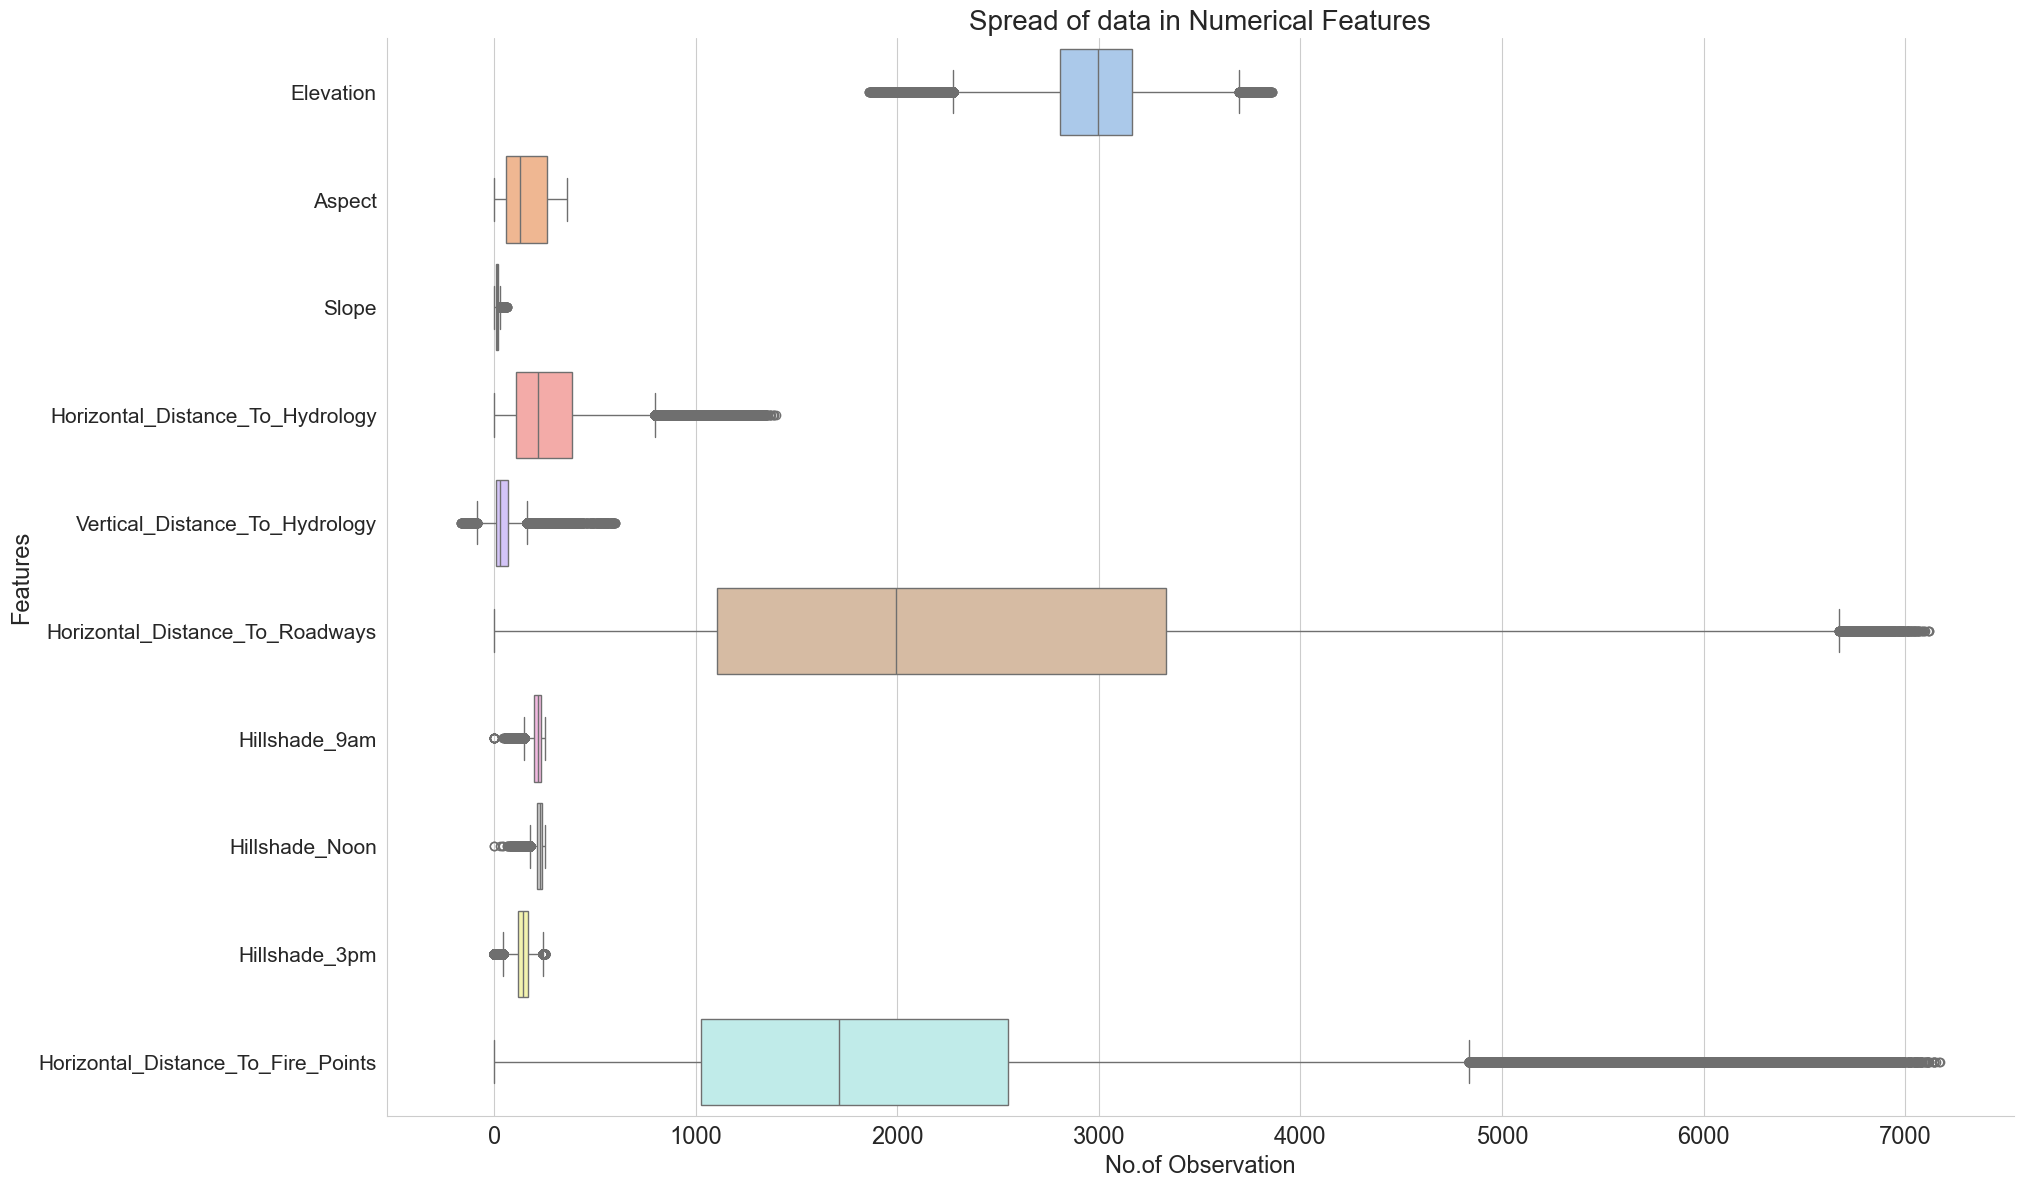

In [13]:
#####    1    ######
# Box and whiskers plot
# Spread of numerical features

# importing pyplot module from matplotlib to plt
plt = matplotlib.pyplot

# plot bg
sns.set_style("whitegrid")

#Size of the plot
plt.subplots(figsize=(21, 14))

# setting color of the plot
color = sns.color_palette('pastel')

# Using seaborn to plot it horizontally with 'color'
sns.boxplot(data = num_fea, orient='h', palette=color)

# Uncomment below code to visualize where every single data observation of the features lie in the plot 
#sns.swarmplot(data = num_fea)  #WARNING THIS WILL TAKE LOTS OF TIME DEPENDING ON CPU POWER AND RAM YOU HAVE  !!

# Title of the graph
plt.title('Spread of data in Numerical Features', size = 20)

# Horizontal axis Label
plt.xlabel('No.of Observation', size = 17)
# Vertical axis Label
plt.ylabel('Features', size = 17)

# x-axis label size
plt.xticks(size = 17)
#y-axis label size
plt.yticks(size = 15)

# removing the top and right axes spines, which are not needed
sns.despine()

# display plot
plt.show()

- As explained earlier in [feature statistics](#Feature-Statistics), `Slope` is the most densely packed feature, with a small range compared to others. Its mean and median are close, differing by approximately 1, though it has a few outliers.

- `Aspect` is the only feature without outliers, with a range of 360. Both `Aspect` and `Slope` are measured in degrees, but `Aspect` takes on a larger range, making it less dense compared to `Slope`. The first 50% of the data (from min to median) is denser than the last 50%, which is more spread out.

- `Hillshade` features show similar behavior to `Slope`, with many outliers and a smaller range. `Vertical_Distance_To_Hydrology` has a similar plot, but its minimum value is negative.

- `Elevation` and `Horizontal_Distance_To_Hydrology` are the only features with a non-zero minimum value. `Elevation` has many outliers and is centered in the data range.

- `Horizontal_Distance_To_Roadways` is the most spread-out feature due to its high standard deviation, followed by `Horizontal_Distance_To_Fire_Points`, which has the highest value. The last 50% of `Horizontal_Distance_To_Roadways` is more spread out and less dense compared to `Horizontal_Distance_To_Fire_Points`, resulting in a higher standard deviation.

#### Feature Distribution

Lets plot how `Wilderness_Area`s are distributed.

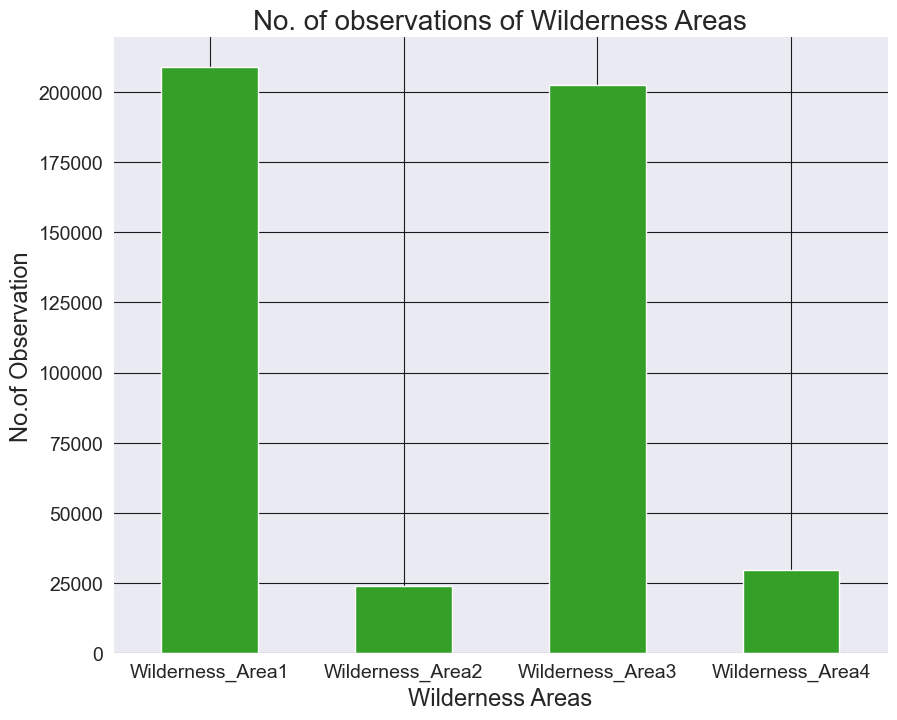

In [15]:
####    2    #####
# Bar plot
# Wilderness Area Count

# Splitting binary_fea data in 2
# Wild_data will have wilderness data
# Soil_Data will have Soil data

# Splitting
Wild_data, Soil_data = binary_fea.iloc[:,:4], binary_fea.iloc[:,4:]

# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})

# list of colors
flatui = ["#e74c3c", "#34495e", "#2ecc71","#3498db"]
# using seaborn, passing color to palette
color = sns.color_palette(flatui)

# Sum the data, plot bar with given size using color defined
Wild_data.sum().plot(kind='bar', figsize=(10, 8), color='#34a028')

# Title of the graph
plt.title('No. of observations of Wilderness Areas', size = 20)

# Horizontal axis Label
plt.xlabel('Wilderness Areas', size = 17)
# Vertical axis Label
plt.ylabel('No.of Observation', size = 17)

# x-axis label size, setting label rotations
plt.xticks(rotation = 'horizontal', size = 14)
# y-axis label size
plt.yticks(size = 14)

# removing the top and right axes spines, which are not needed
sns.despine()

# display plot
plt.show()

`Wilderness_Area1` has the most presence followed by `Wilderness_Area3`, both have quite close observations and so were their mean value. `Wilderness_Area2` having the least observation. Lets see their exact values for precision.

In [16]:
# total count of each Wilderness Area
Wild_data.sum()

Wilderness_Area1    208848
Wilderness_Area2     23897
Wilderness_Area3    202420
Wilderness_Area4     29645
dtype: int64

**Now Let's see similar visualization for `Soil Types`**

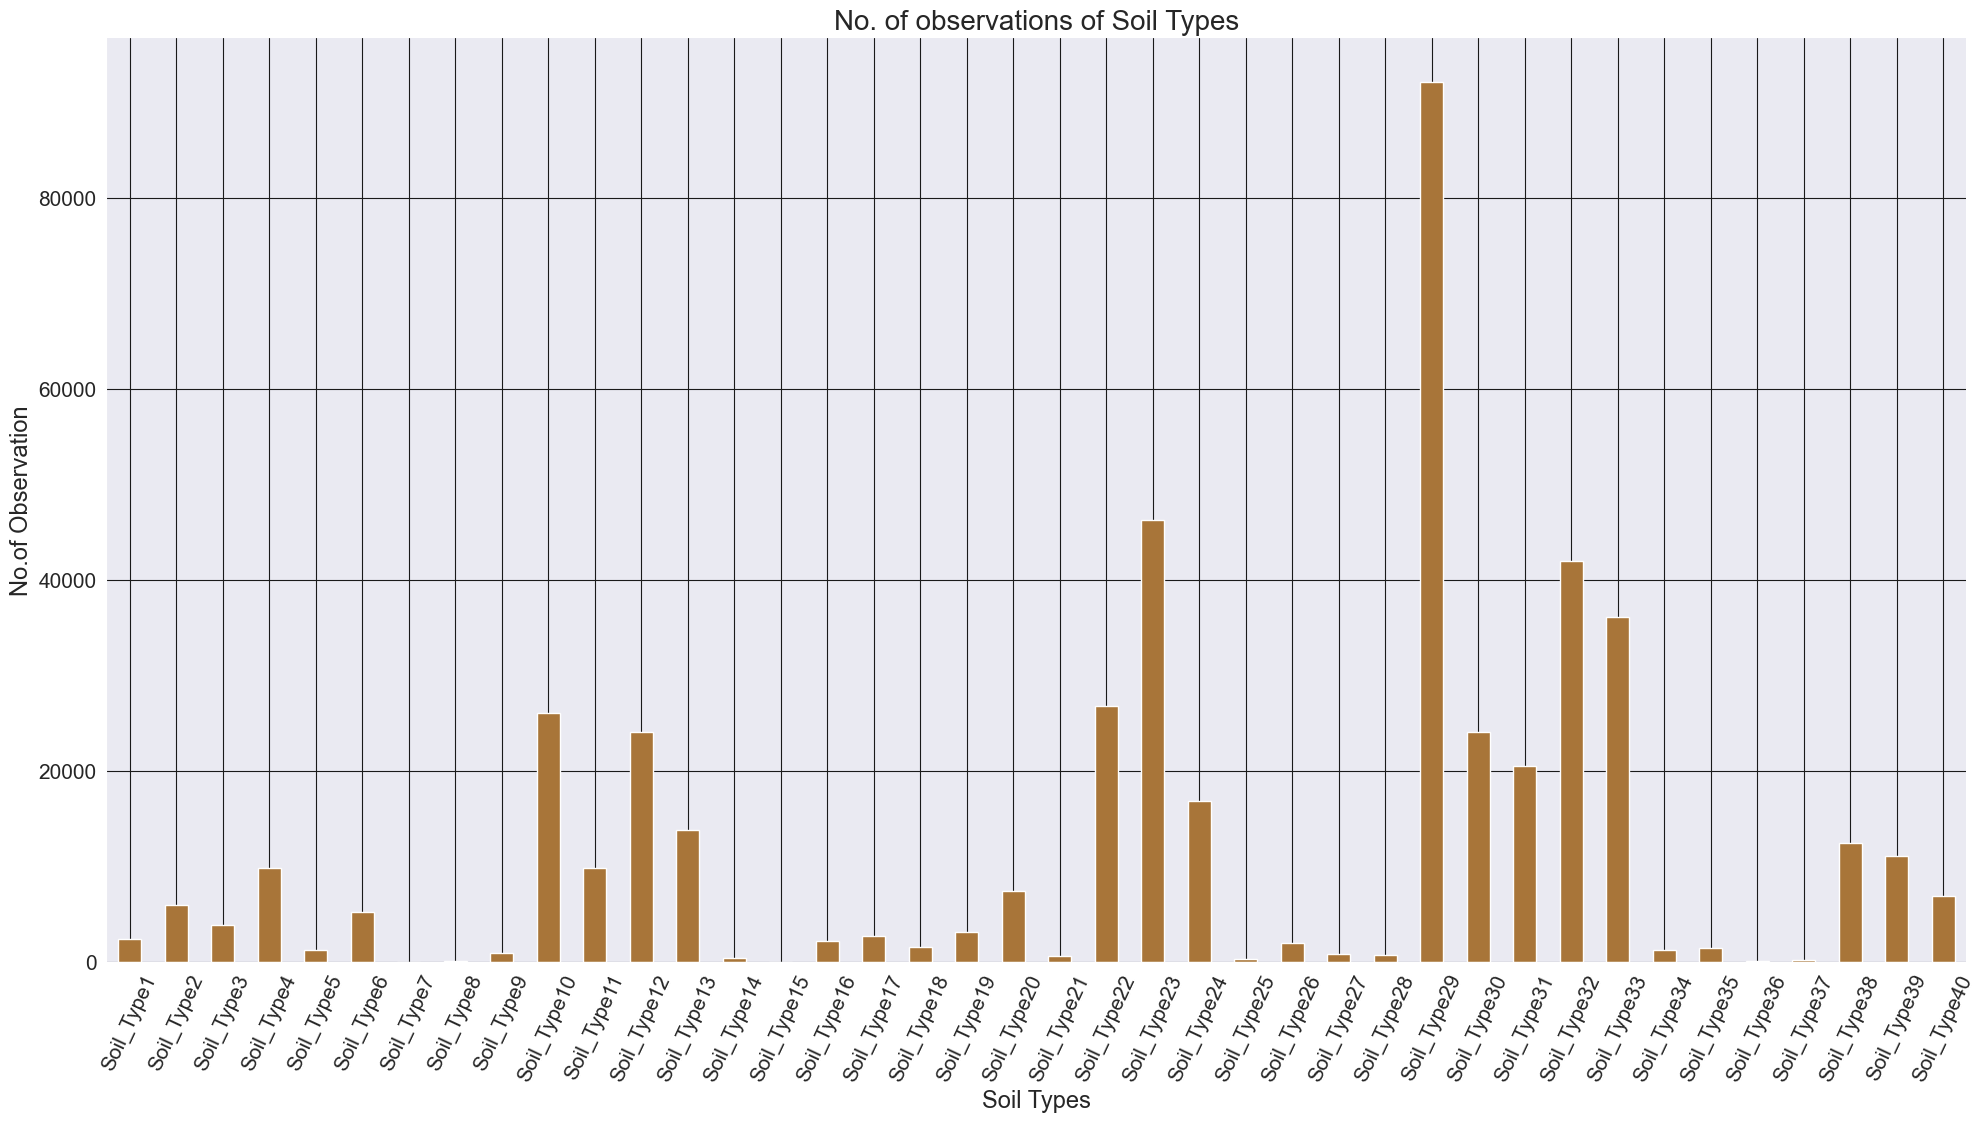

In [17]:
####    3.1    #####
# Bar plot
# Soil Type Count

# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})


# Sum the data, plot horizontal bar with given size using color defined
Soil_data.sum().plot(kind='bar', figsize=(24, 12), color='#a87539')

# Title of the graph
plt.title('No. of observations of Soil Types', size = 20)

# Horizontal axis Label
plt.xlabel('Soil Types', size = 17)
# Vertical axis Label
plt.ylabel('No.of Observation', size = 17)

# x-axis label size, setting label rotations
plt.xticks(rotation = 65, size = 15)
# y-axis label size
plt.yticks(size = 15)

# removing the top and right axes spines, which are not needed
sns.despine()

# display plot
plt.show()

In [18]:
# Statistical description of Highest observation of Soil Type seen
Soil_data.loc[:,'Soil_Type29'].describe()

count    464810.000000
mean          0.198305
std           0.398723
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Soil_Type29, dtype: float64

- `Slope` is densely packed with a small range. Its mean and median differ by about 1, with a few outliers.

- `Aspect` has no outliers and a range of 360, making it less dense compared to `Slope`.

- `Hillshade` features and `Vertical_Distance_To_Hydrology` have similar behavior to `Slope`, with many outliers. The latter has a negative minimum value.

- `Elevation` and `Horizontal_Distance_To_Hydrology` have non-zero minimum values, with `Elevation` having many outliers.

- `Horizontal_Distance_To_Roadways` is the most spread-out feature, followed by `Horizontal_Distance_To_Fire_Points`.

- Visualizations show normal, bimodal, unimodal, and skewed distributions. `Soil_Type15` has the highest skewness, while `Soil_Type29` has the most observations (about 20%).

- `Soil_Type29` has the highest presence, followed by `Soil_Type23`, `Soil_Type32`, and `Soil_Type33`.

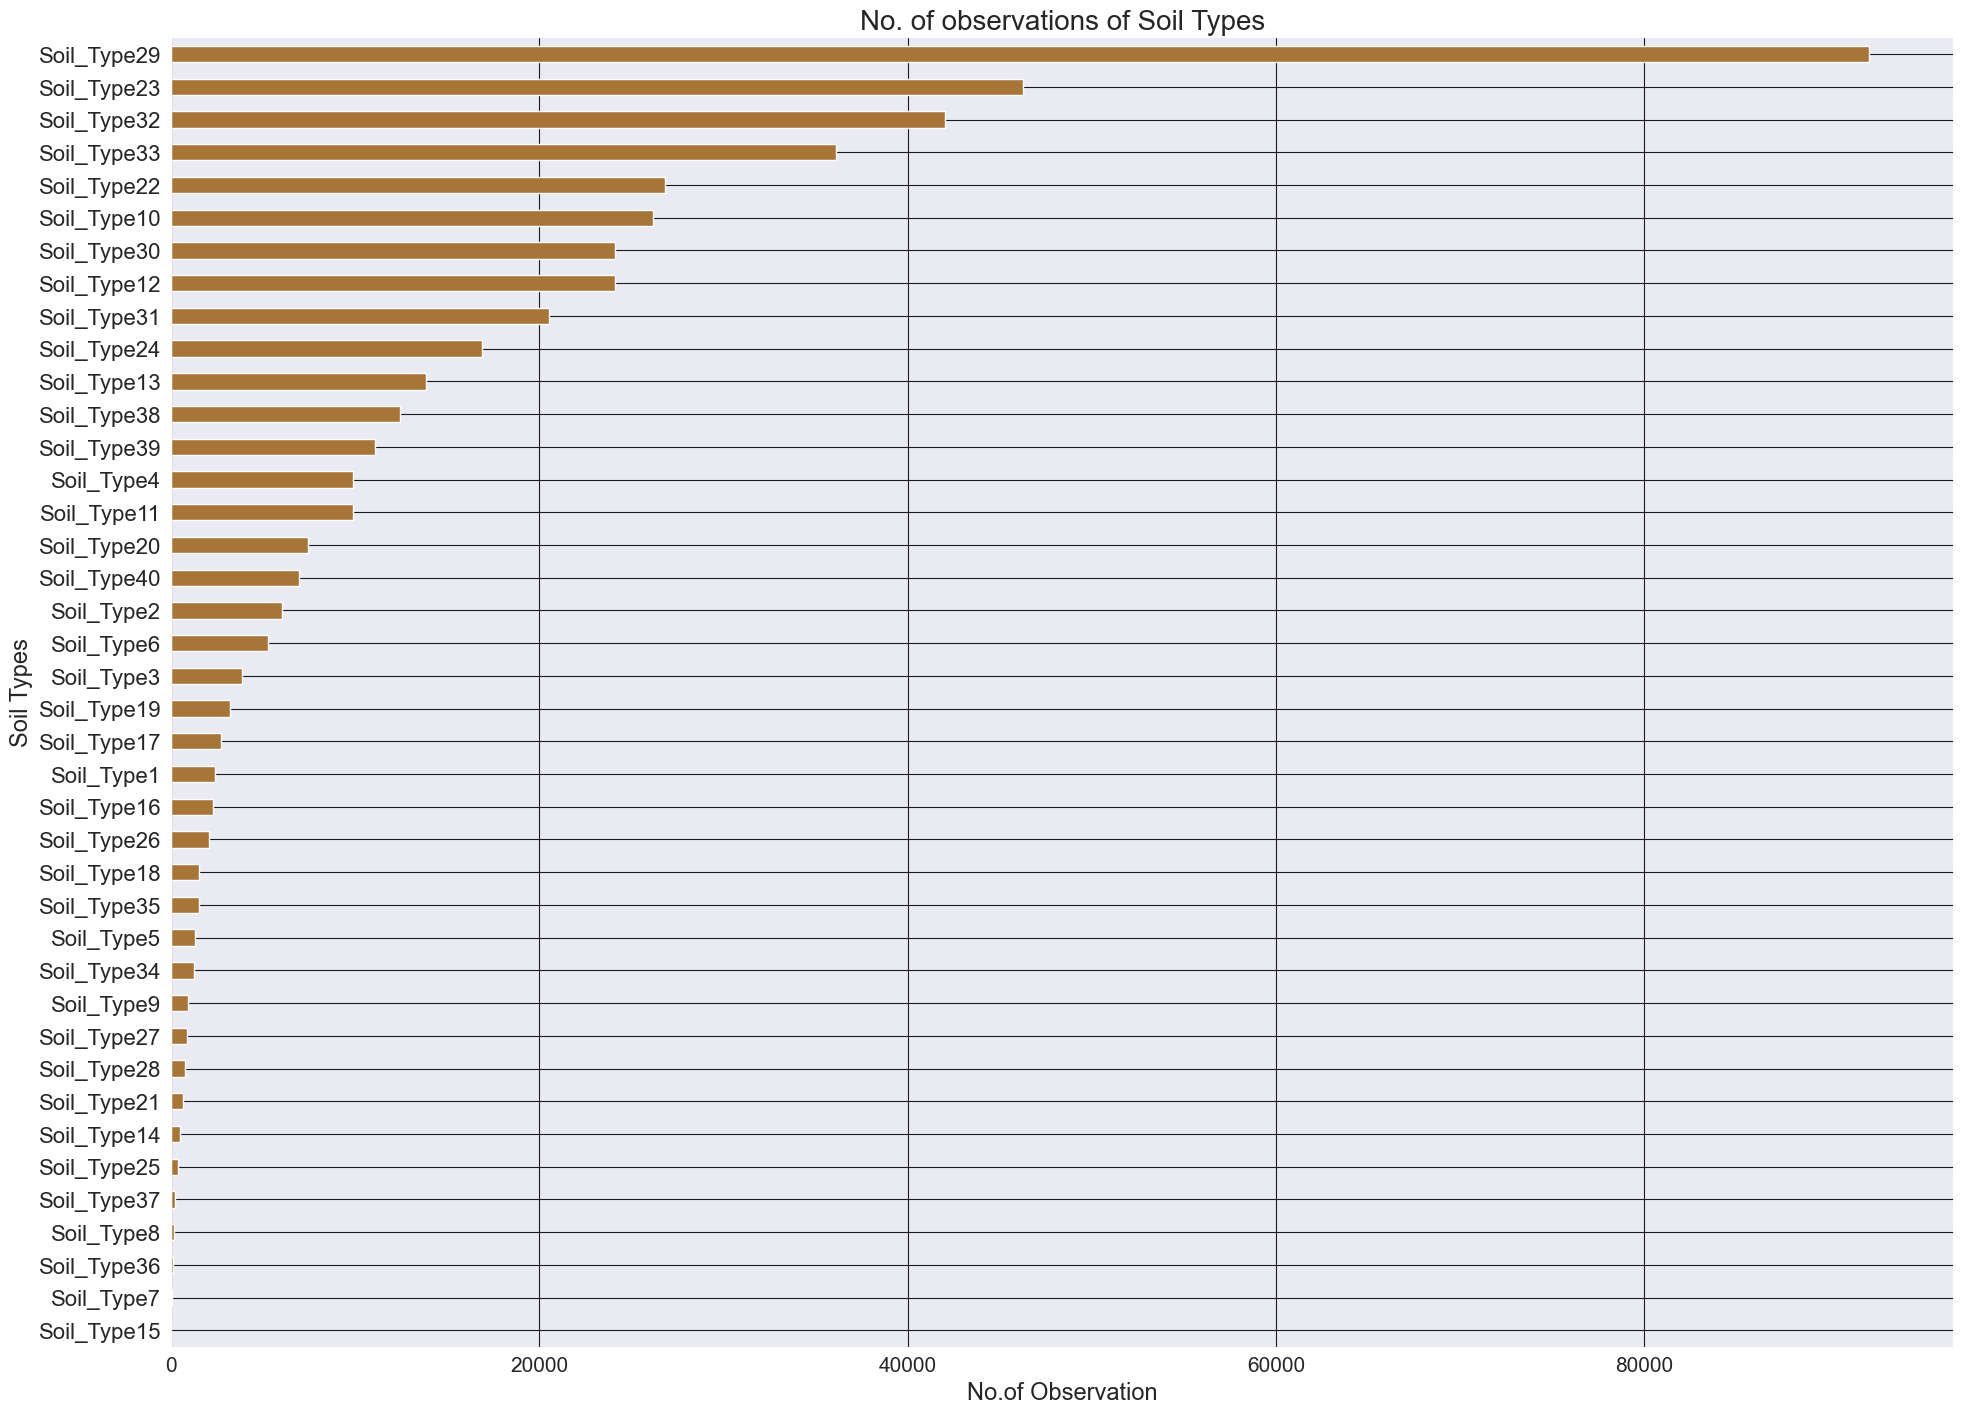

In [19]:
####    3.2    #####
# Horizontal Bar plot
# Soil Type Count

# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})

# sum Soil data values, and pass it as a series 
soil_sum = pd.Series(Soil_data.sum())

# will sort values in descending order
soil_sum.sort_values(ascending = False, inplace = True)

# plot horizontal bar with given size using color defined
soil_sum.plot(kind='barh', figsize=(23, 17), color= '#a87539')

# horizontal bar flips columns in ascending order, this will filp it back in descending order
plt.gca().invert_yaxis()

# Title of the graph
plt.title('No. of observations of Soil Types', size = 20)

# Horizontal axis Label
plt.xlabel('No.of Observation', size = 17)
# Vertical axis Label
plt.ylabel('Soil Types', size = 17)

# x-axis label size, setting label rotations
plt.xticks(rotation = 'horizontal', size = 15)
# y-axis label size
plt.yticks(size = 16)

# removing the top and right axes spines, which are not needed
sns.despine()

# display plot
plt.show()

In [20]:
# Exact counts of observations of Soil Type
soil_sum

Soil_Type29    92174
Soil_Type23    46283
Soil_Type32    42010
Soil_Type33    36122
Soil_Type22    26821
Soil_Type10    26156
Soil_Type30    24120
Soil_Type12    24088
Soil_Type31    20505
Soil_Type24    16896
Soil_Type13    13848
Soil_Type38    12445
Soil_Type39    11093
Soil_Type4      9909
Soil_Type11     9899
Soil_Type20     7421
Soil_Type40     6947
Soil_Type2      6019
Soil_Type6      5261
Soil_Type3      3876
Soil_Type19     3186
Soil_Type17     2728
Soil_Type1      2420
Soil_Type16     2262
Soil_Type26     2051
Soil_Type18     1545
Soil_Type35     1528
Soil_Type5      1283
Soil_Type34     1277
Soil_Type9       916
Soil_Type27      861
Soil_Type28      766
Soil_Type21      672
Soil_Type14      480
Soil_Type25      381
Soil_Type37      240
Soil_Type8       145
Soil_Type36       99
Soil_Type7        75
Soil_Type15        2
dtype: int64

- The least observation are of `Soil_Type15` of `3`. That's why it had most skewed value of all `Soil Types` of `~440` which now makes sense since this feature has value of `0` for all except for `3` observations hence making it densly concentrated towards `0` and long flat tail to the right having a form of `positively skewed distribution` or `Right Skewed Distribution`.
- `Soil_Type29` has the highest, `115,246` observations.

-------

#### Feature Comparison

**Next let's compare each feature in our data to our target variable, visualizing how much dense and distributed each target variable's class is compared to the feature. We will use [Violin Plot](https://datavizcatalogue.com/methods/violin_plot.html) to visualize this, a combination of Box Plot and Density Plot (Histogram).**

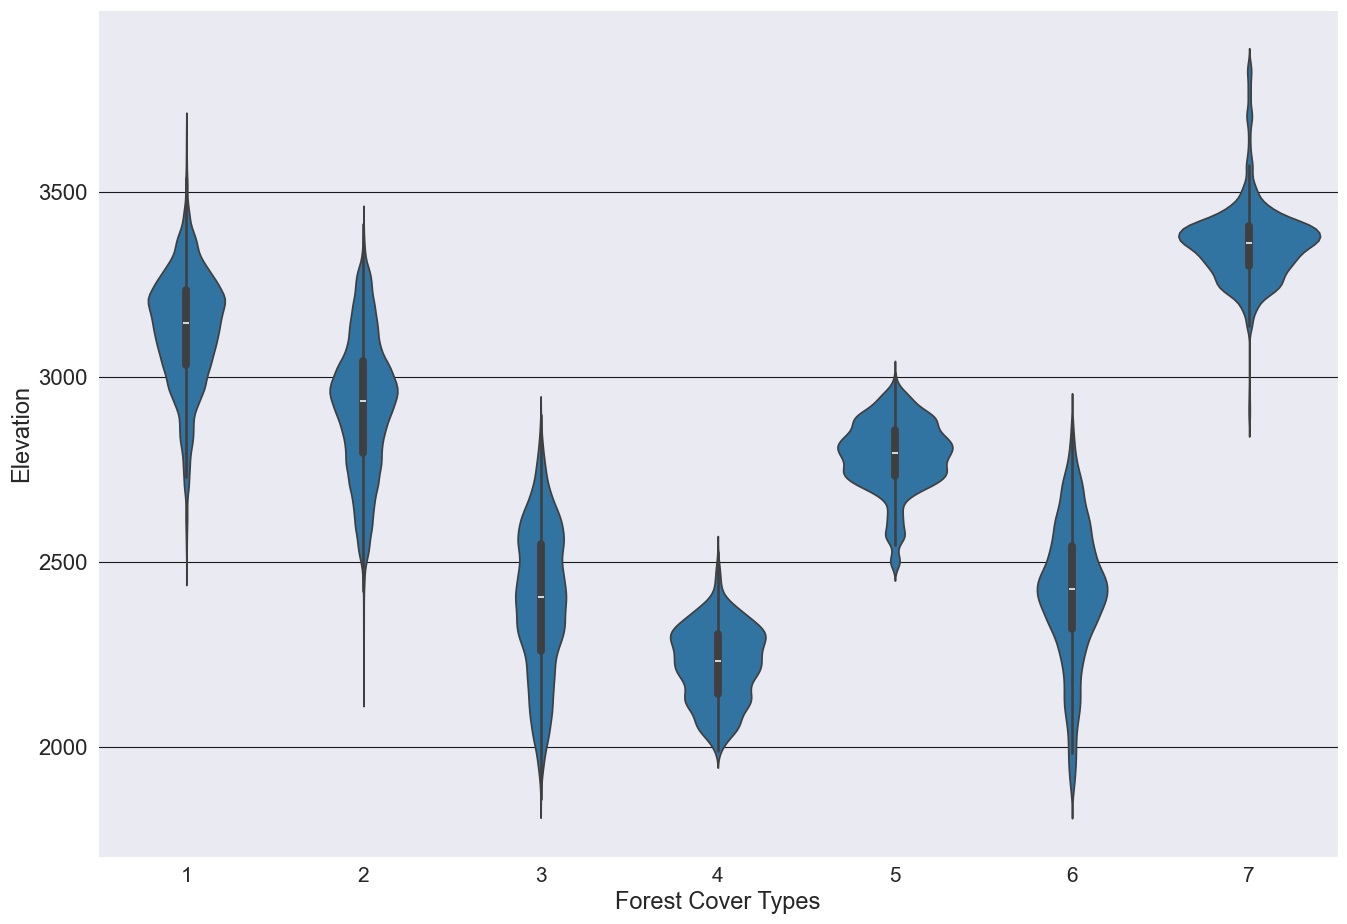

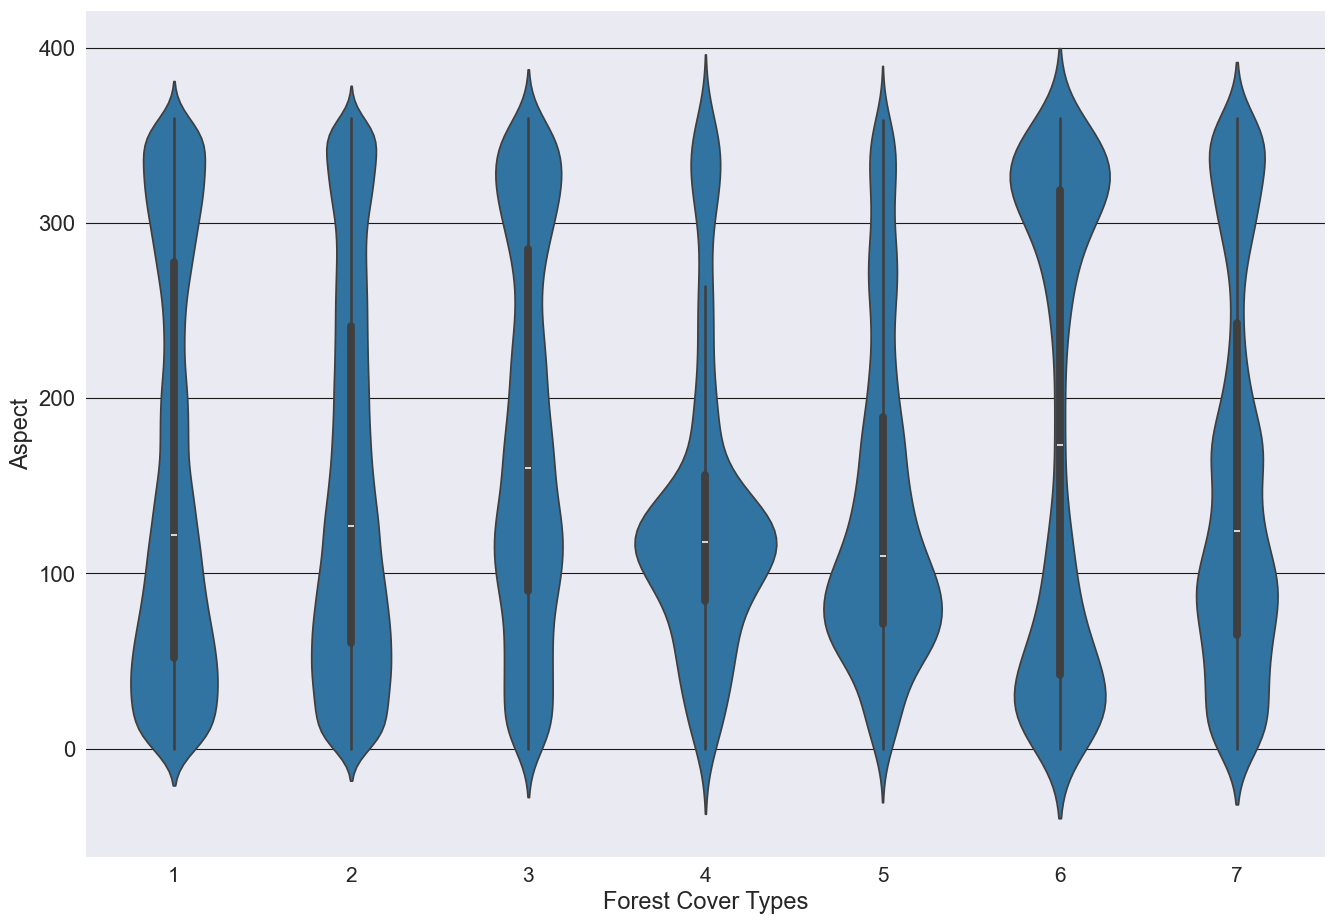

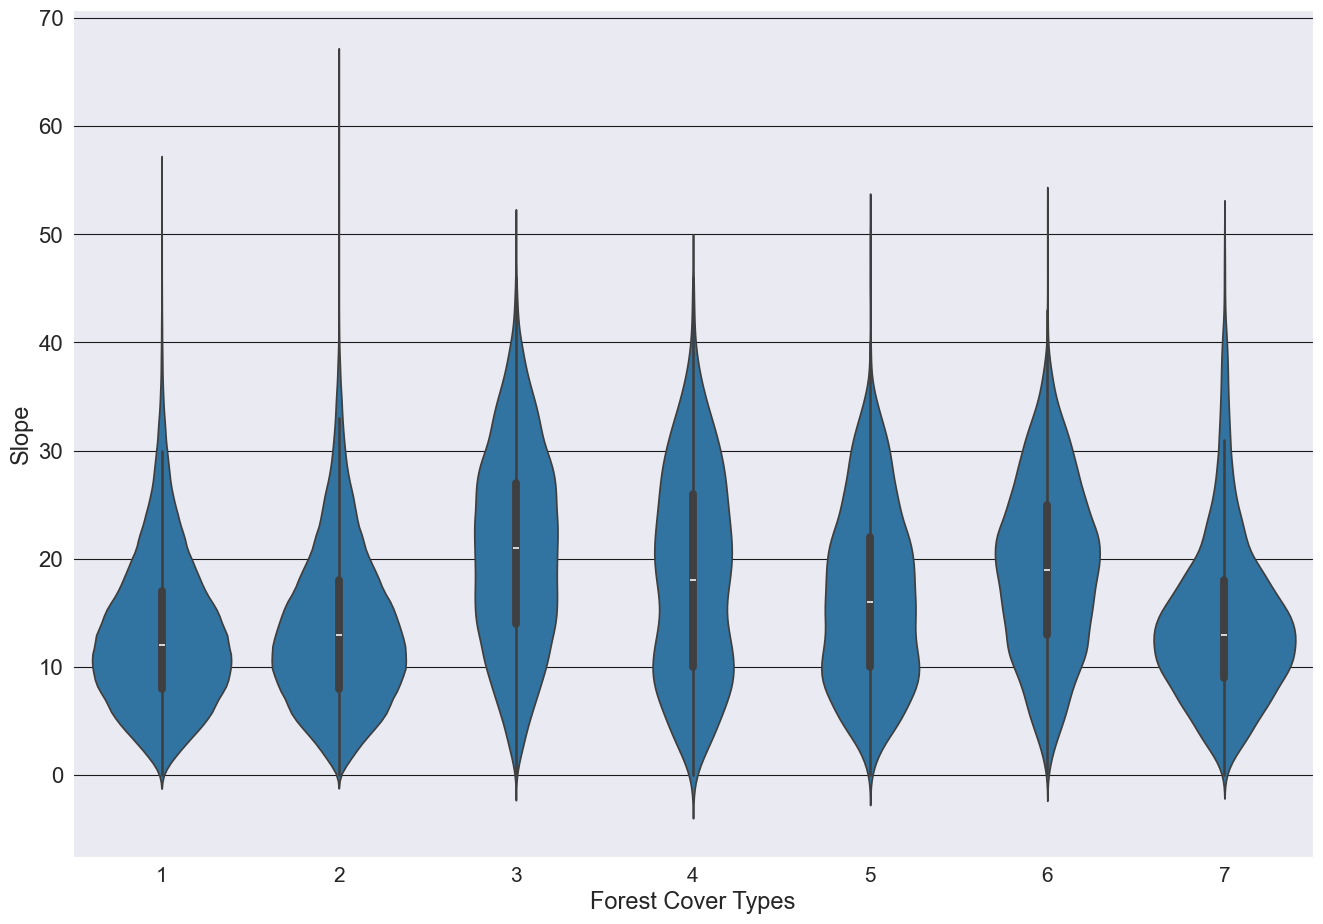

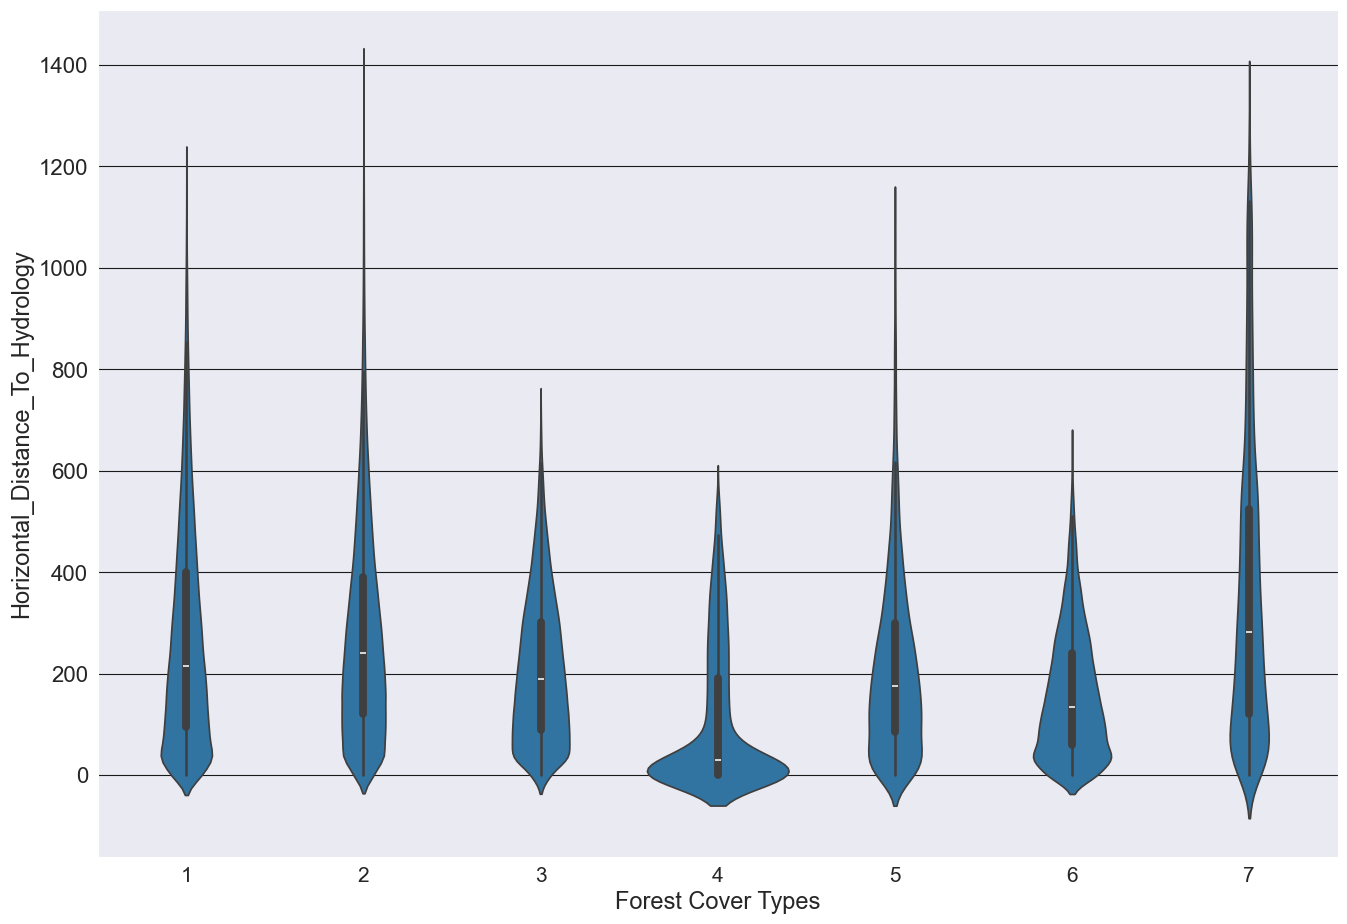

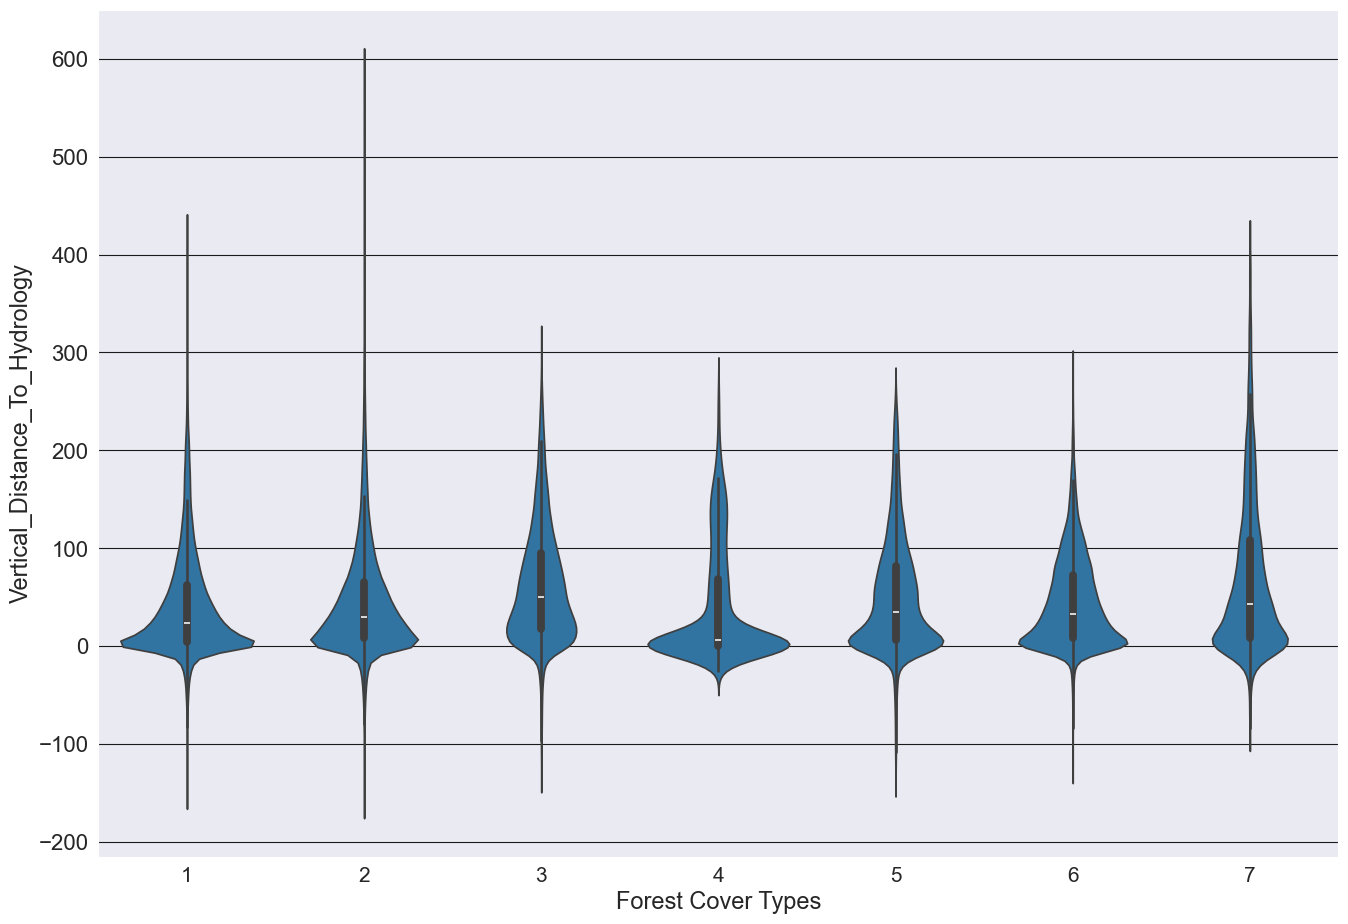

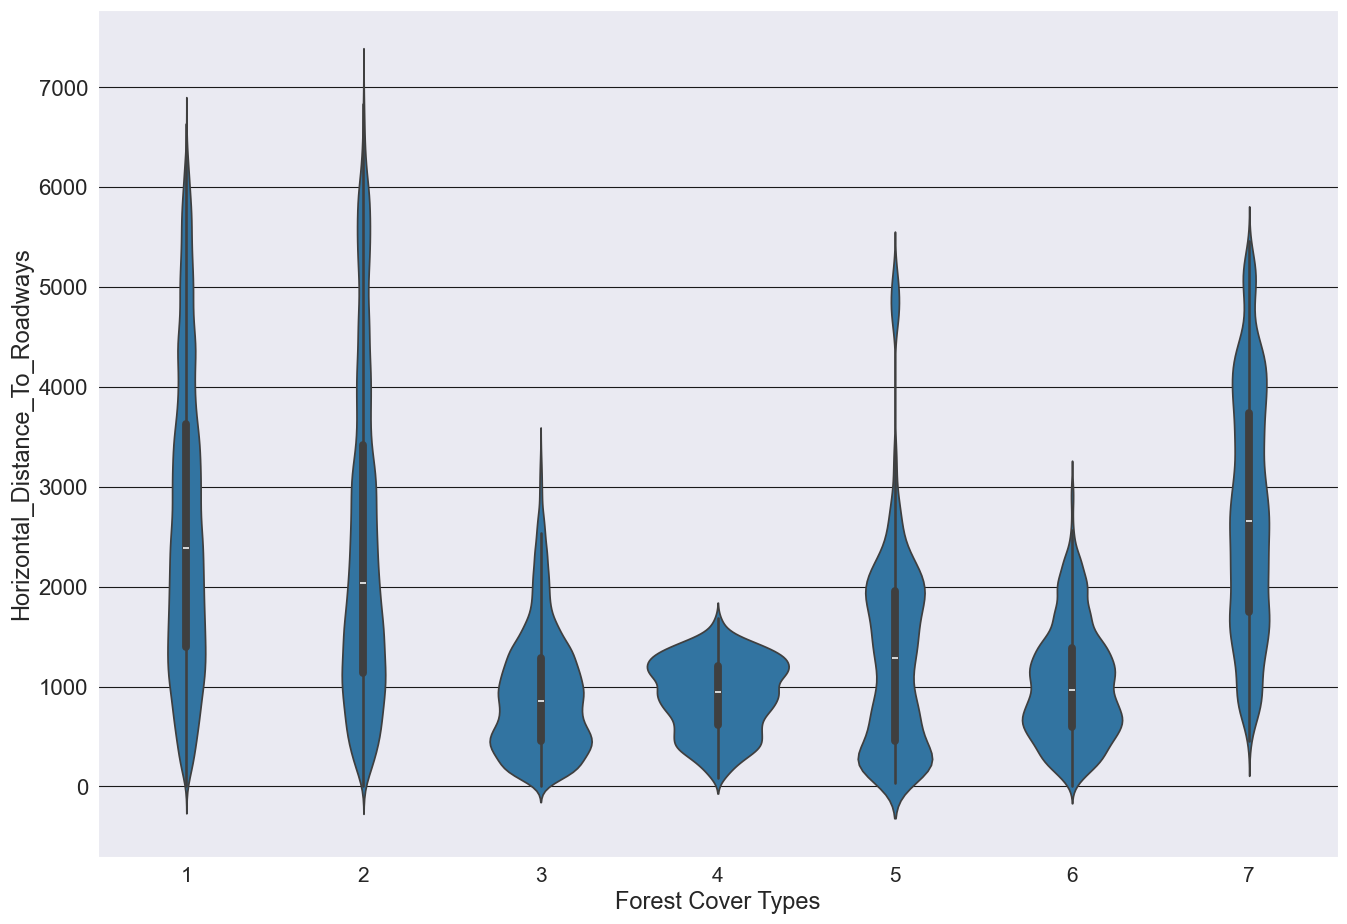

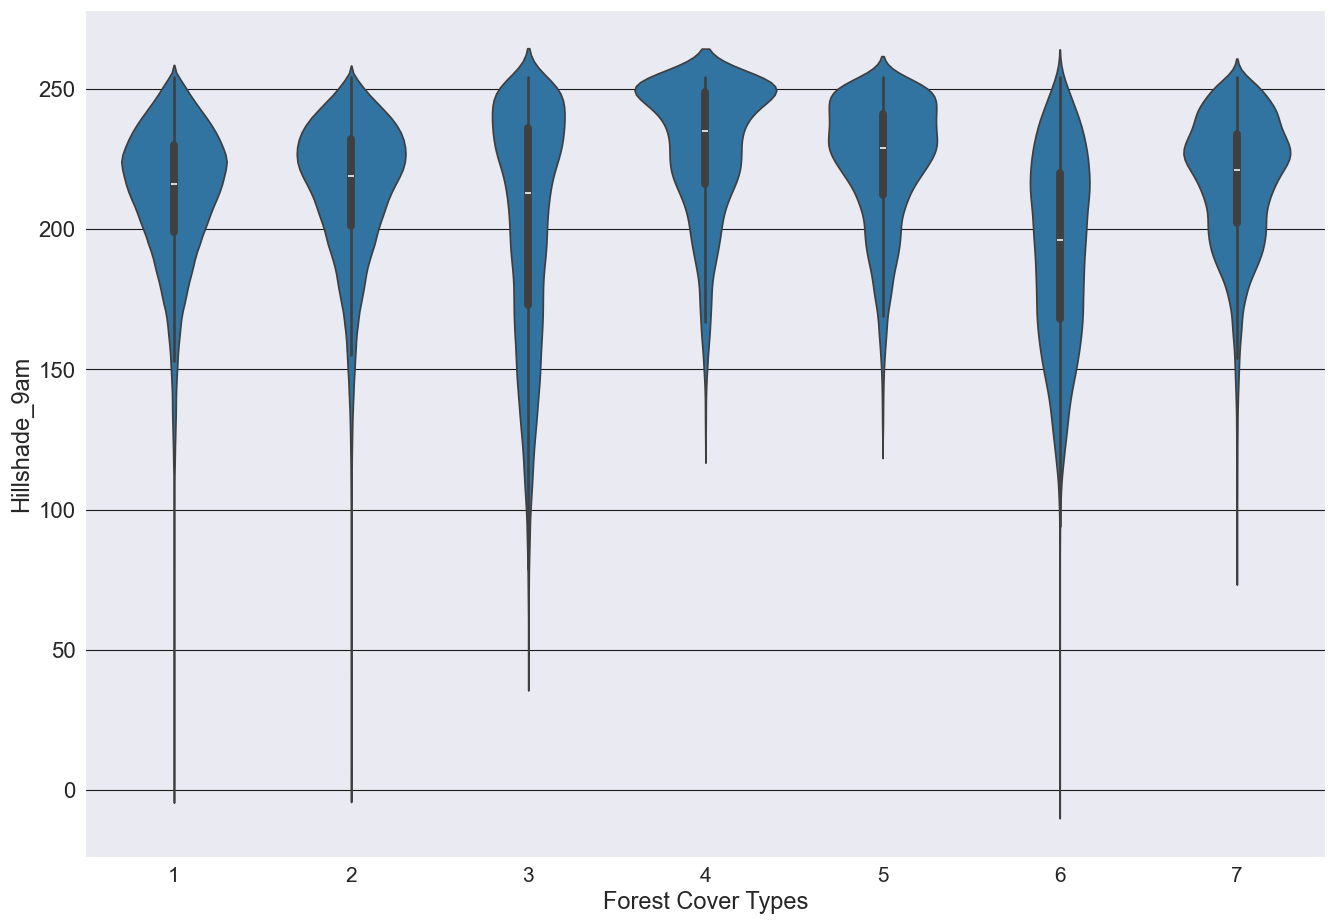

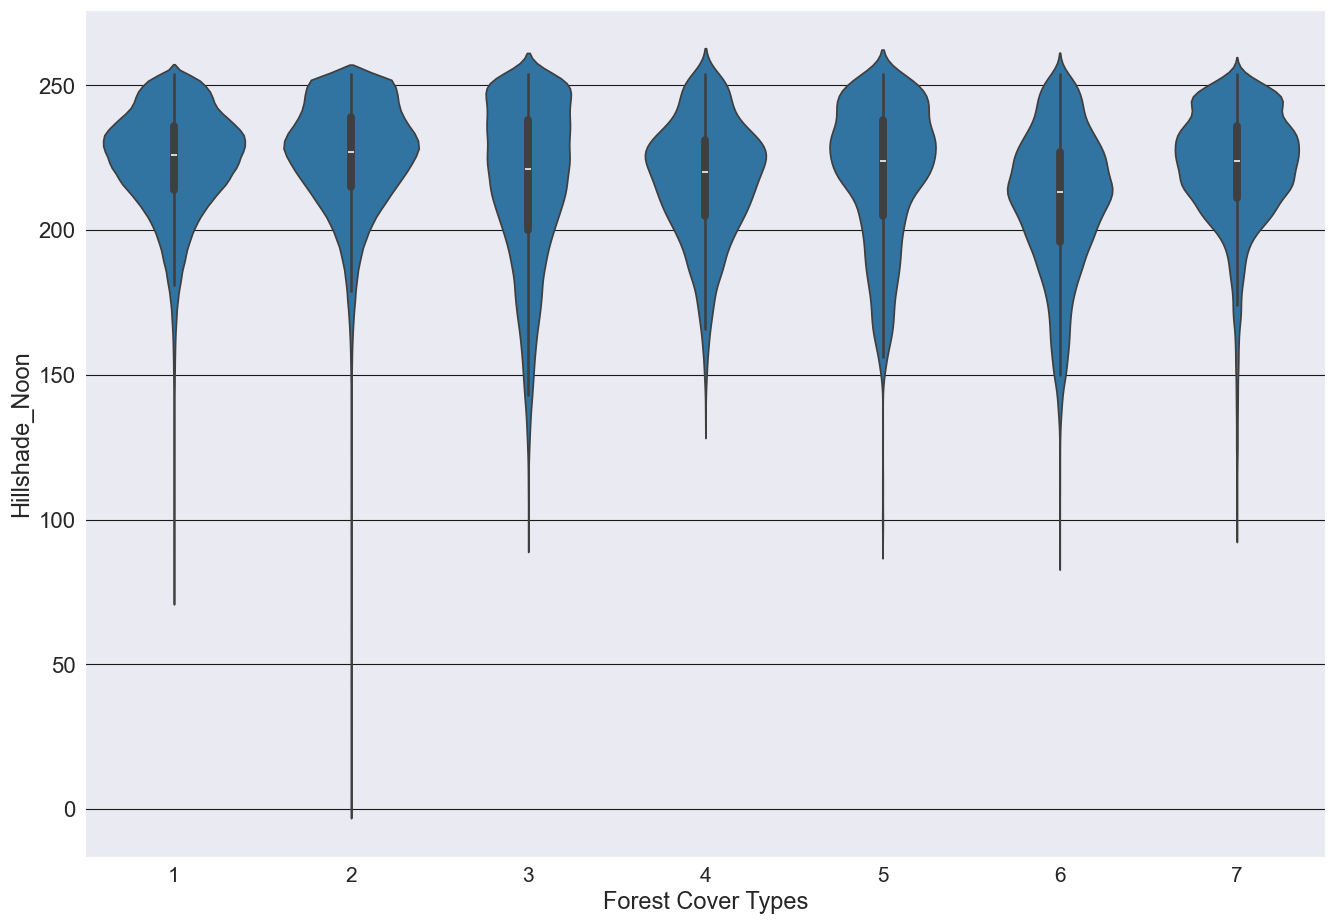

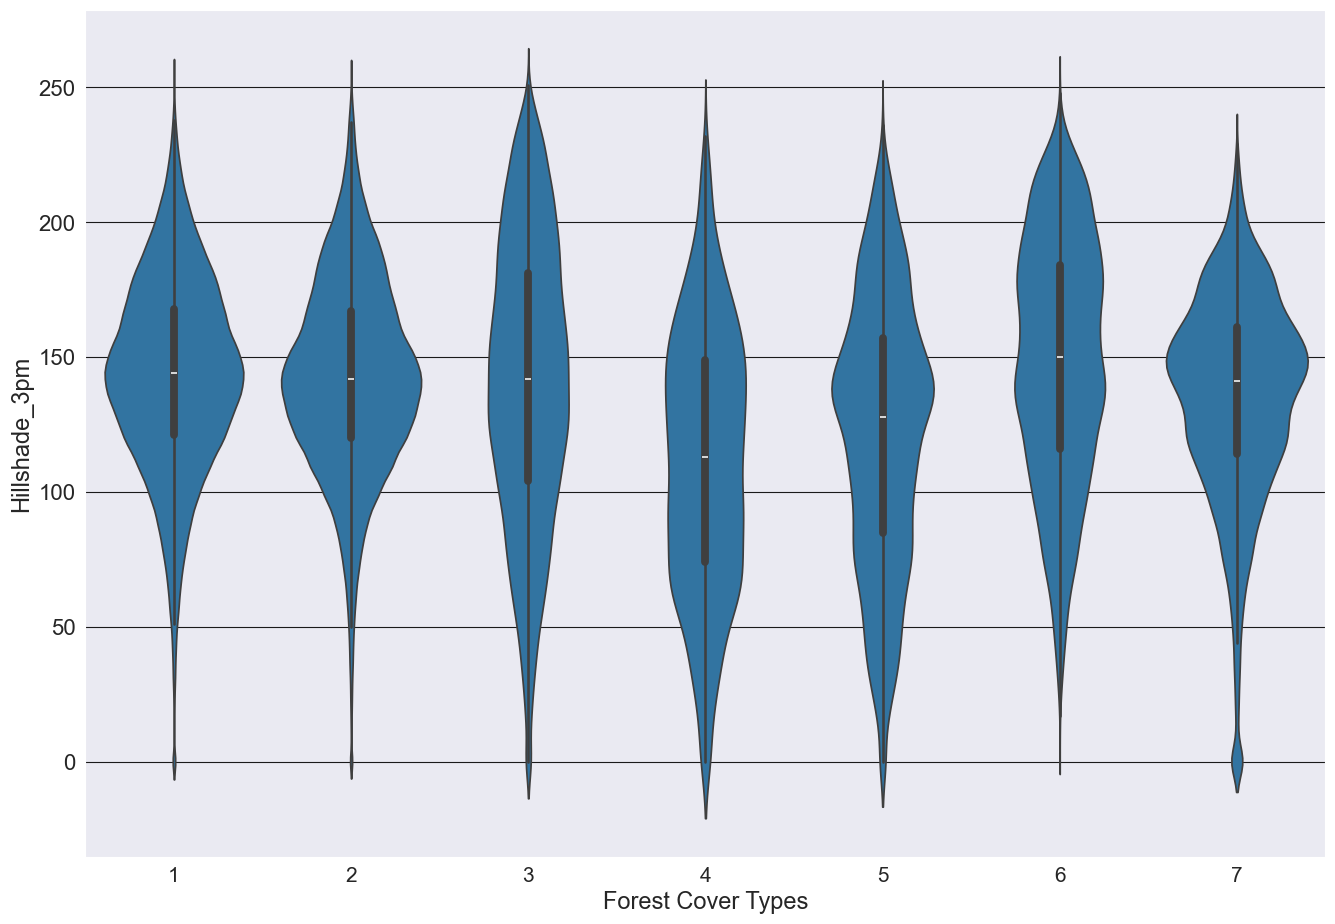

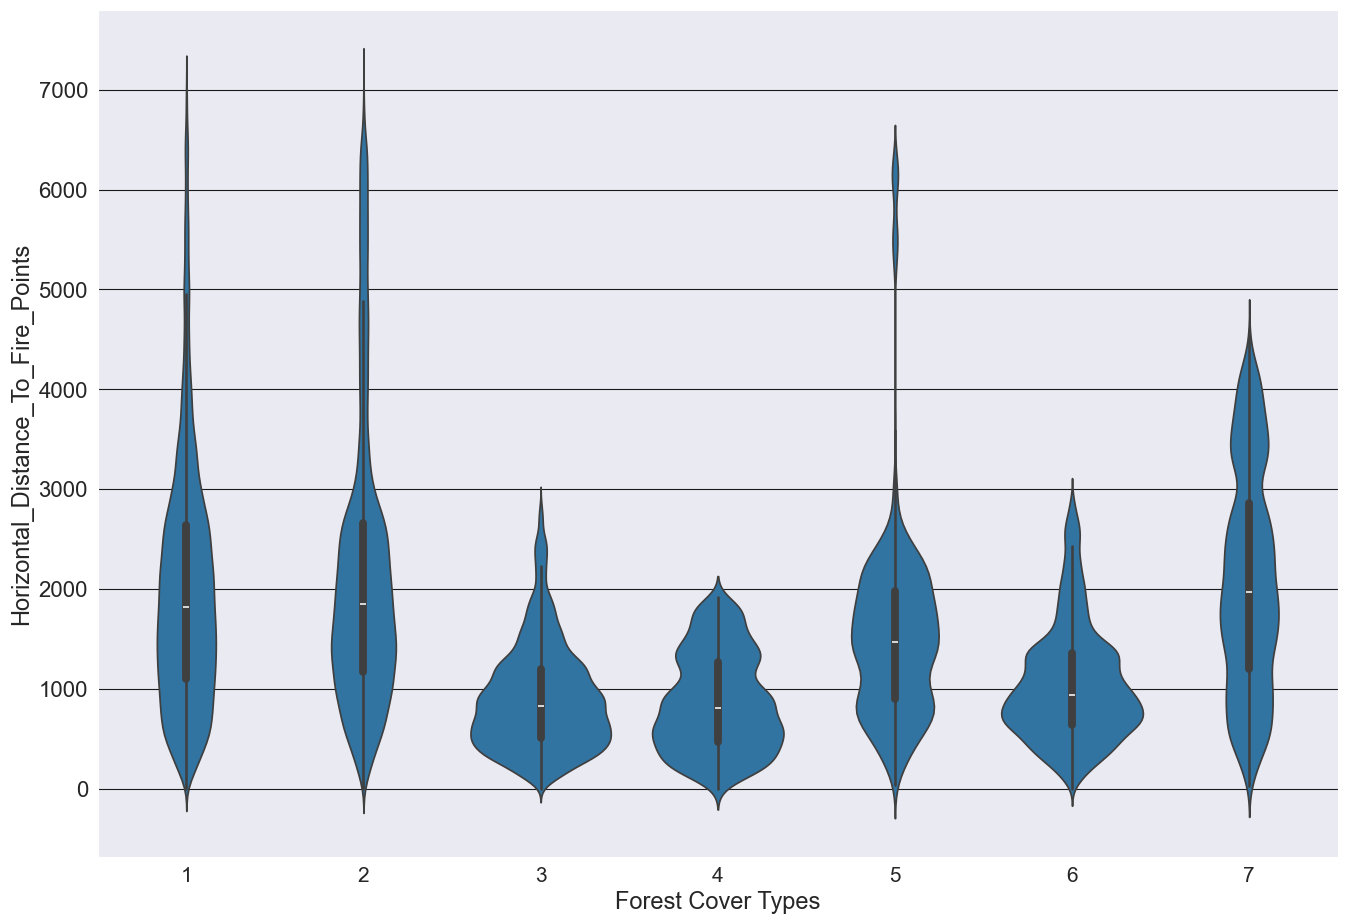

In [21]:
#######    4.1    ########
# Violin Plot (Box + Density)
# Comparing numerical features with target variable


# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})

# setting target variable
target = data['Cover_Type']

# features to be compared with target variable
features = num_fea.columns


# loop for plotting Violin Plot for each features in the data
for i in range(0, len(features)):
    
    #figure size
    plt.subplots(figsize=(16, 11))
    
    # Plot violin for i feature for every class in target 
    sns.violinplot(data=num_fea, x=target, y = features[i])
    
    # x-axis label size
    plt.xticks(size = 15)
    # y-axis label size
    plt.yticks(size = 16)

    # Horizontal axis Label
    plt.xlabel('Forest Cover Types', size = 17)
    # Vertical axis Label
    plt.ylabel(features[i], size = 17)
  
    # display plot
    plt.show()

* `Elevation` : Varie selon les types de forêts. La classe 4 prédomine entre 2000-2500m, tandis que la classe 7 atteint les altitudes les plus élevées (2800-3800m), faisant de cette caractéristique une clé.
* `Aspect` : Distribution normale pour toutes les classes.
* `Slope` : Densité entre 0-20° pour toutes les classes, avec la plus petite valeur maximale associée à la classe 2.
* `Horizontal` et `Vertical distance to hydrology` : Distribution positivement asymétrique, avec la classe 2 ayant la plus large gamme de valeurs verticales.
* `Hillshade` : Hillshade_9am et Noon sont négativement asymétriques, tandis que Hillshade_3pm a une distribution normale.

Voyons maintenant la visualisation des `Wilderness Areas`.

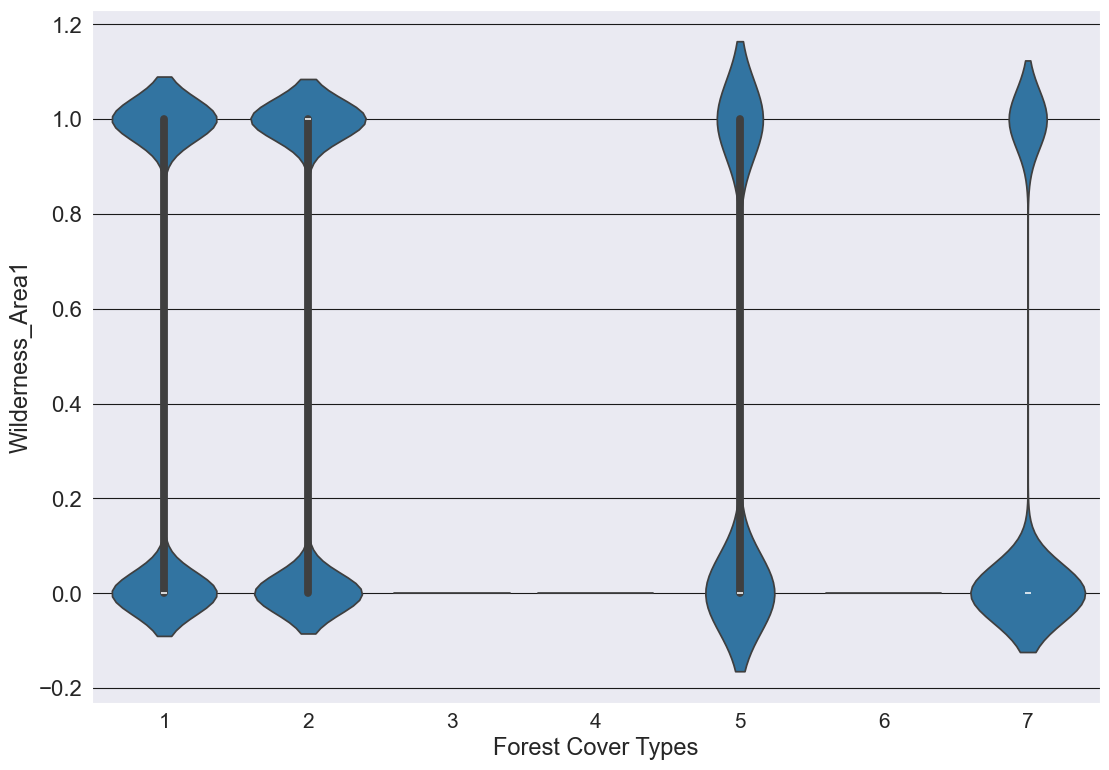

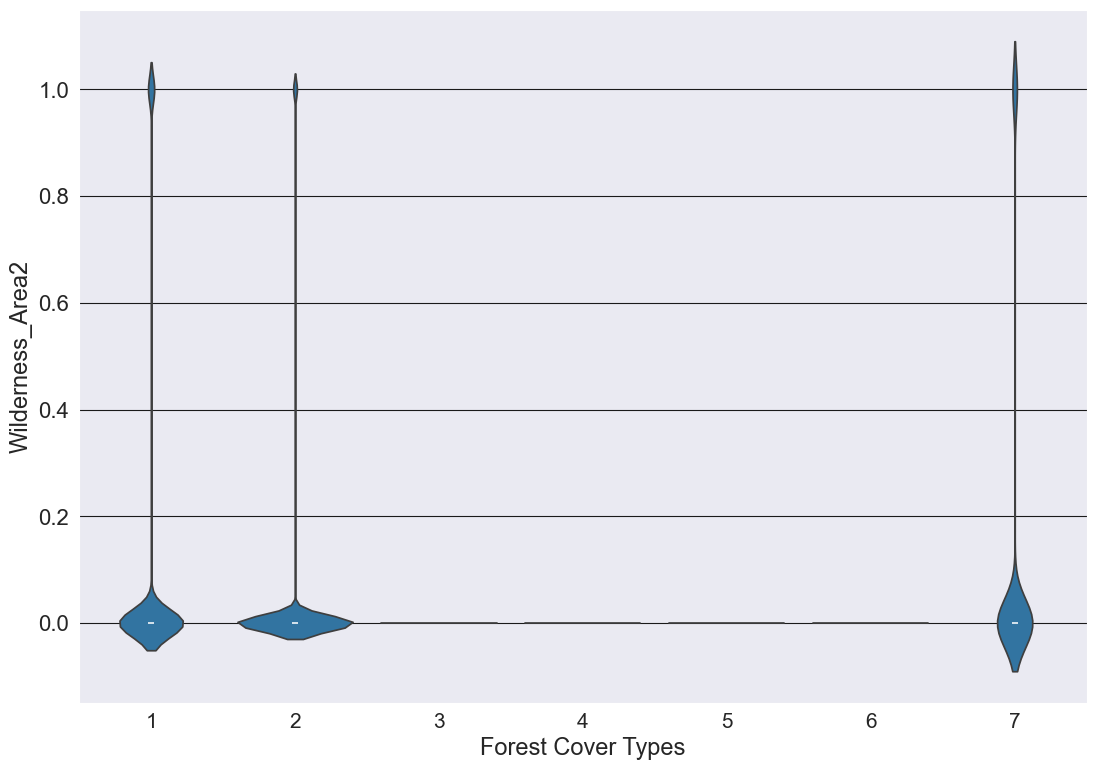

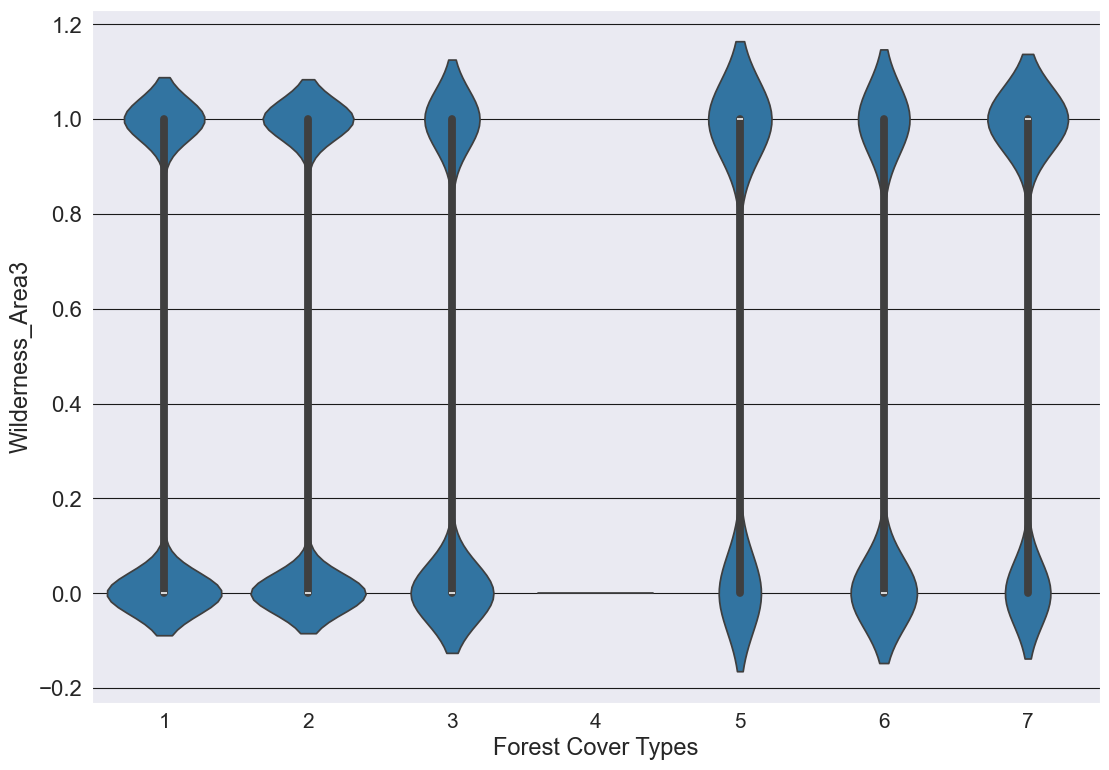

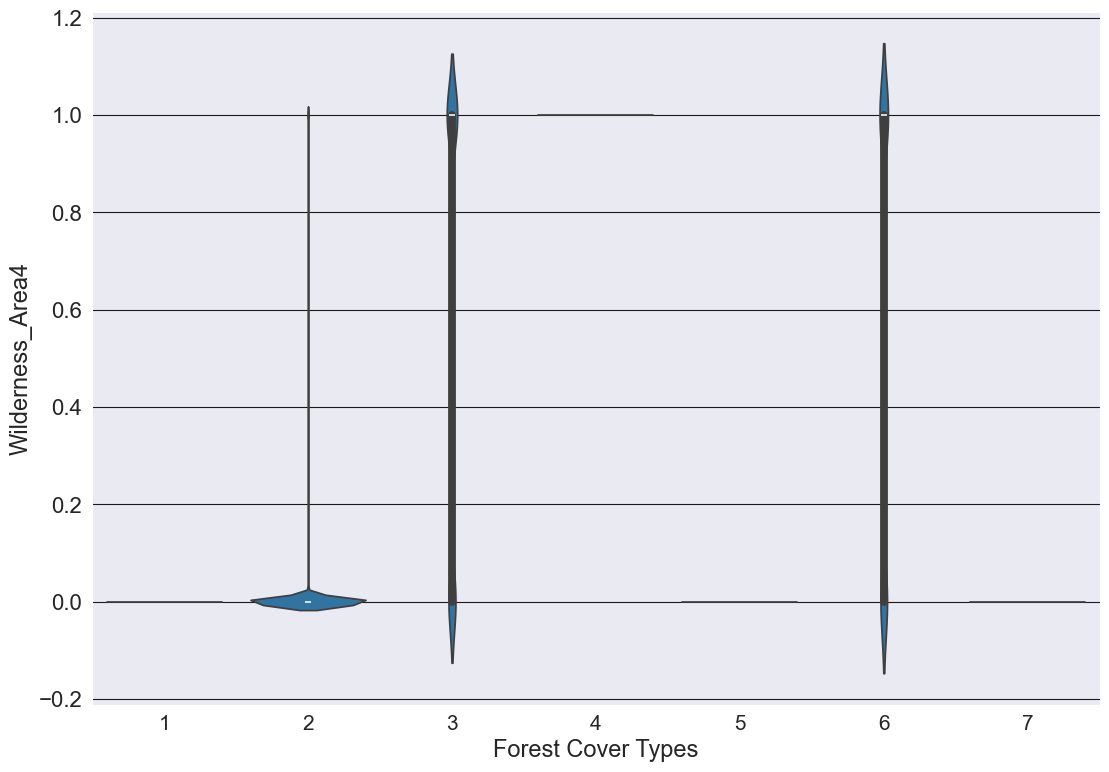

In [22]:
#######    4.2    ########
# Violin Plot (Box + Density)
# Comparing Wilderness features with target variable


# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})

# setting target variable
target = data['Cover_Type']
# features to be compared with target variable
features = Wild_data.columns


# loop for plotting Violin Plot for each features in the data
for i in range(0, len(features)):
    
    #figure size
    plt.subplots(figsize=(13, 9))
    
    # Plot violin for i feature for every class in target
    sns.violinplot(data = Wild_data, x=target, y = features[i])
    
    # x-axis label size
    plt.xticks(size = 15)
    # y-axis label size
    plt.yticks(size = 16)

    # Horizontal axis Label
    plt.xlabel('Forest Cover Types', size = 17)
    # Vertical axis Label
    plt.ylabel(features[i], size = 17)

    # display plot
    plt.show()

The reason these plots look so different than before is because these features take on value ranging between `0 and 1`. 

- `Wilderness Area 1` belong to `forest cover type 1, 2, 5 and 7` while `wilderness area 3` shows presence in `all classes` except `Forest Cover Type 4`.

- `Wilderness Area 2 and 4` have less observations, their dense is less on `1` on all classes compared to other two `Wilderness Areas 1 and 3`.



**Now lets visualize `Soil Type`**

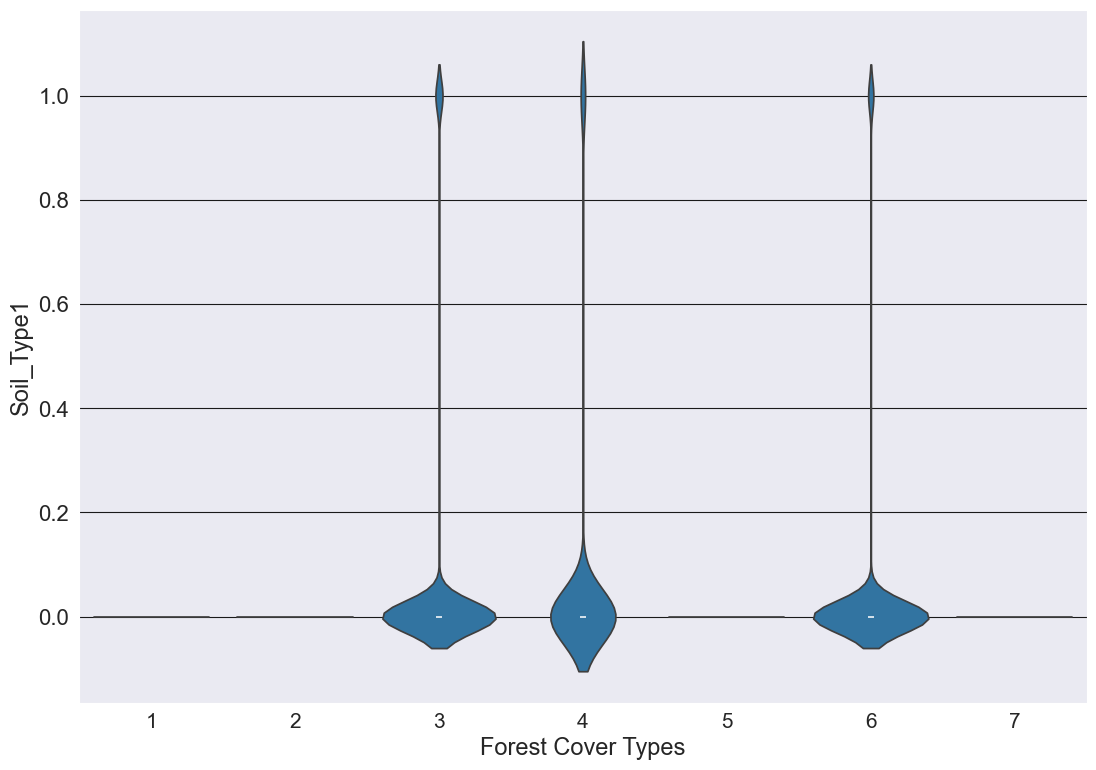

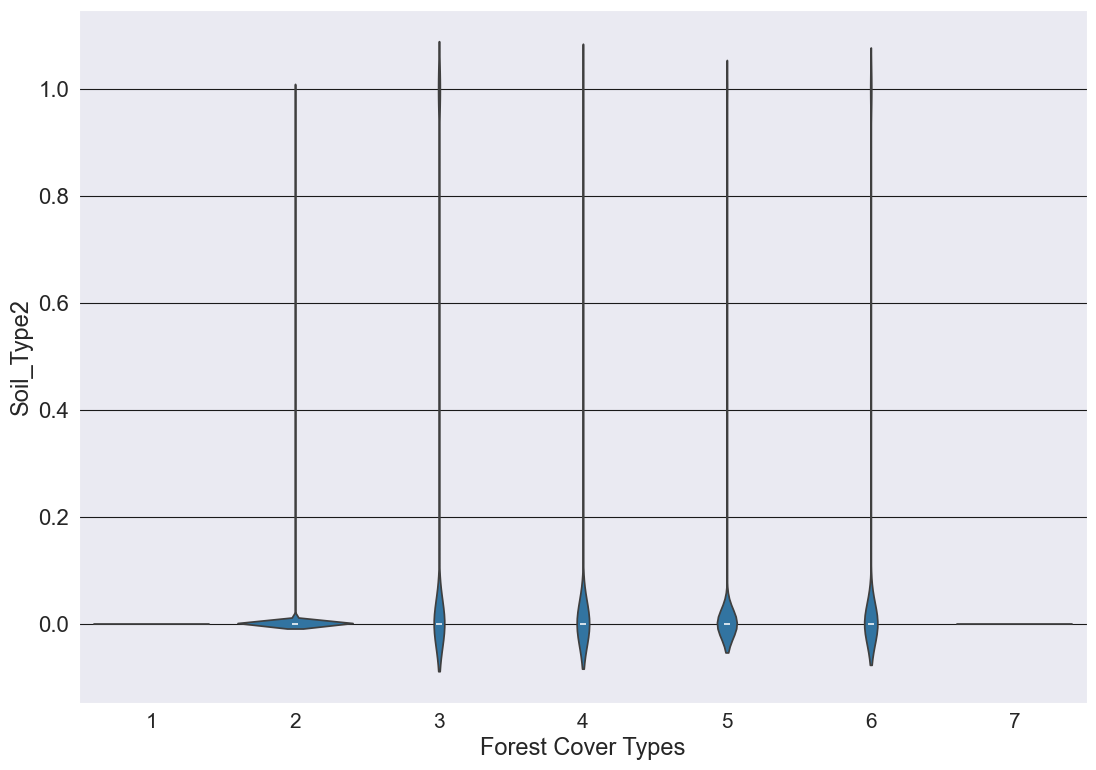

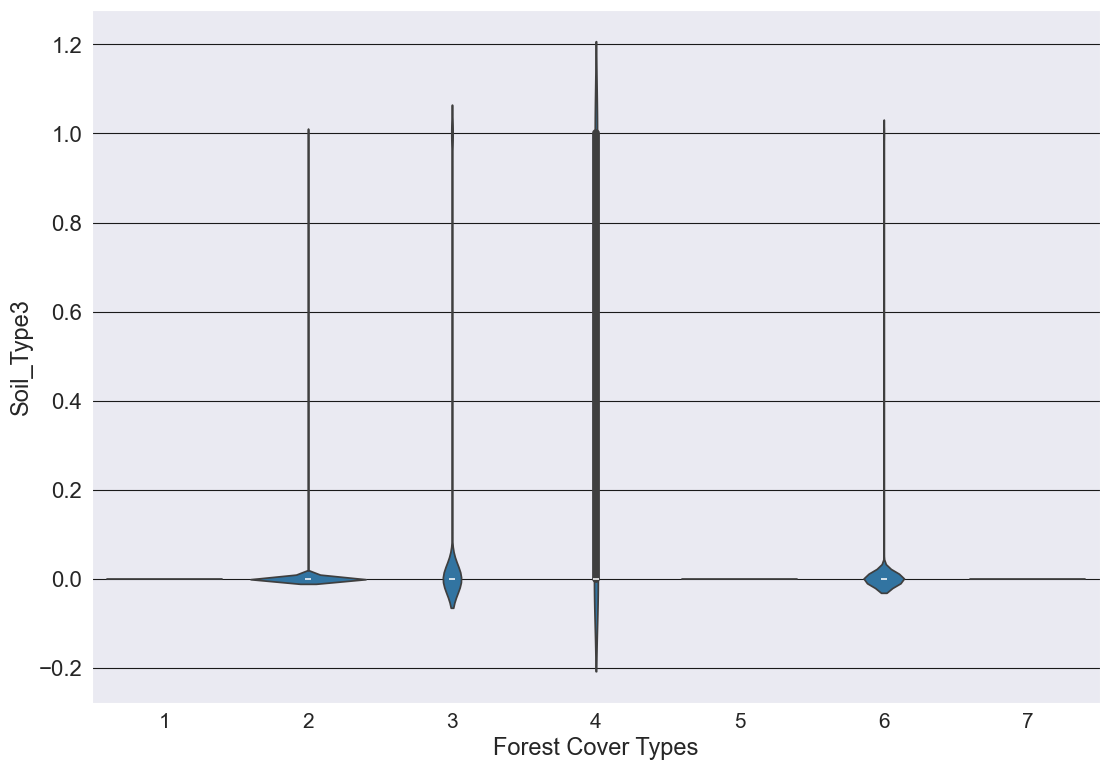

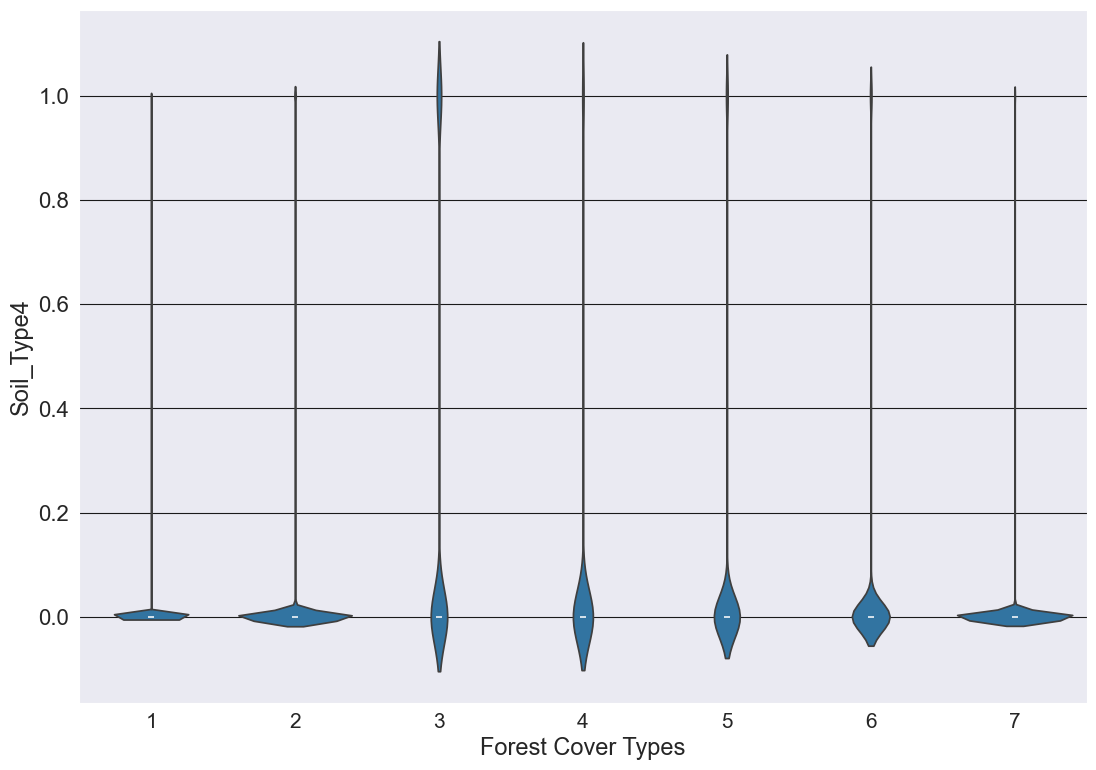

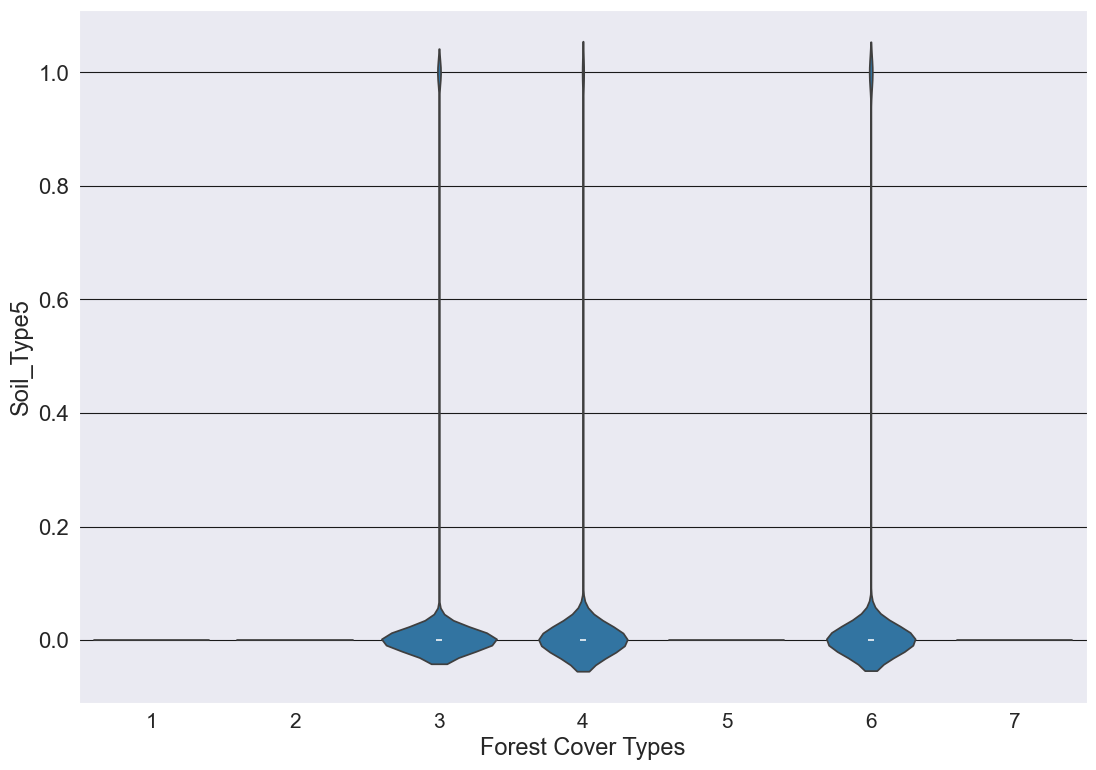

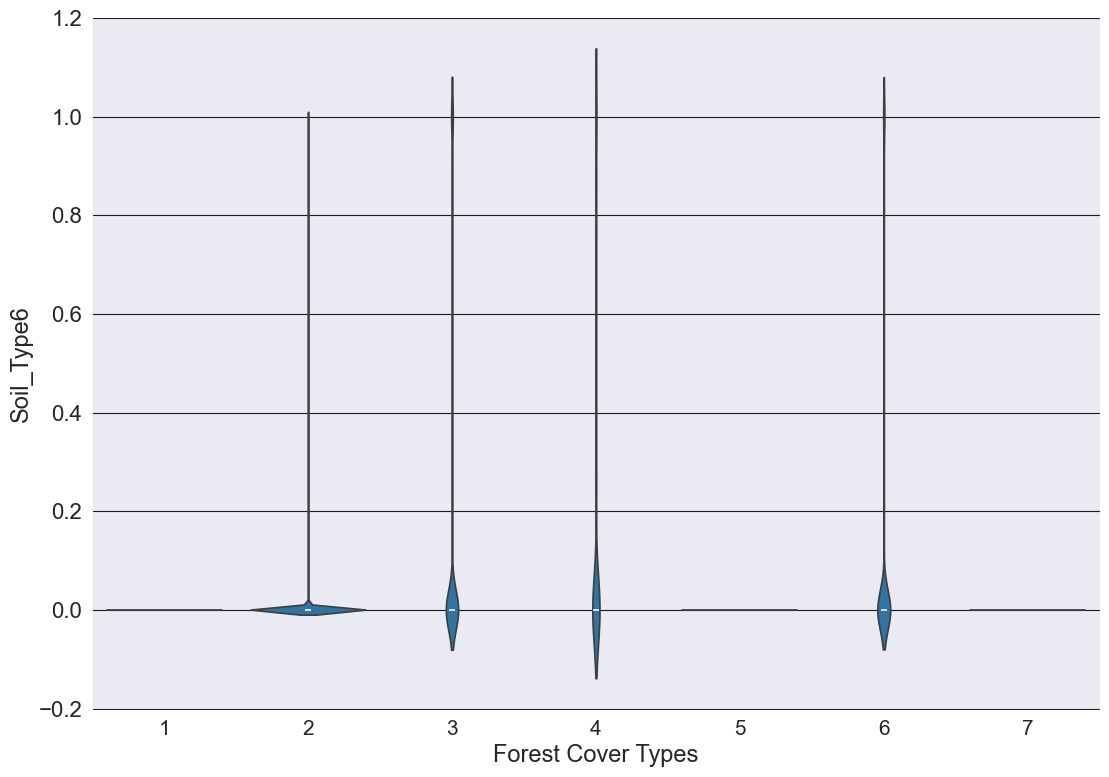

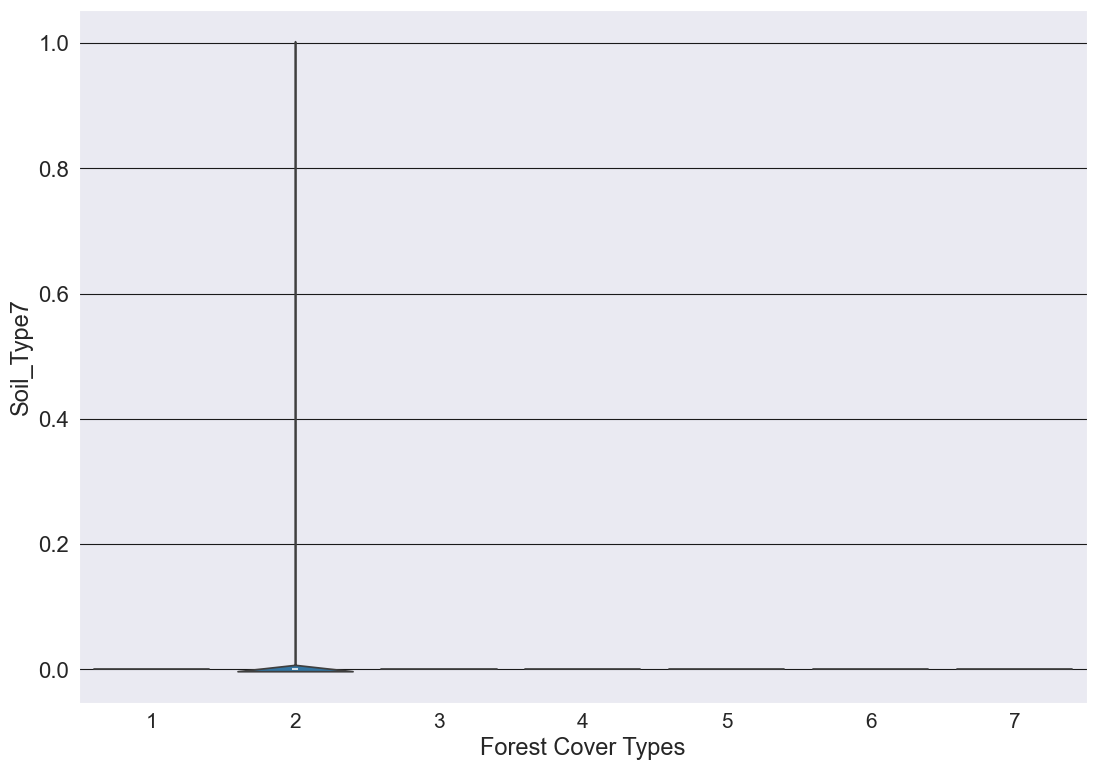

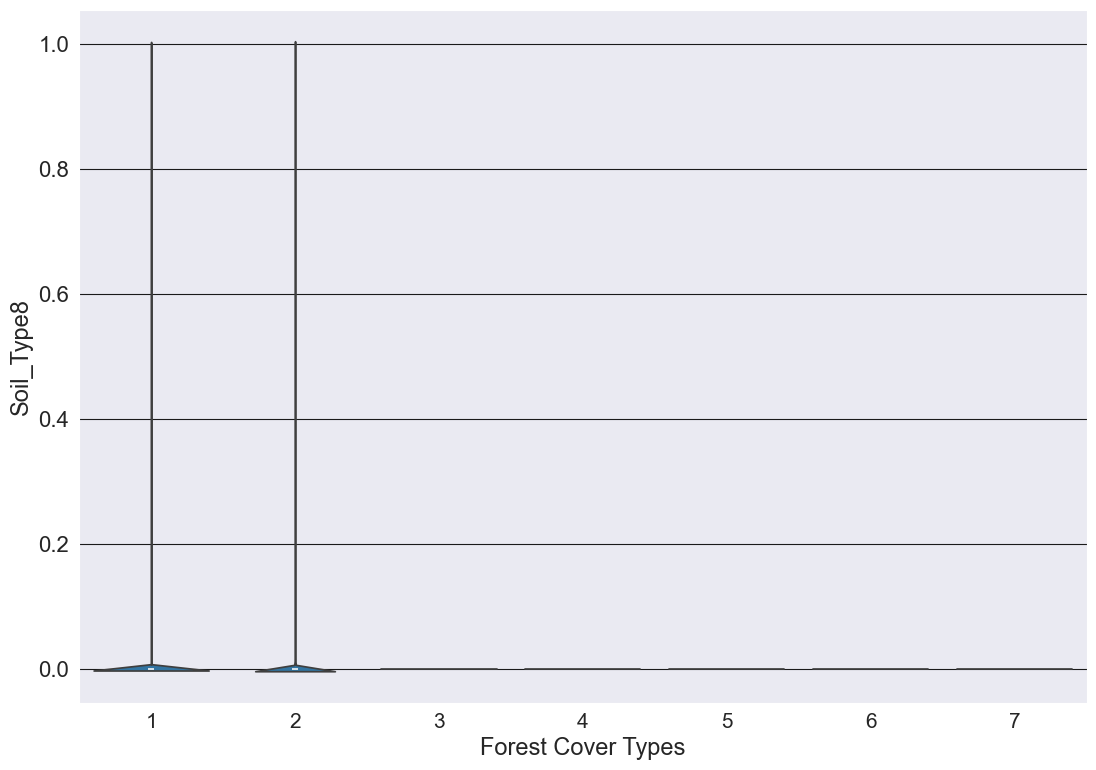

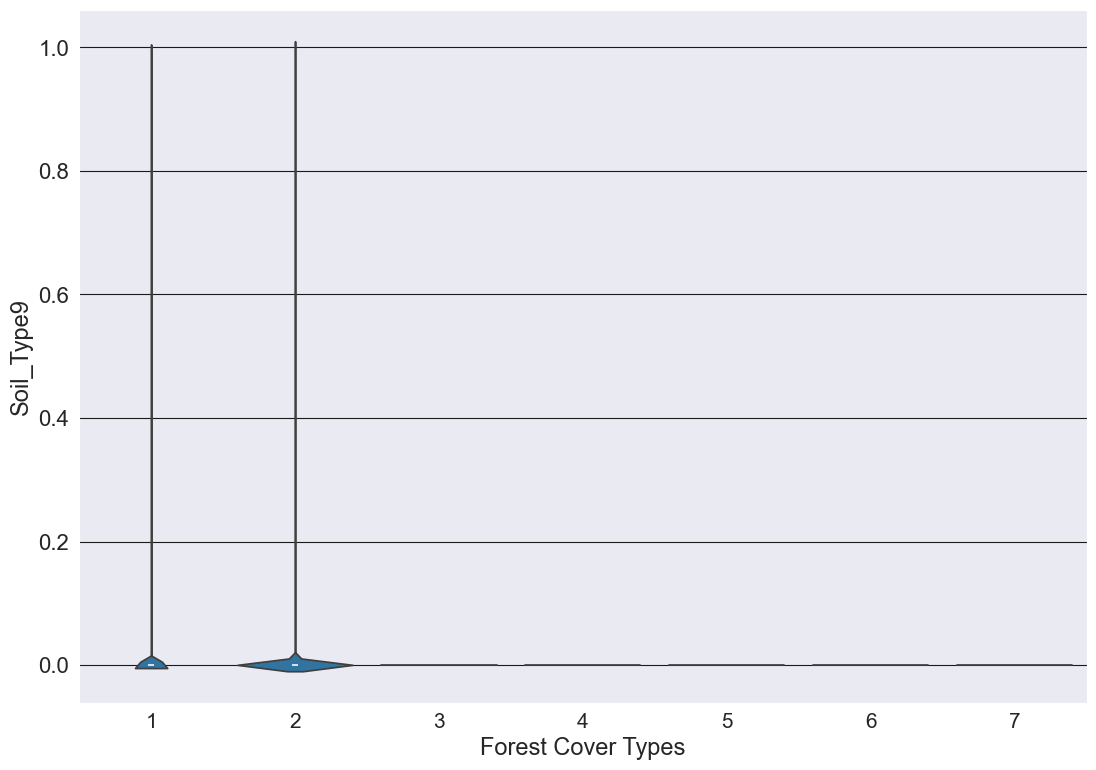

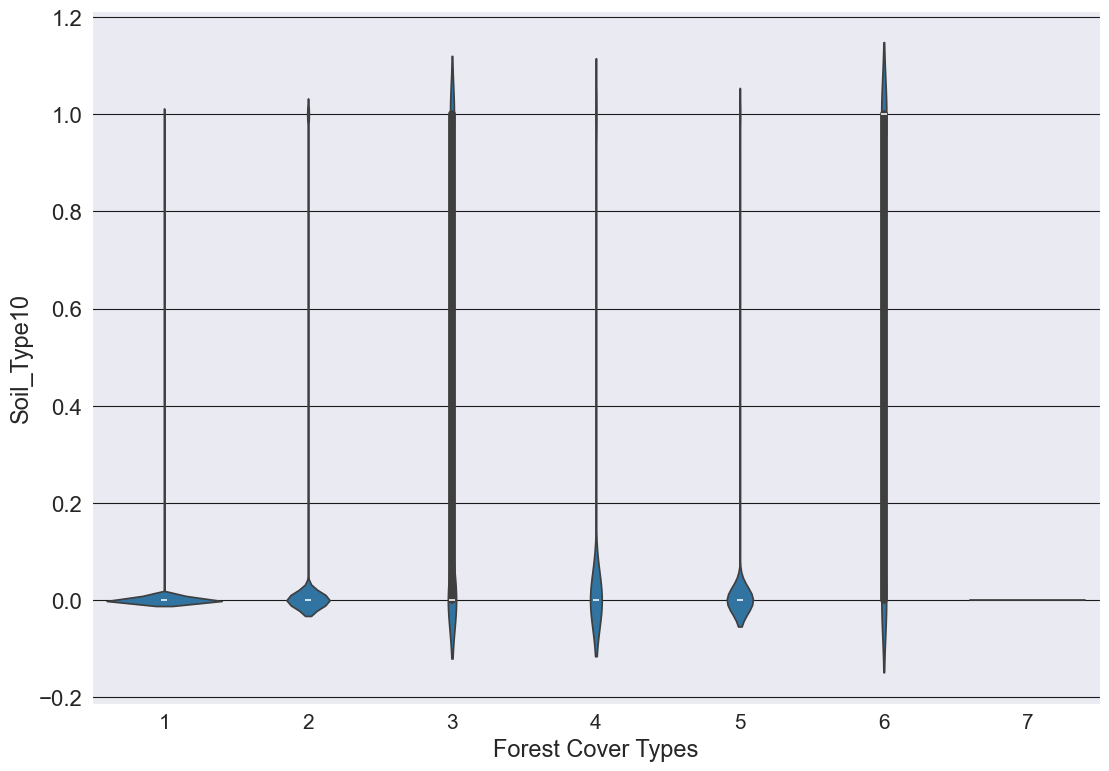

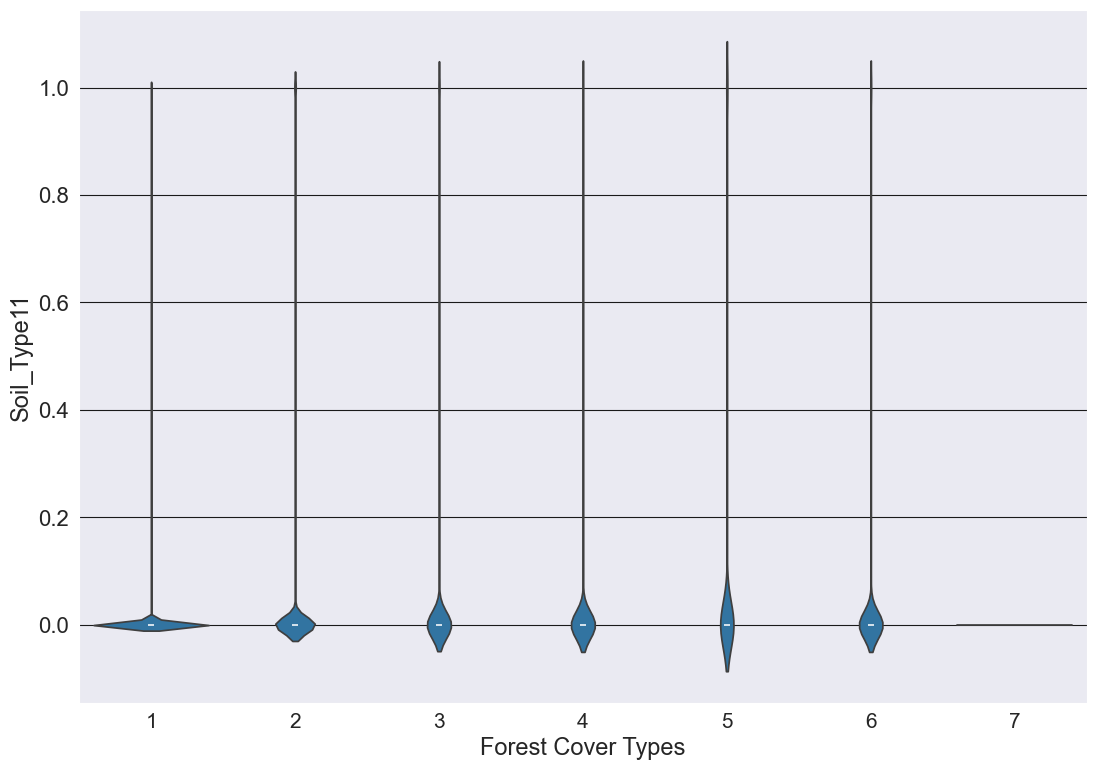

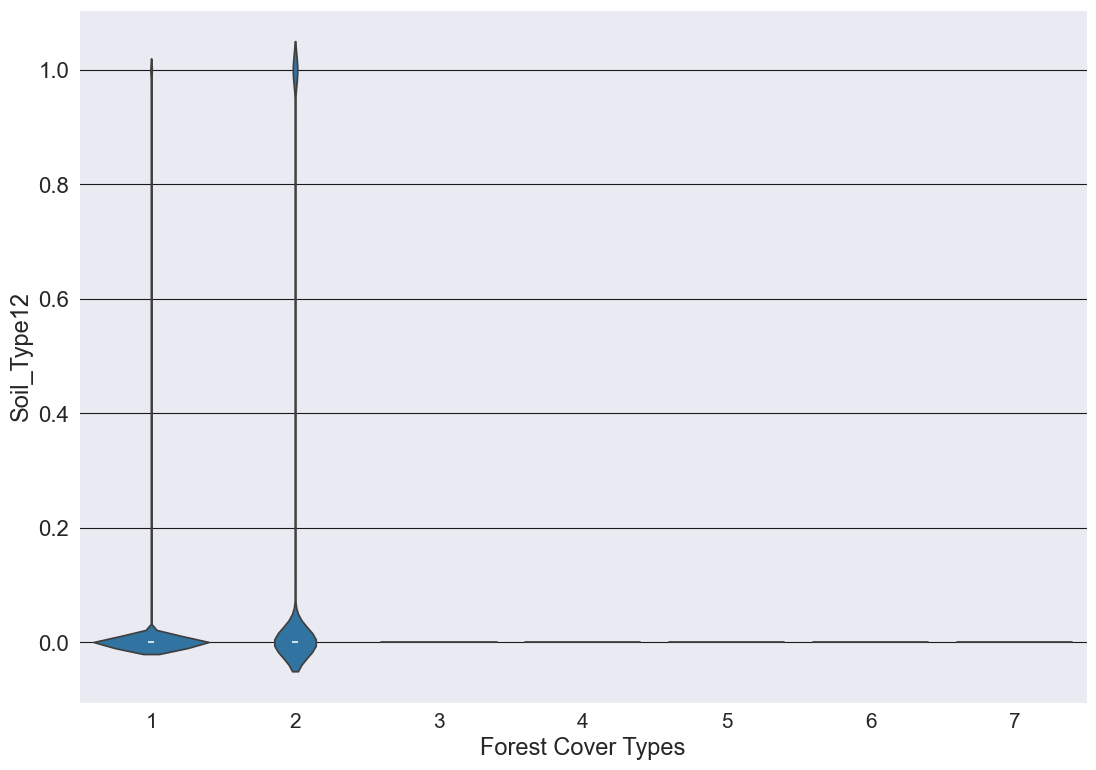

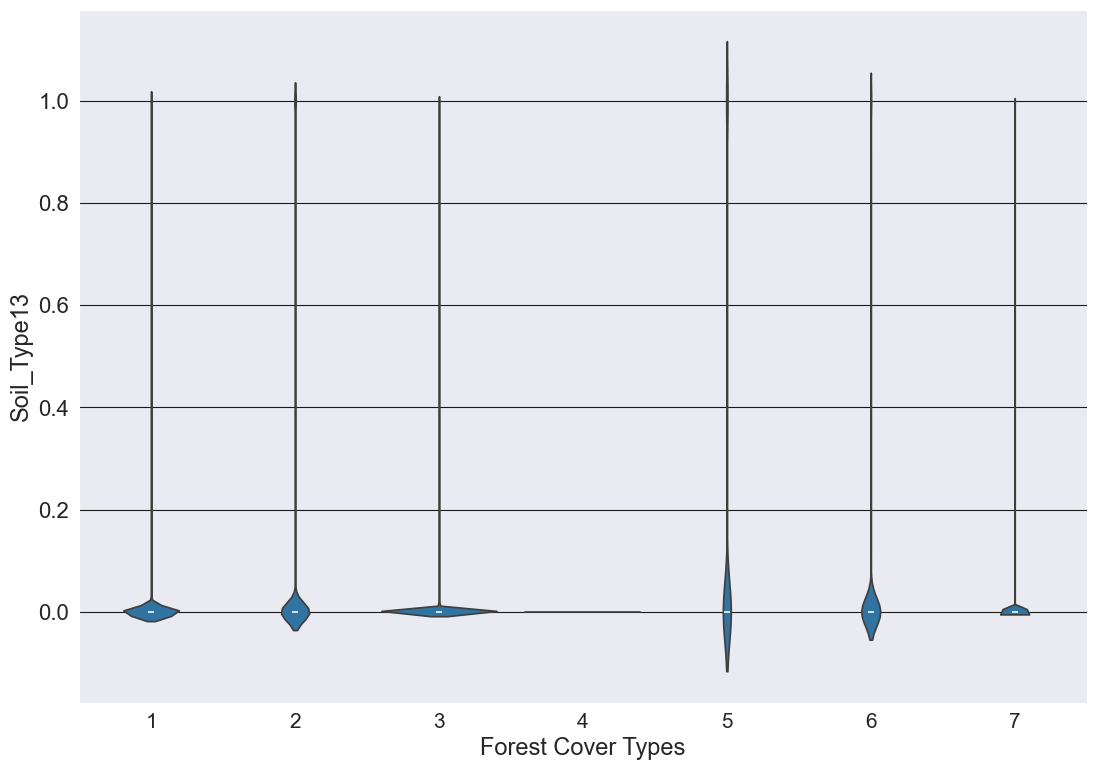

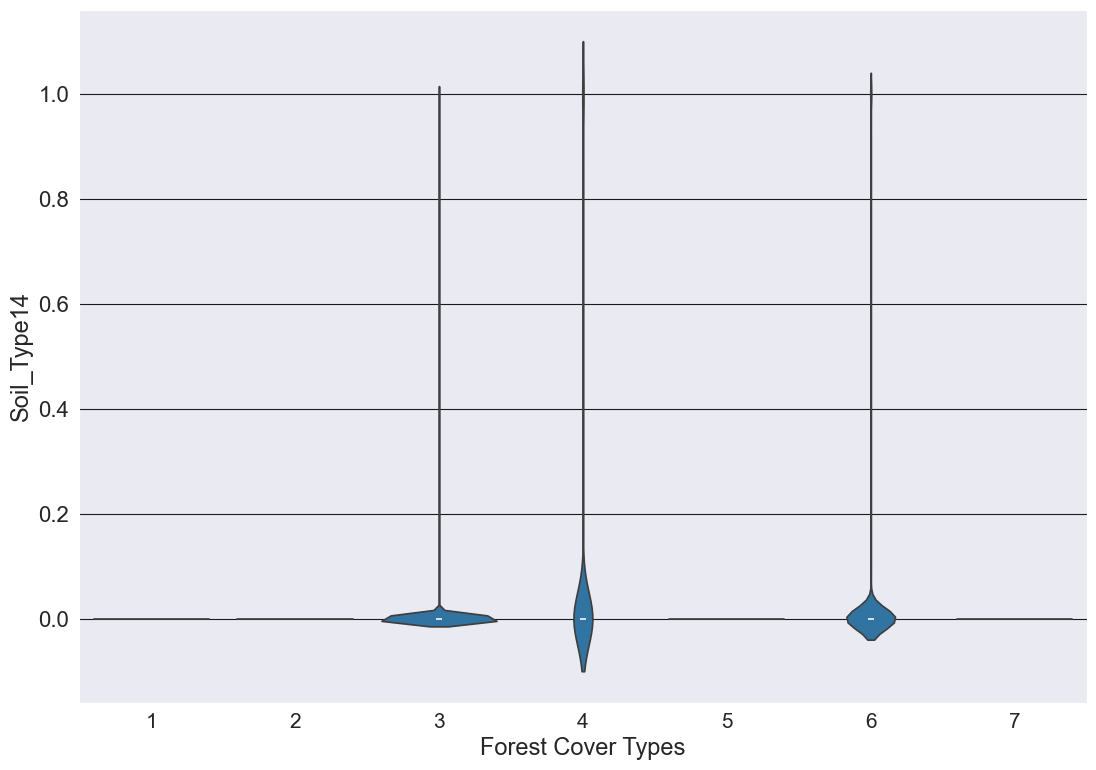

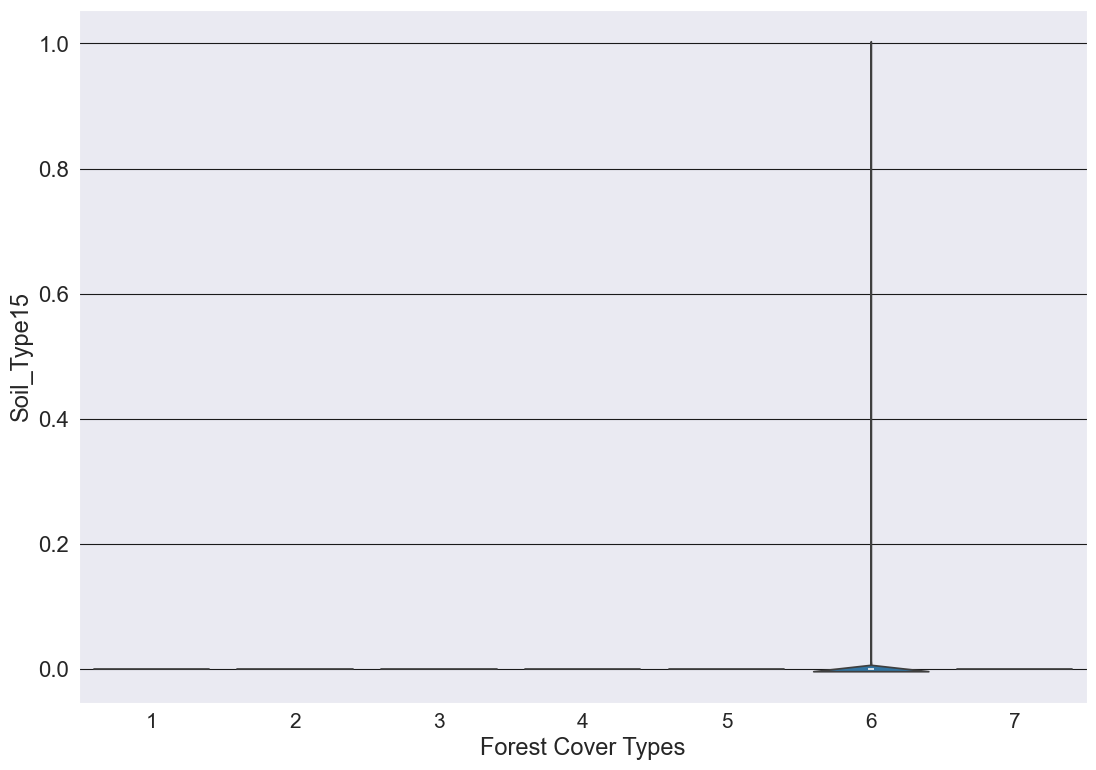

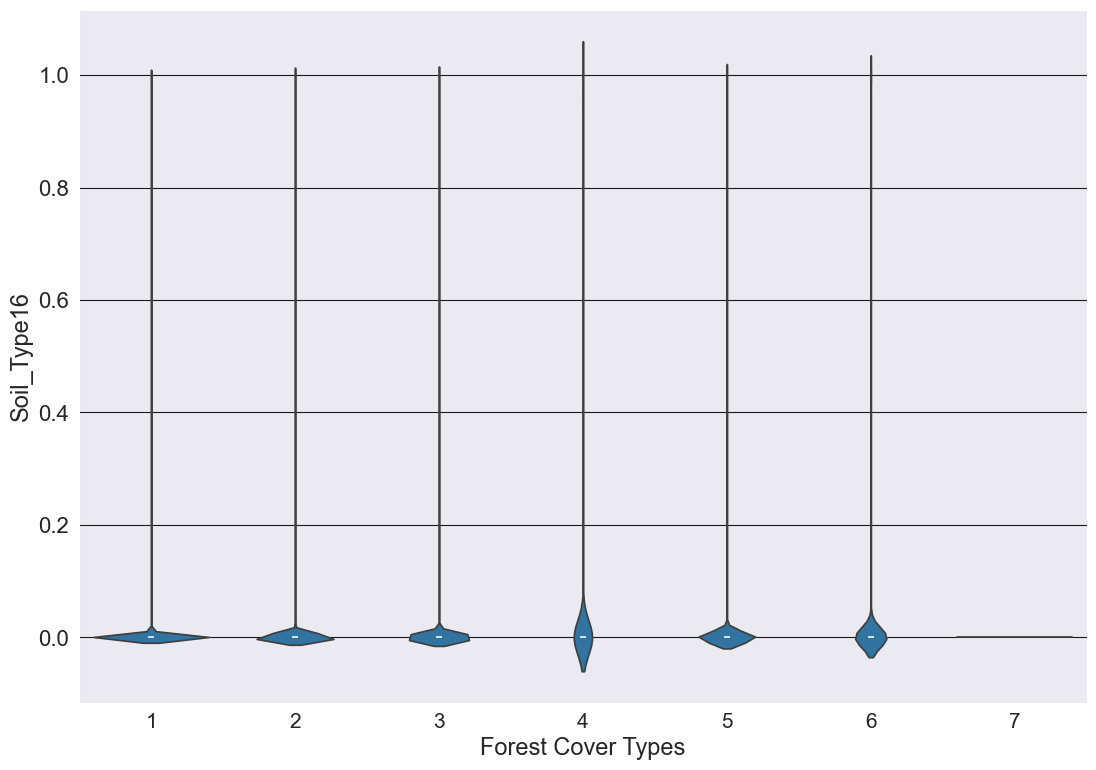

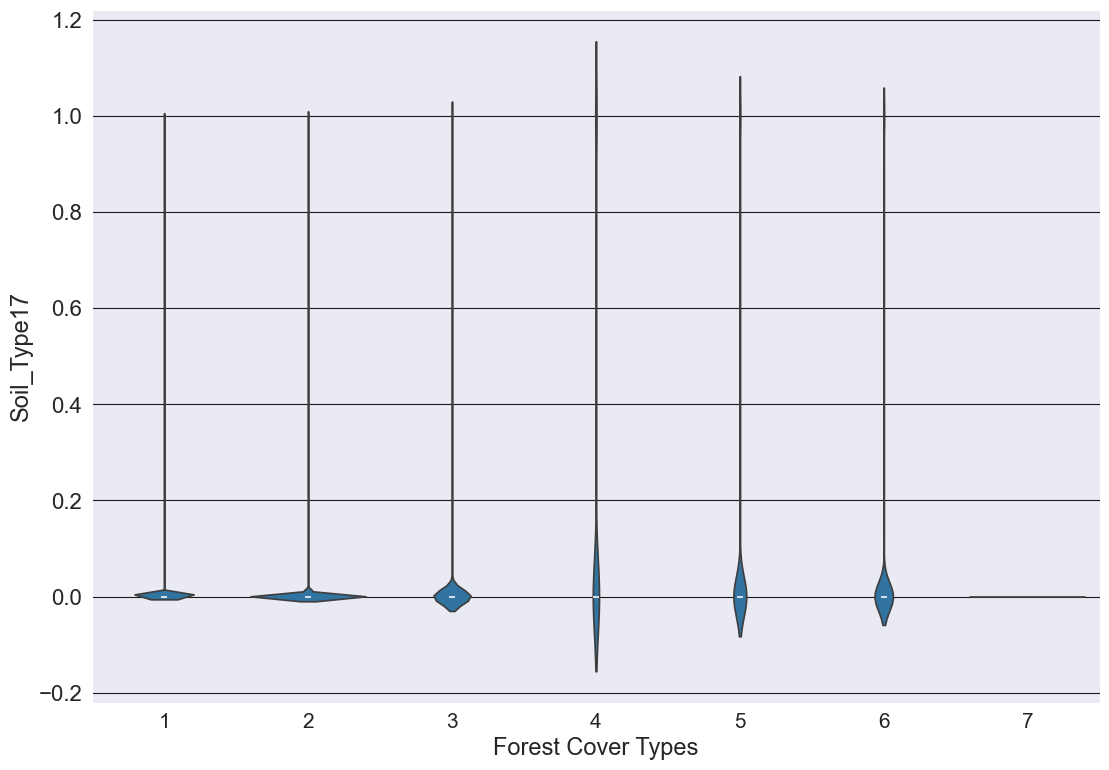

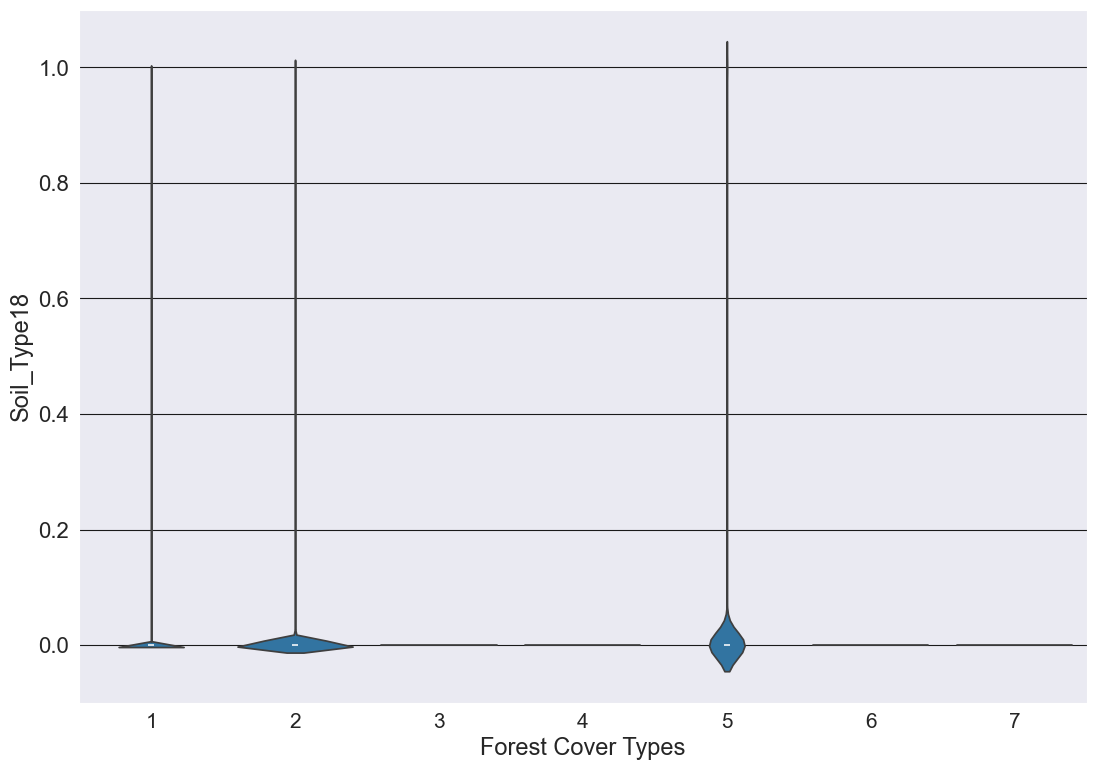

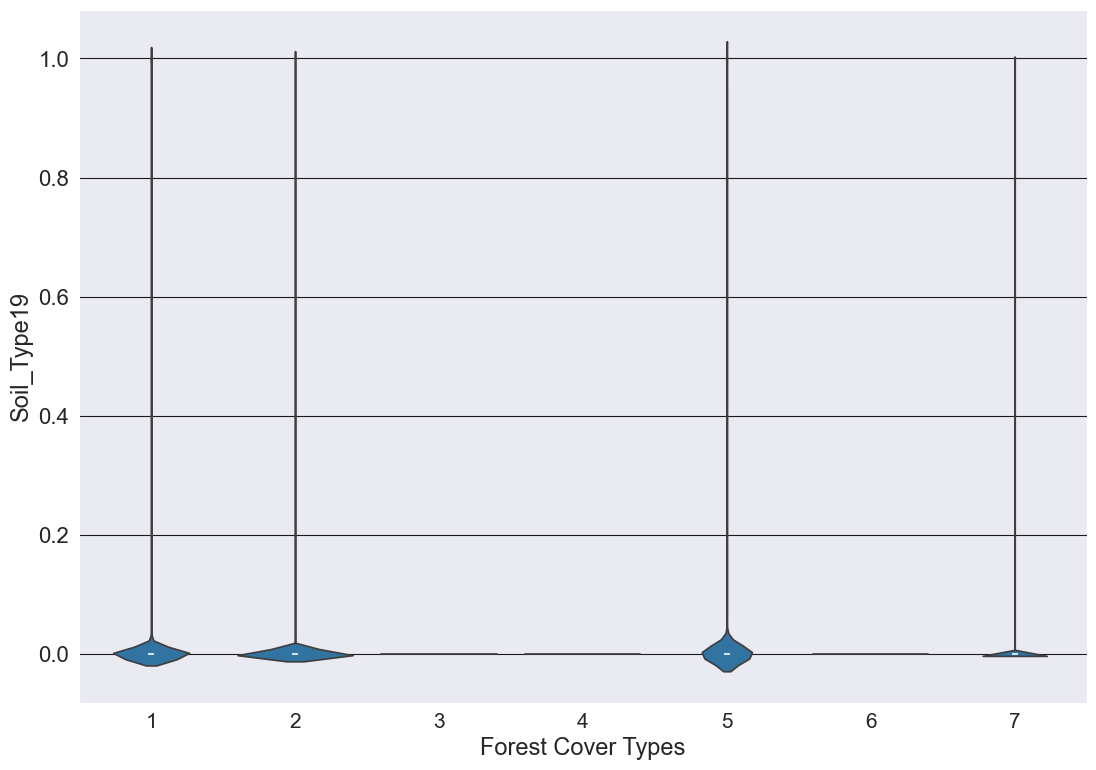

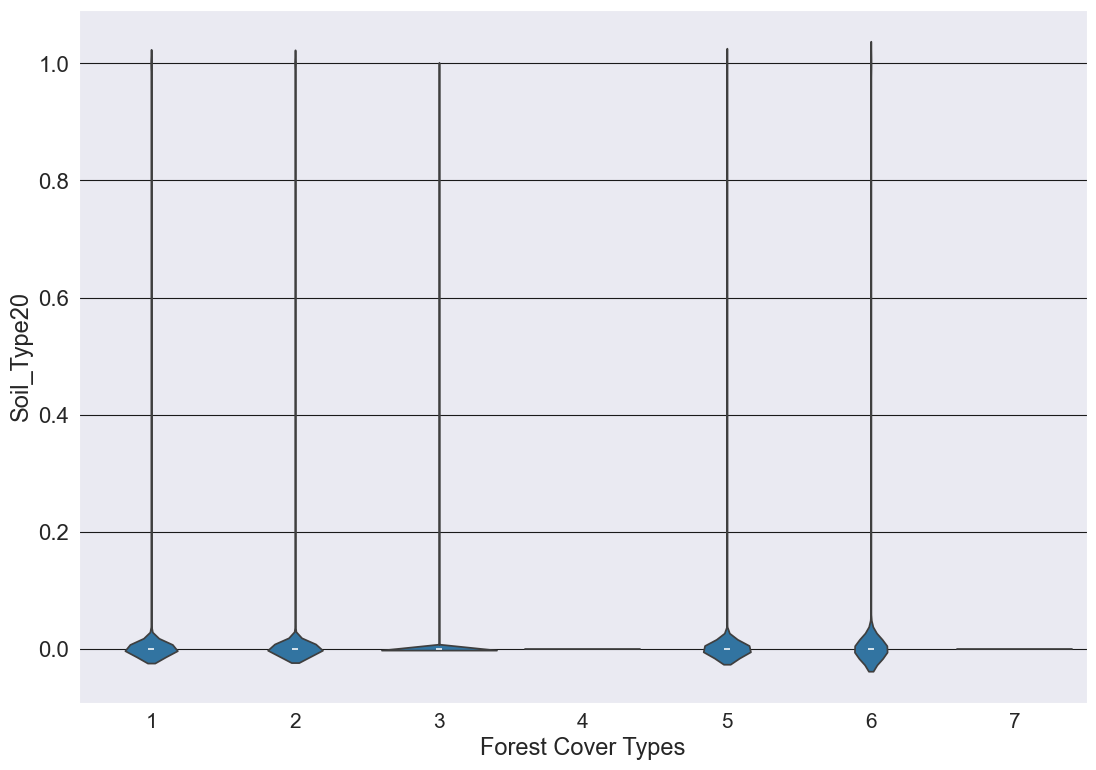

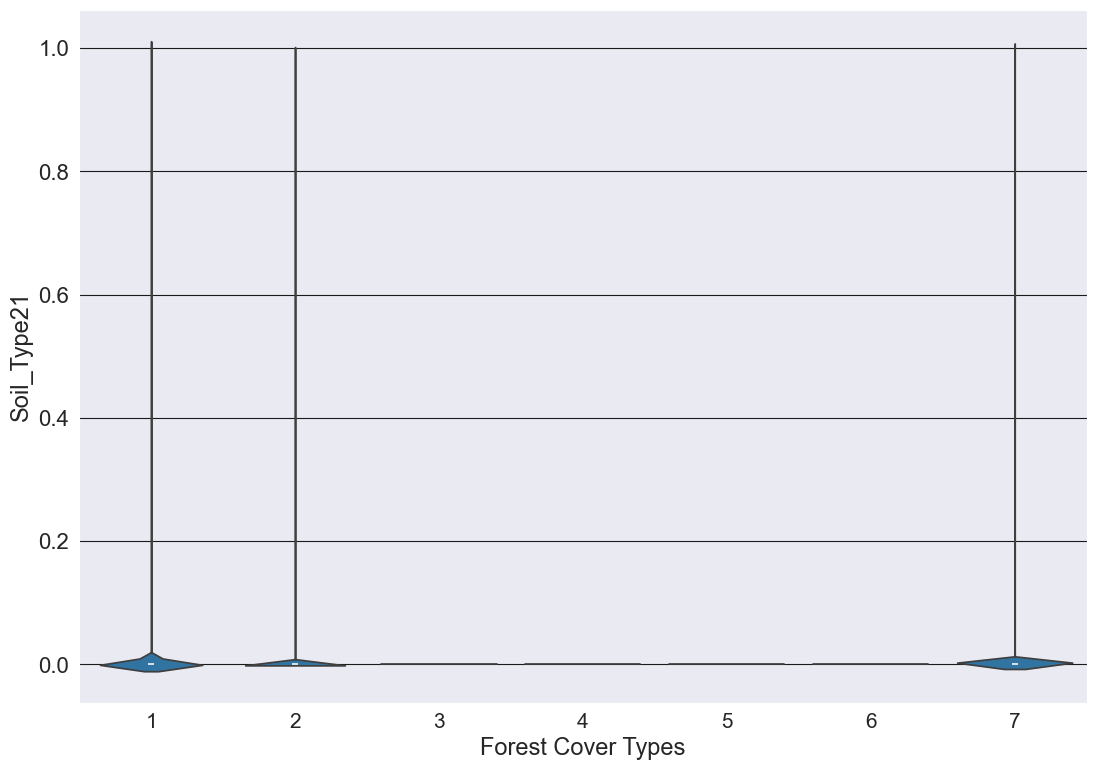

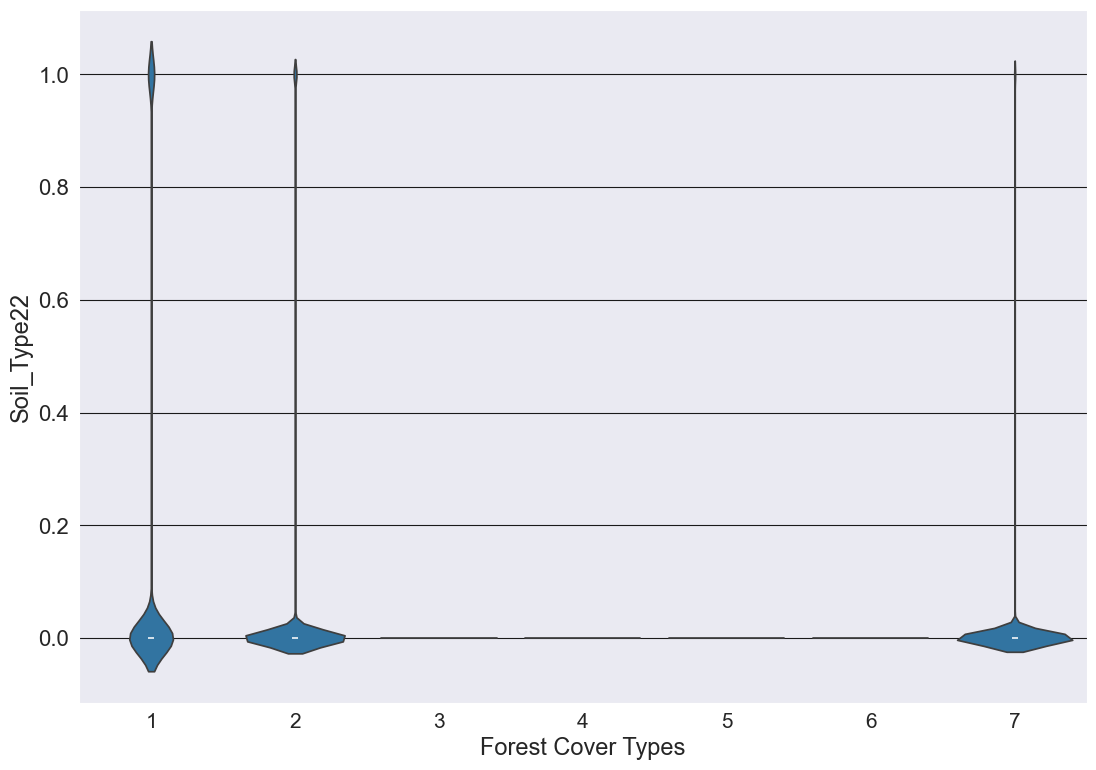

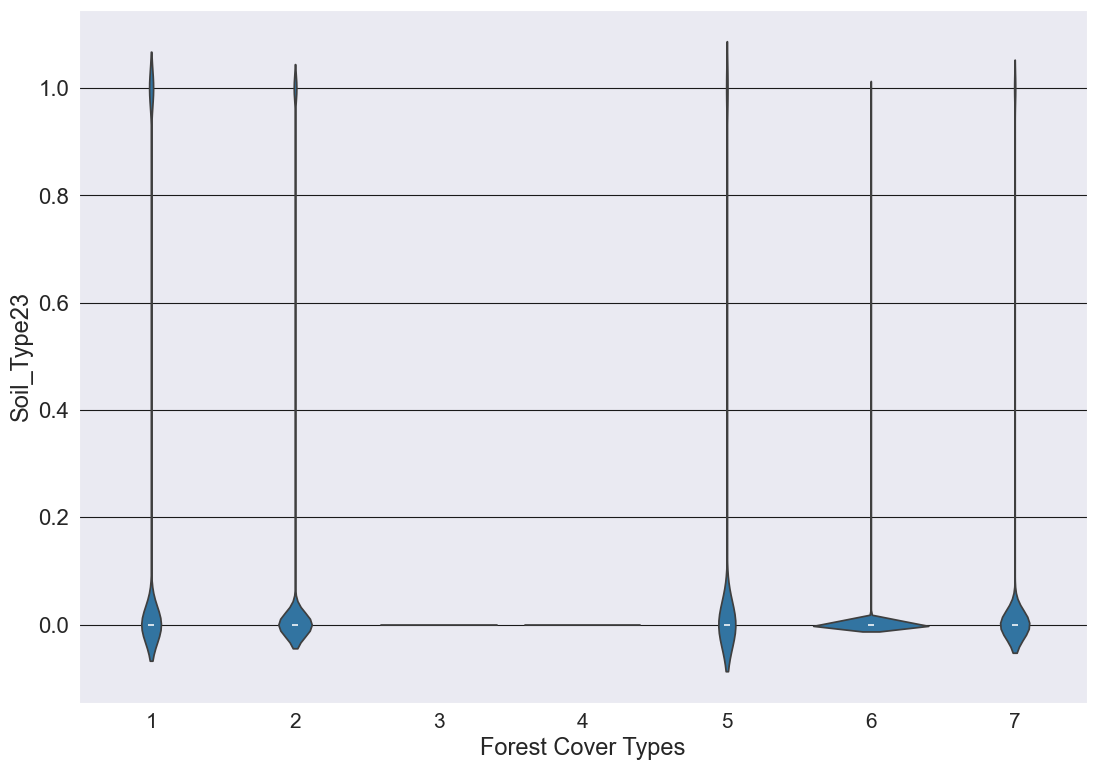

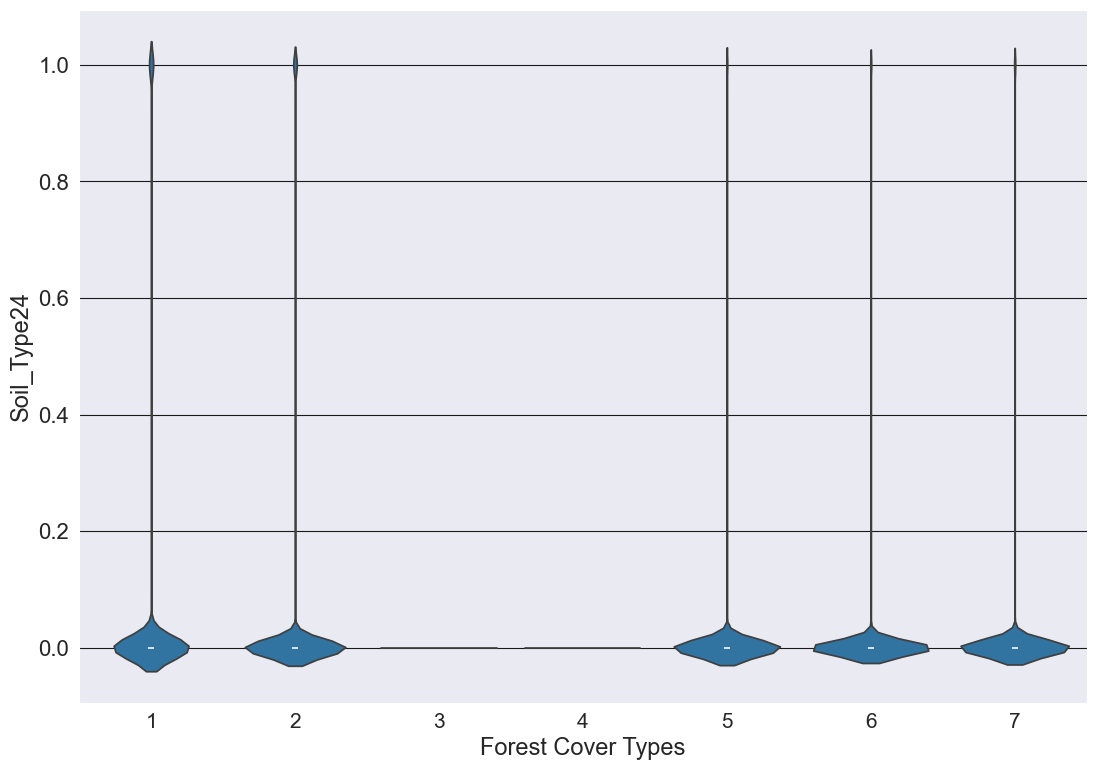

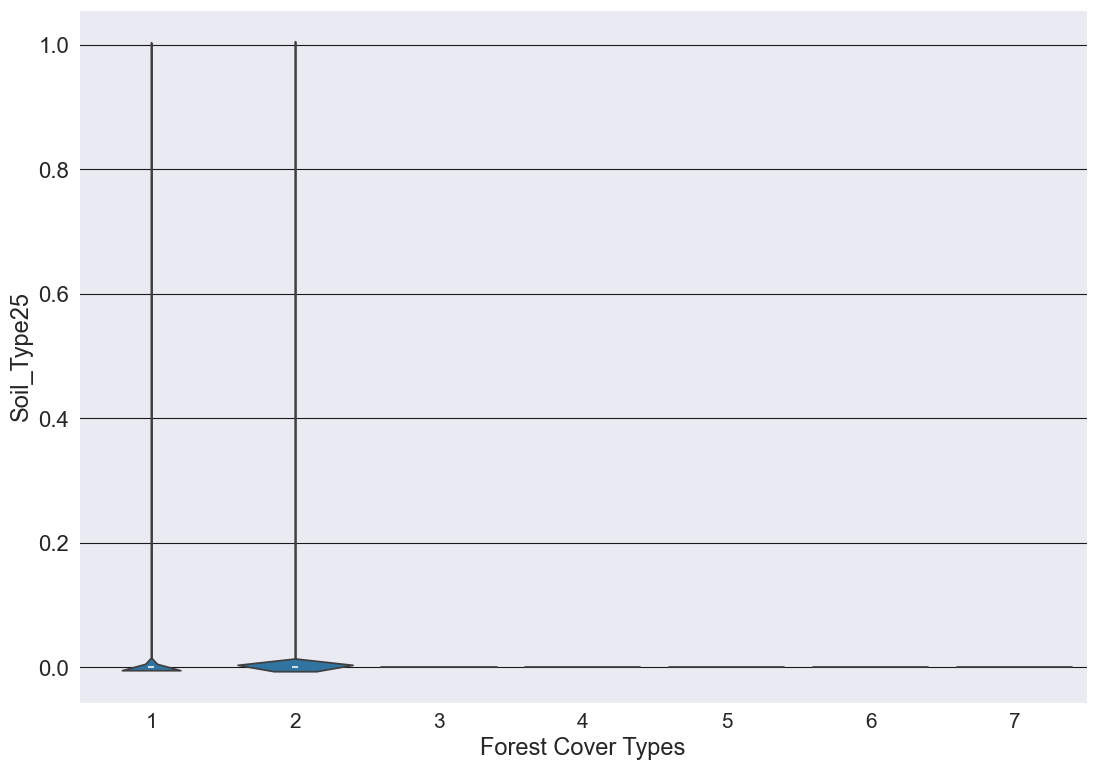

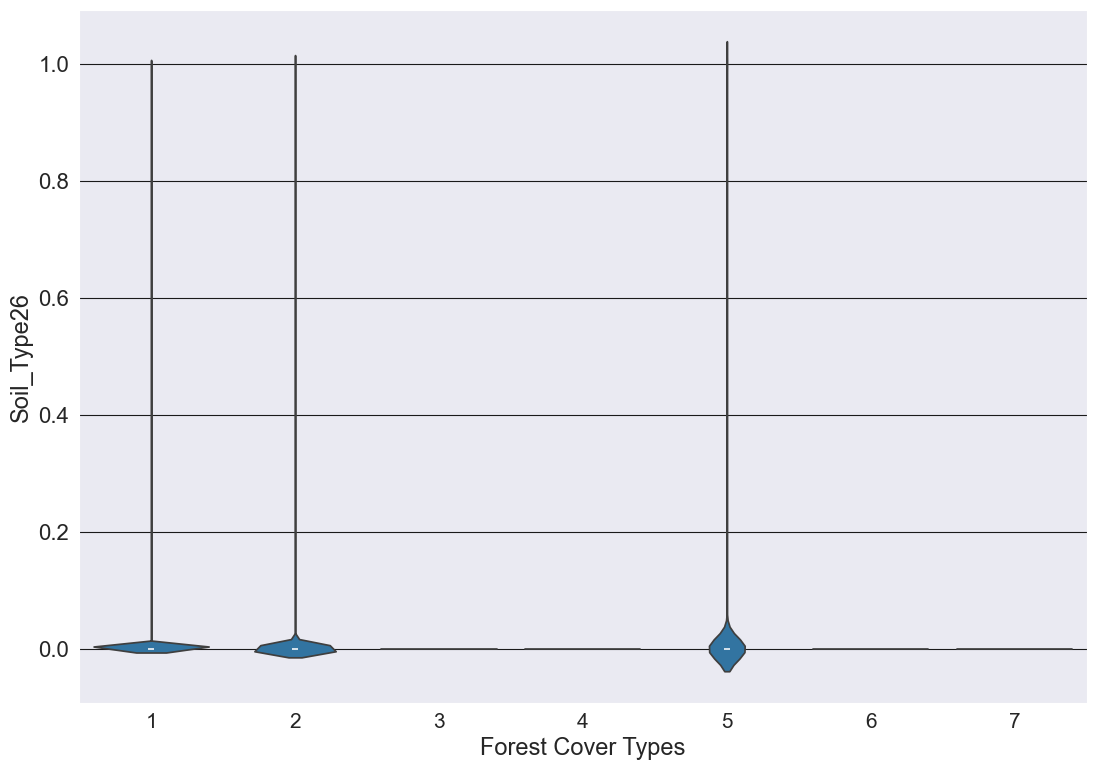

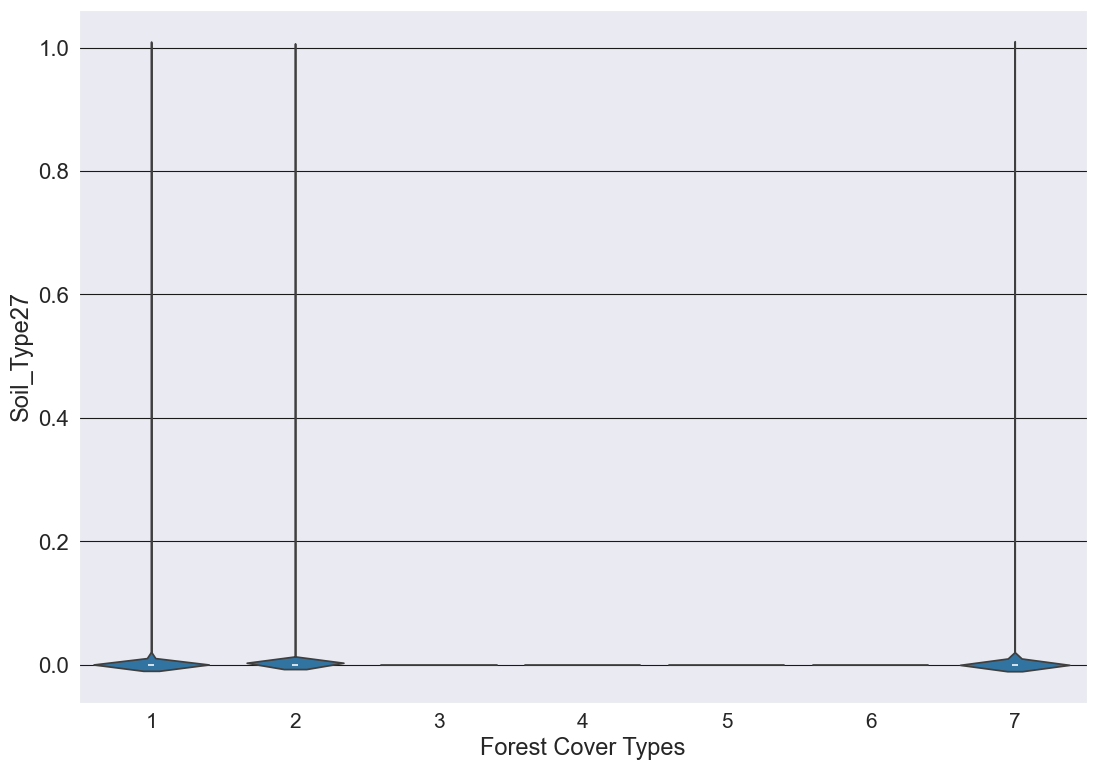

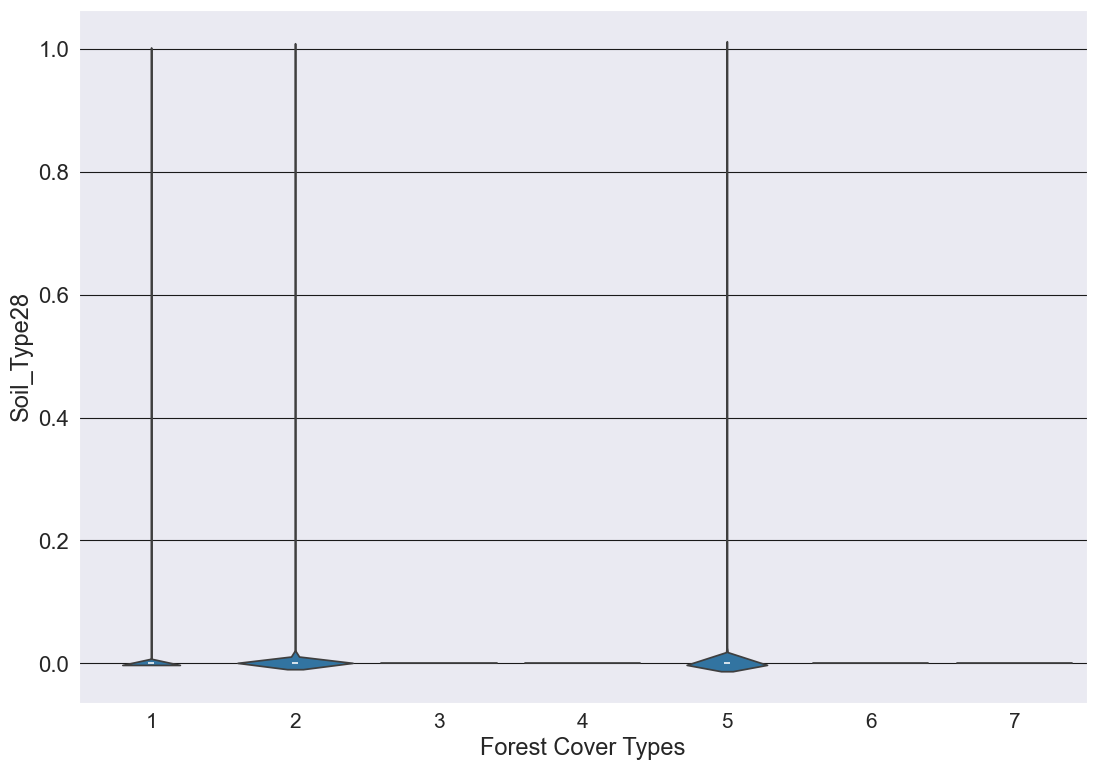

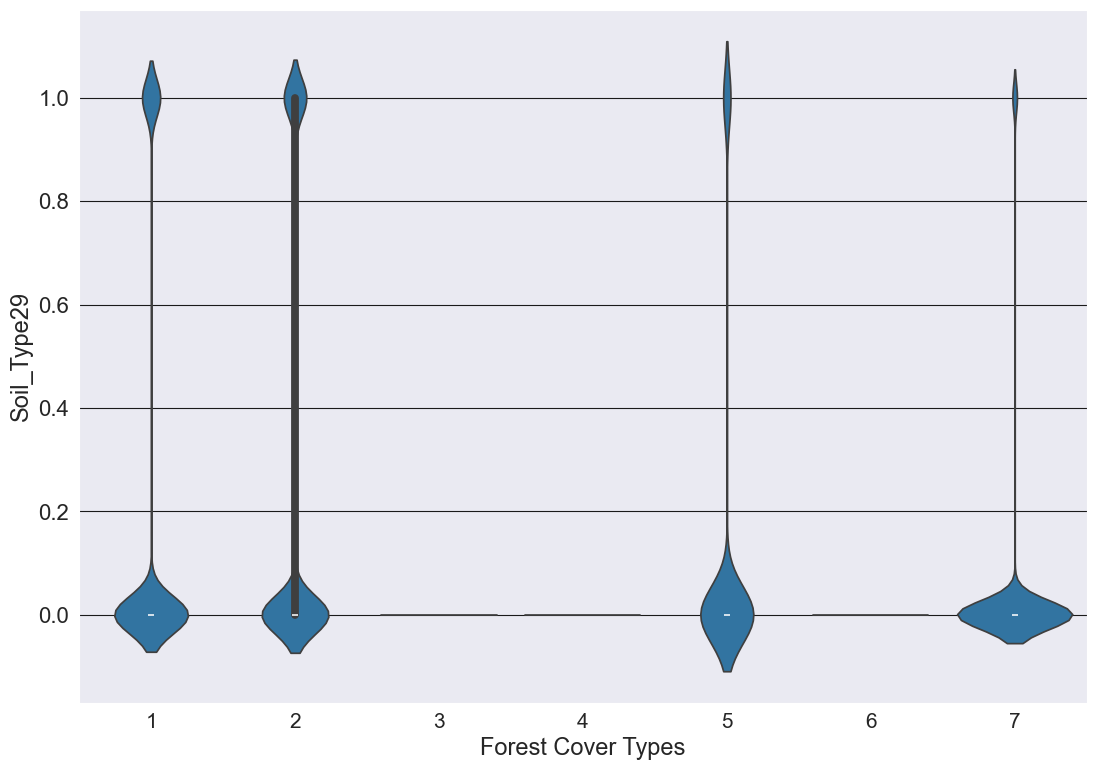

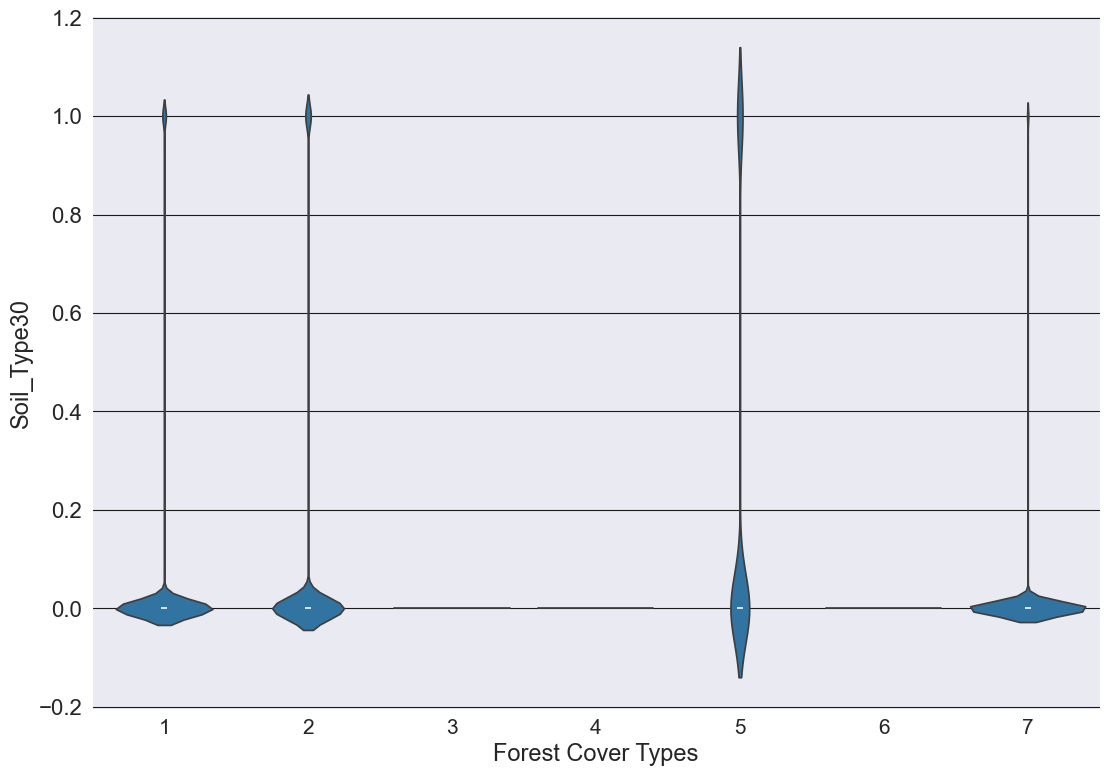

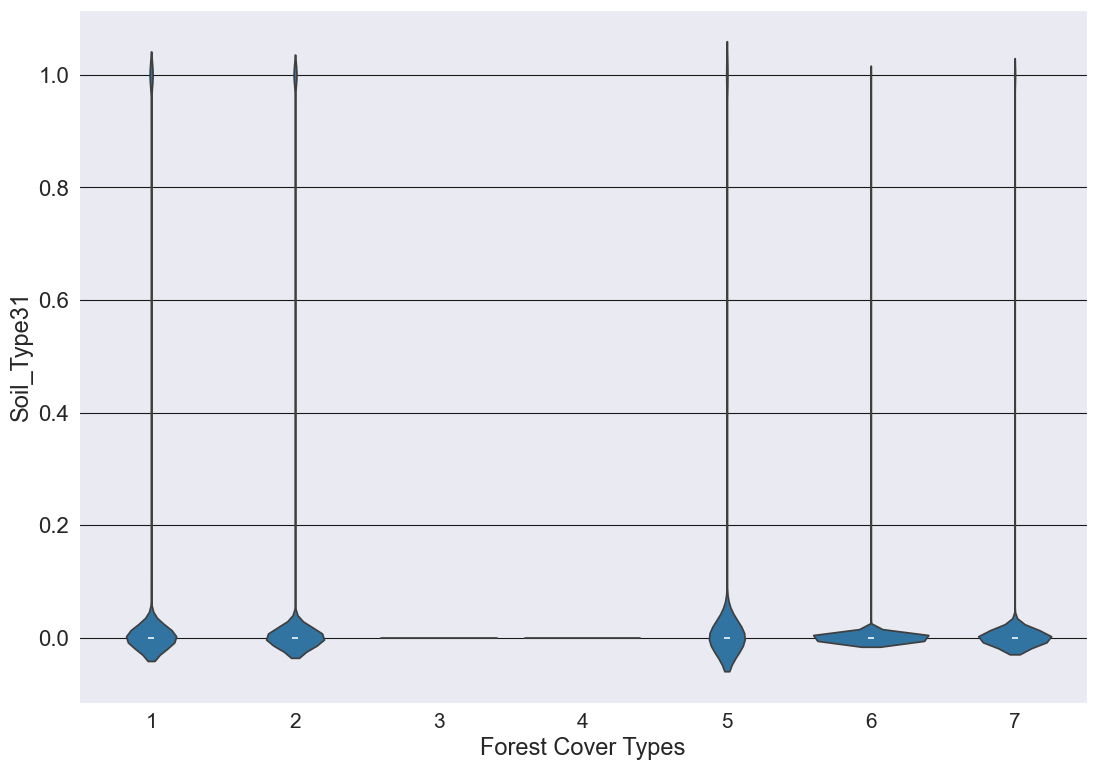

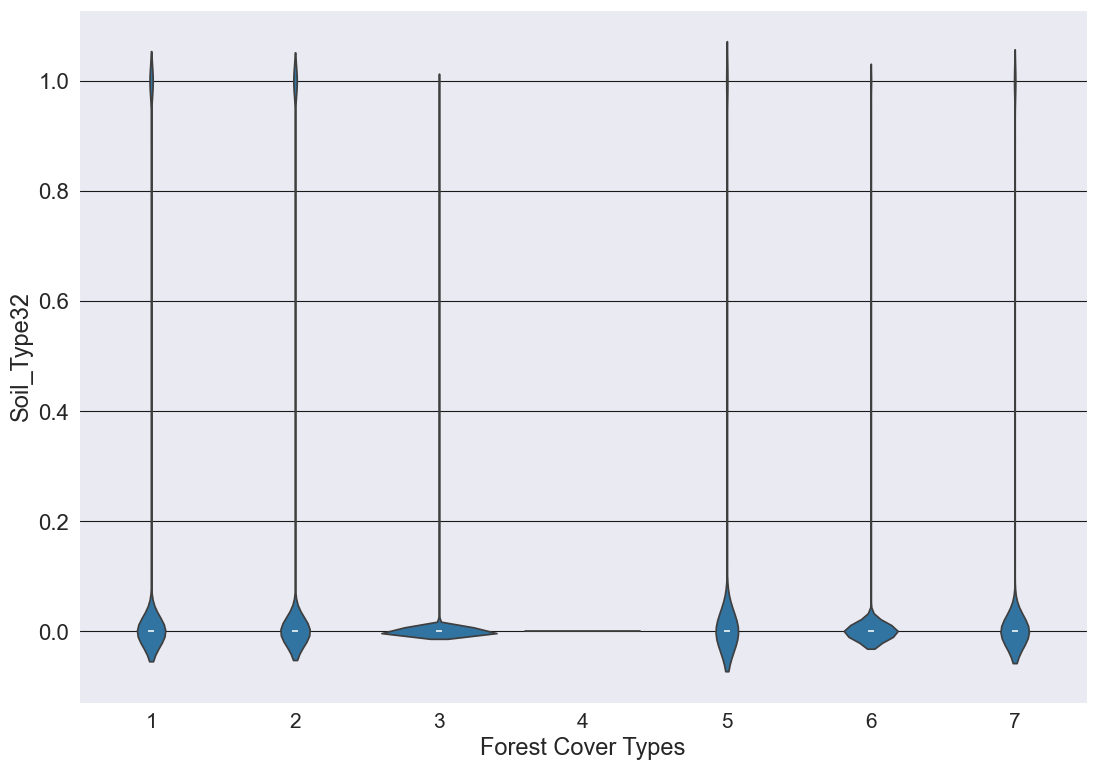

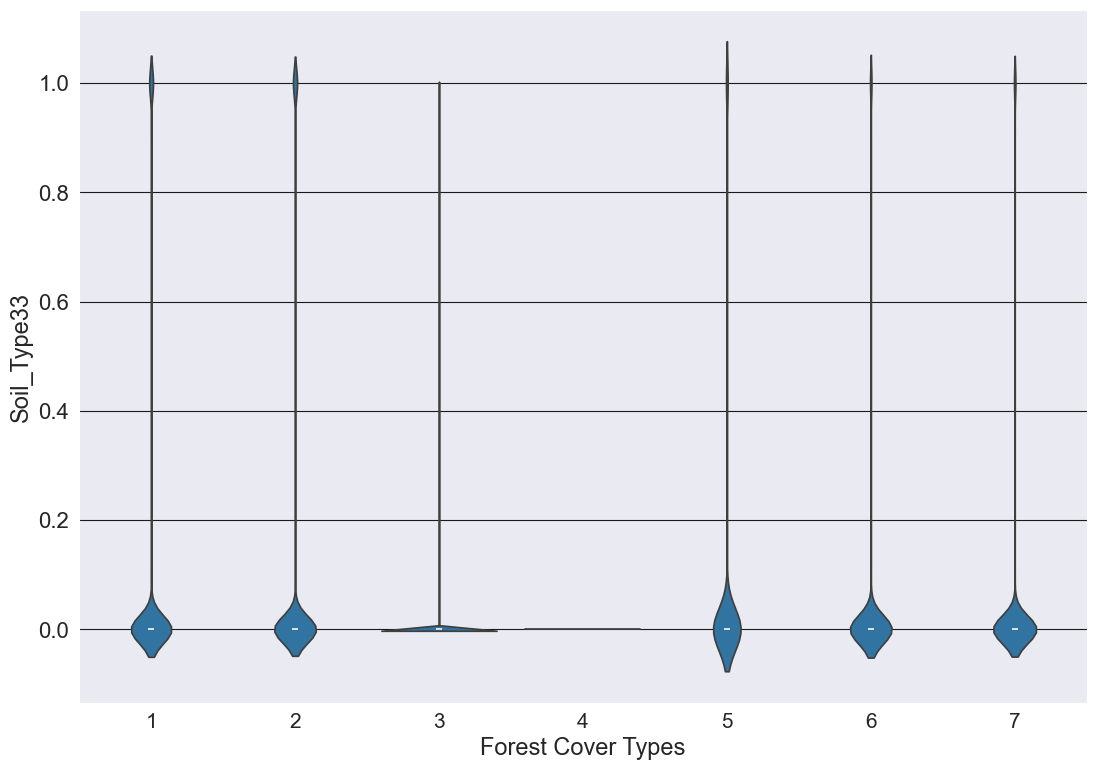

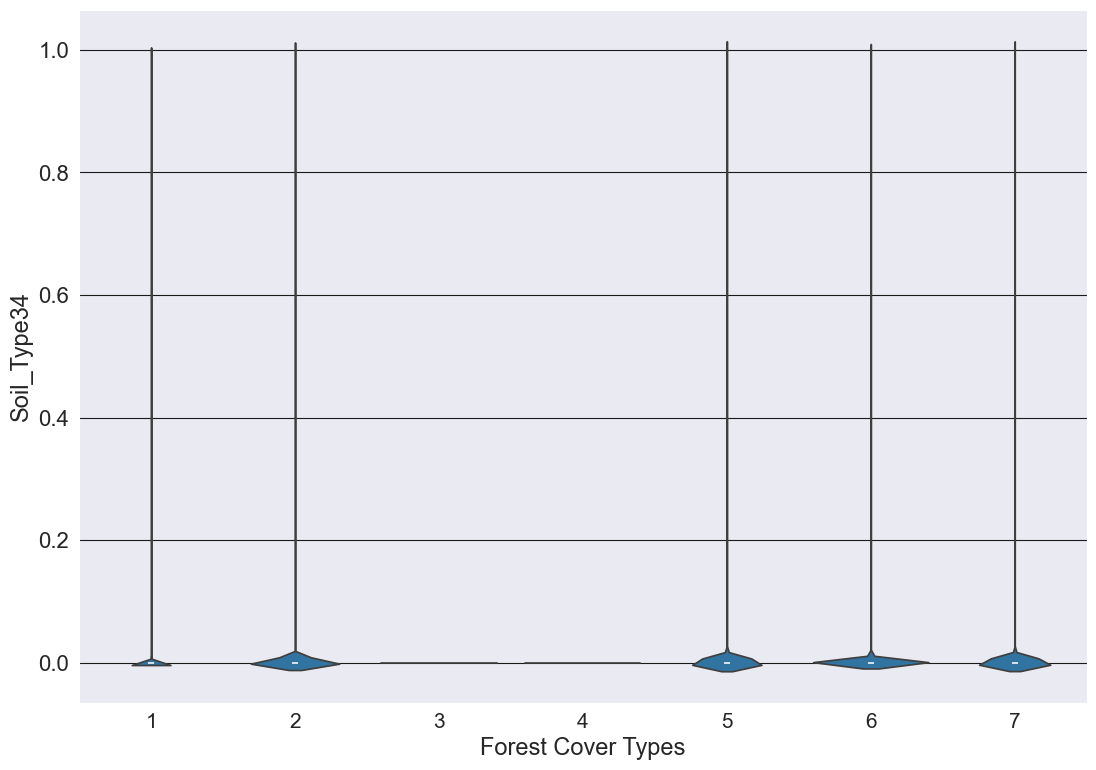

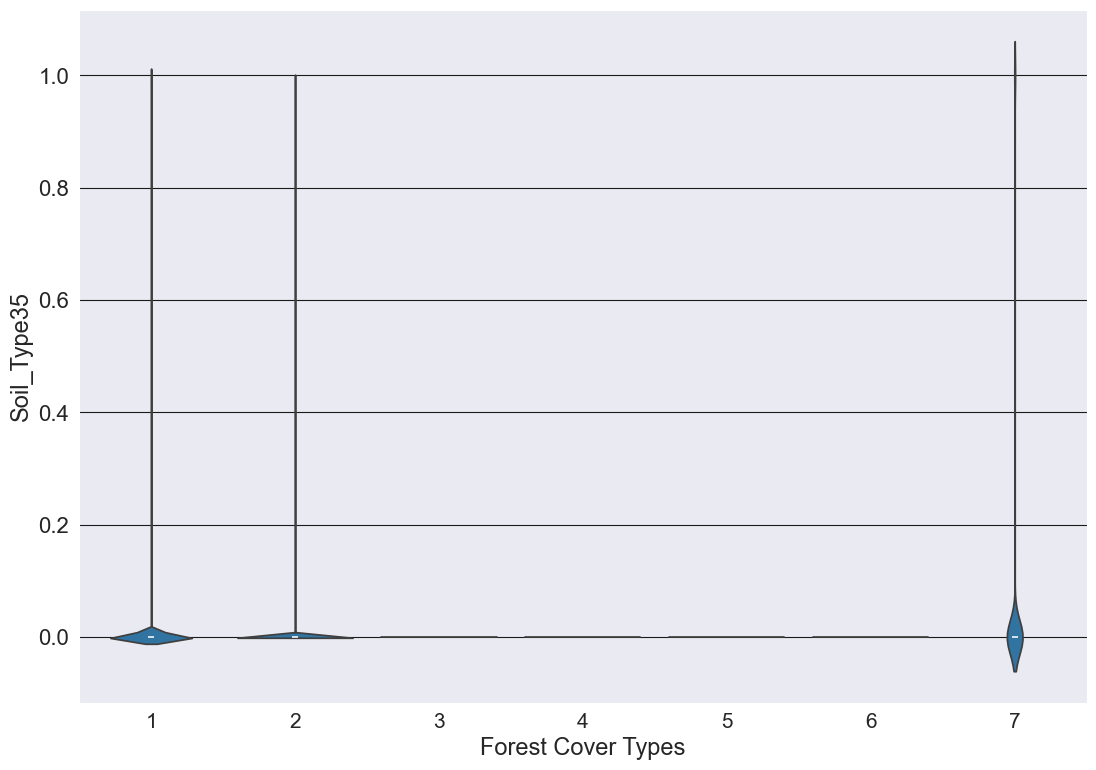

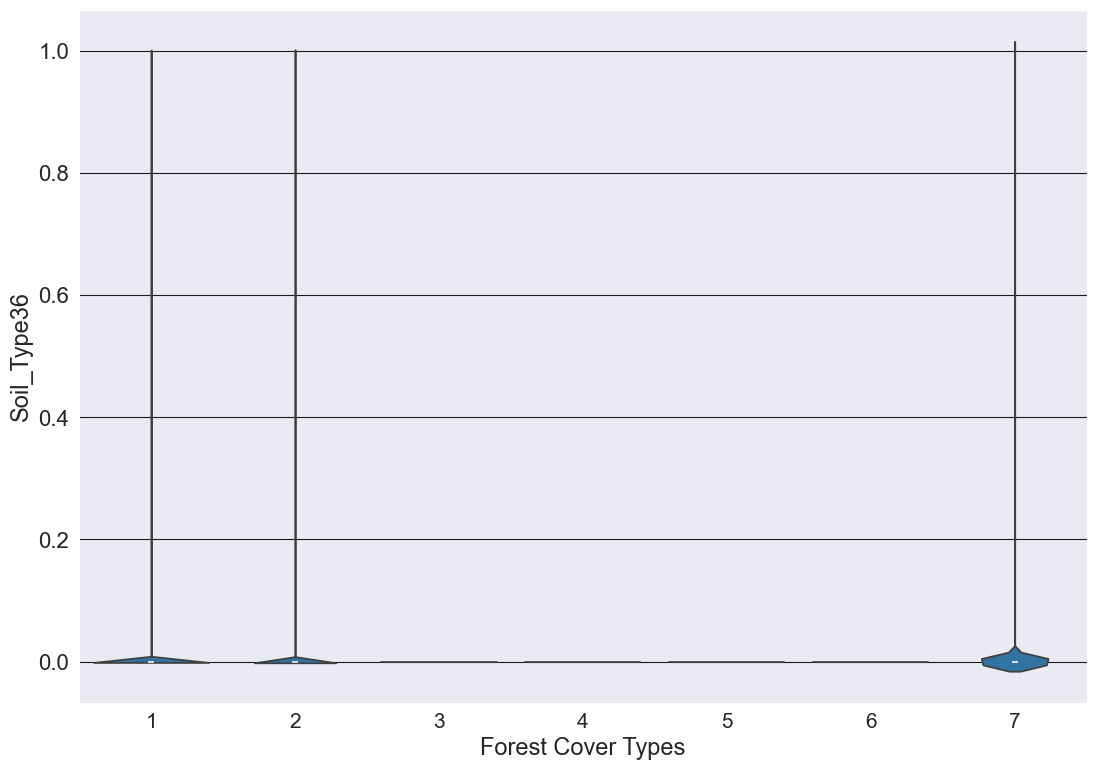

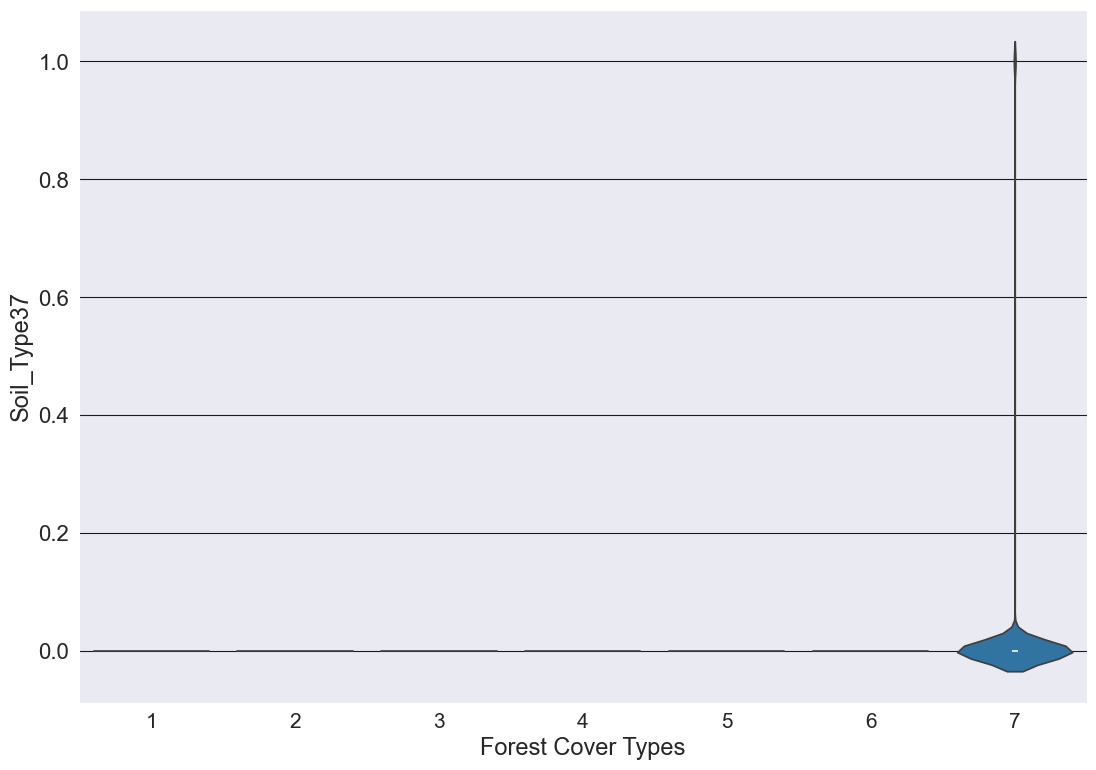

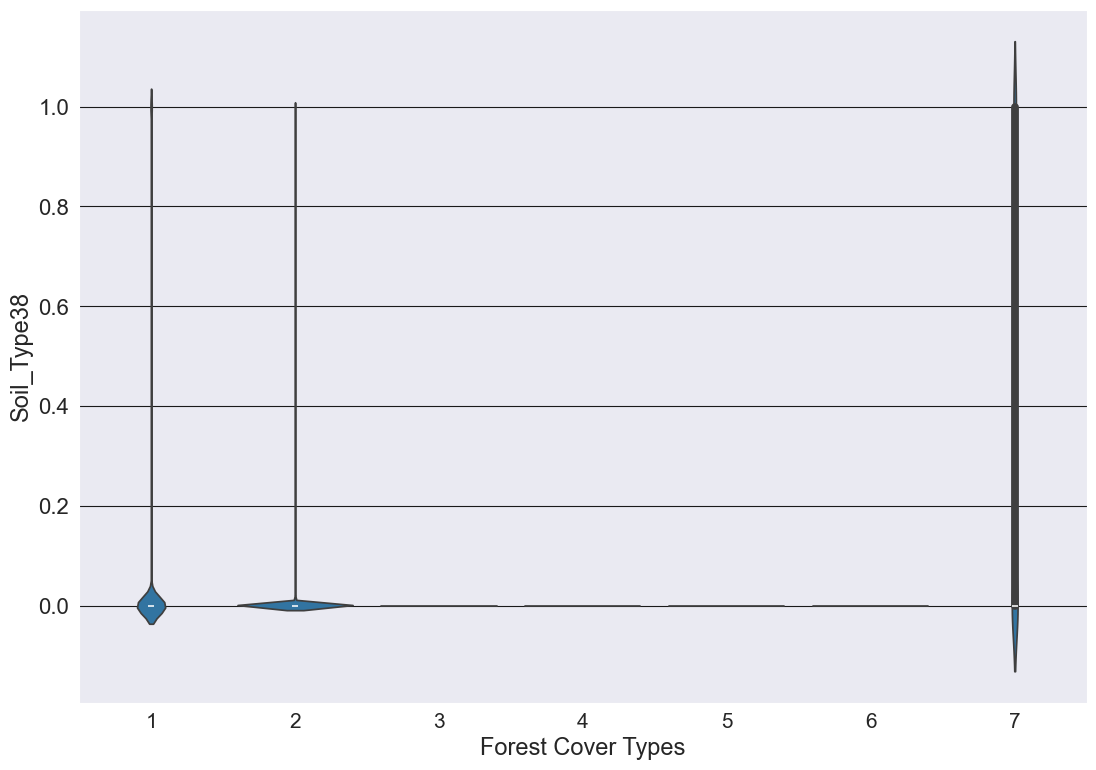

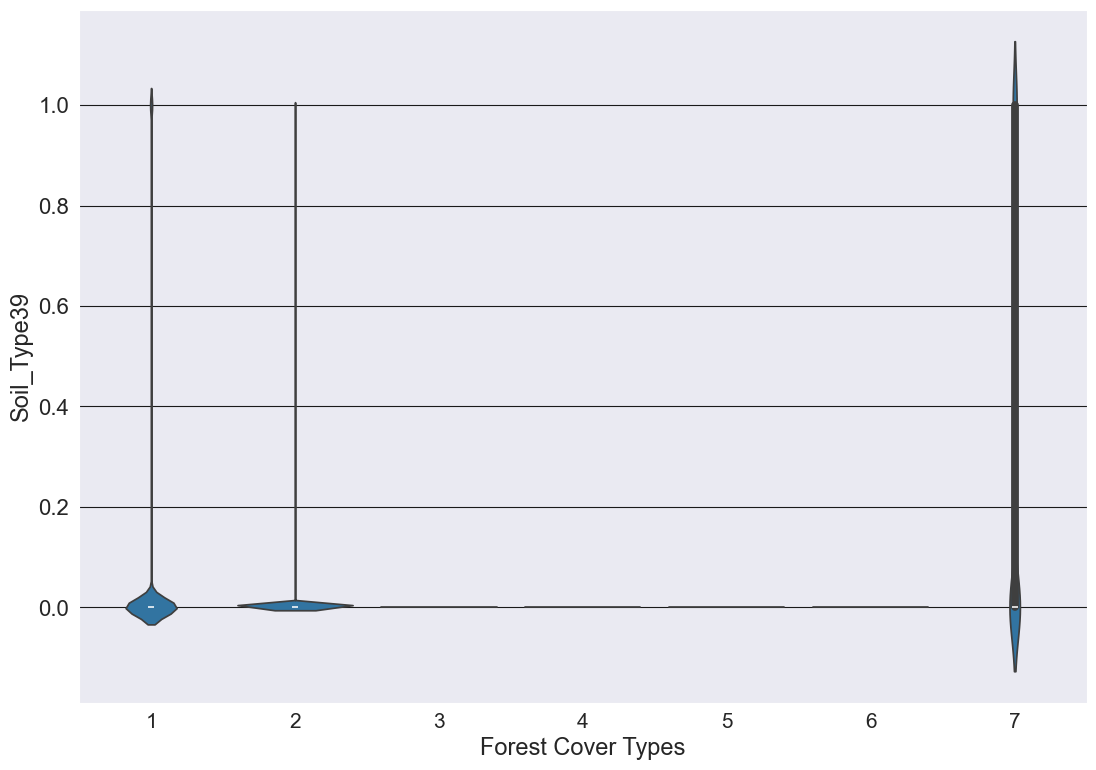

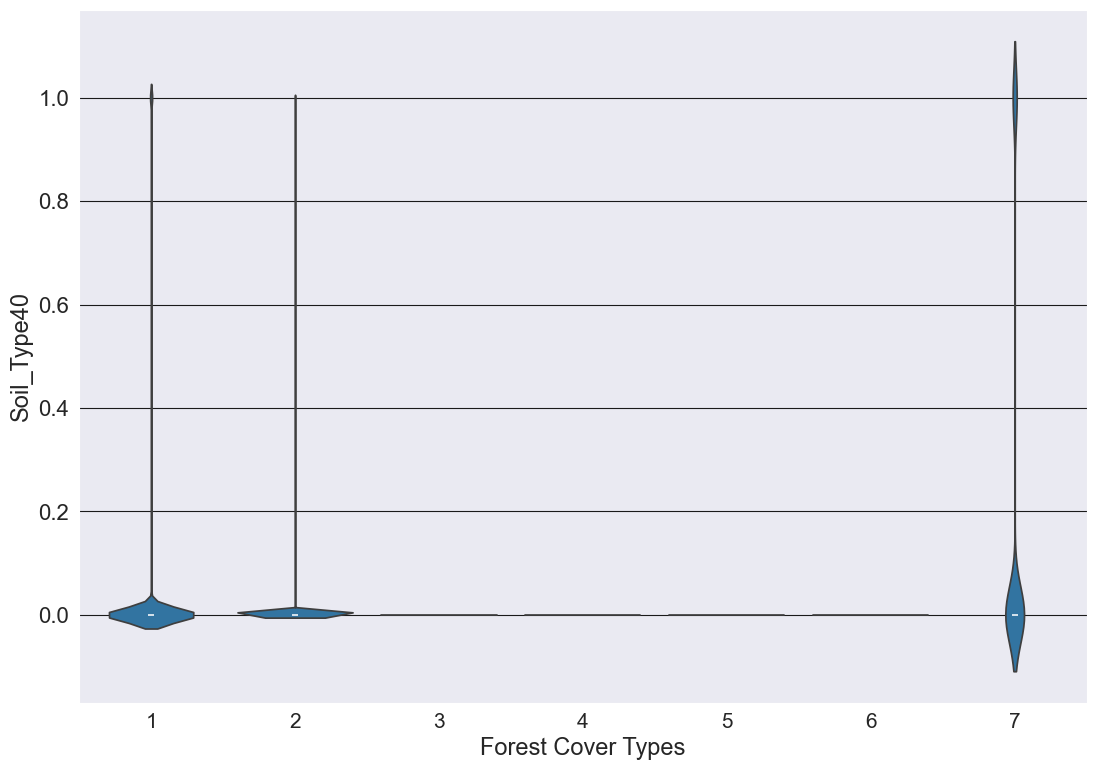

In [23]:
#######    4.3    ########
# Violin Plot (Box + Density)
# Comparing Soil features with target variable


# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})

# setting target variable
target = data['Cover_Type']
# features to be compared with target variable
features = Soil_data.columns


# loop for plotting Violin Plot for each features in the data
for i in range(0, len(features)):
    
    #figure size
    plt.subplots(figsize=(13, 9))
    
    # Plot violin for i feature for every class in target    
    sns.violinplot(data=Soil_data, x=target, y = features[i])
    
    # x-axis label size
    plt.xticks(size = 15)
    # y-axis label size
    plt.yticks(size = 16)

    # Horizontal axis Label
    plt.xlabel('Forest Cover Types', size = 17)
    # Vertical axis Label
    plt.ylabel(features[i], size = 17)
  
    # display plot
    plt.show()

* `Soil Type 4` est le seul type de sol présent dans toutes les classes de types de couvert forestier.

* `Soil Type 7, 15 et 37` appartiennent respectivement aux classes forestières 2, 6 et 7. Bien qu’ils aient le moins d'observations, ils fournissent des informations précieuses sur ces classes, même si d'autres caractéristiques pourraient être plus importantes.

* `Forest Cover Type 4` a une présence moindre pour les types de sol ayant le moins d'observations.

#### Feature Correlation

**Now Let us see how much each features are correlated with each other...**

Since part of our data is binary, we will exclude binary data from our dataset and only find correlation matrix of numerical data becuase correlation requires continous data.

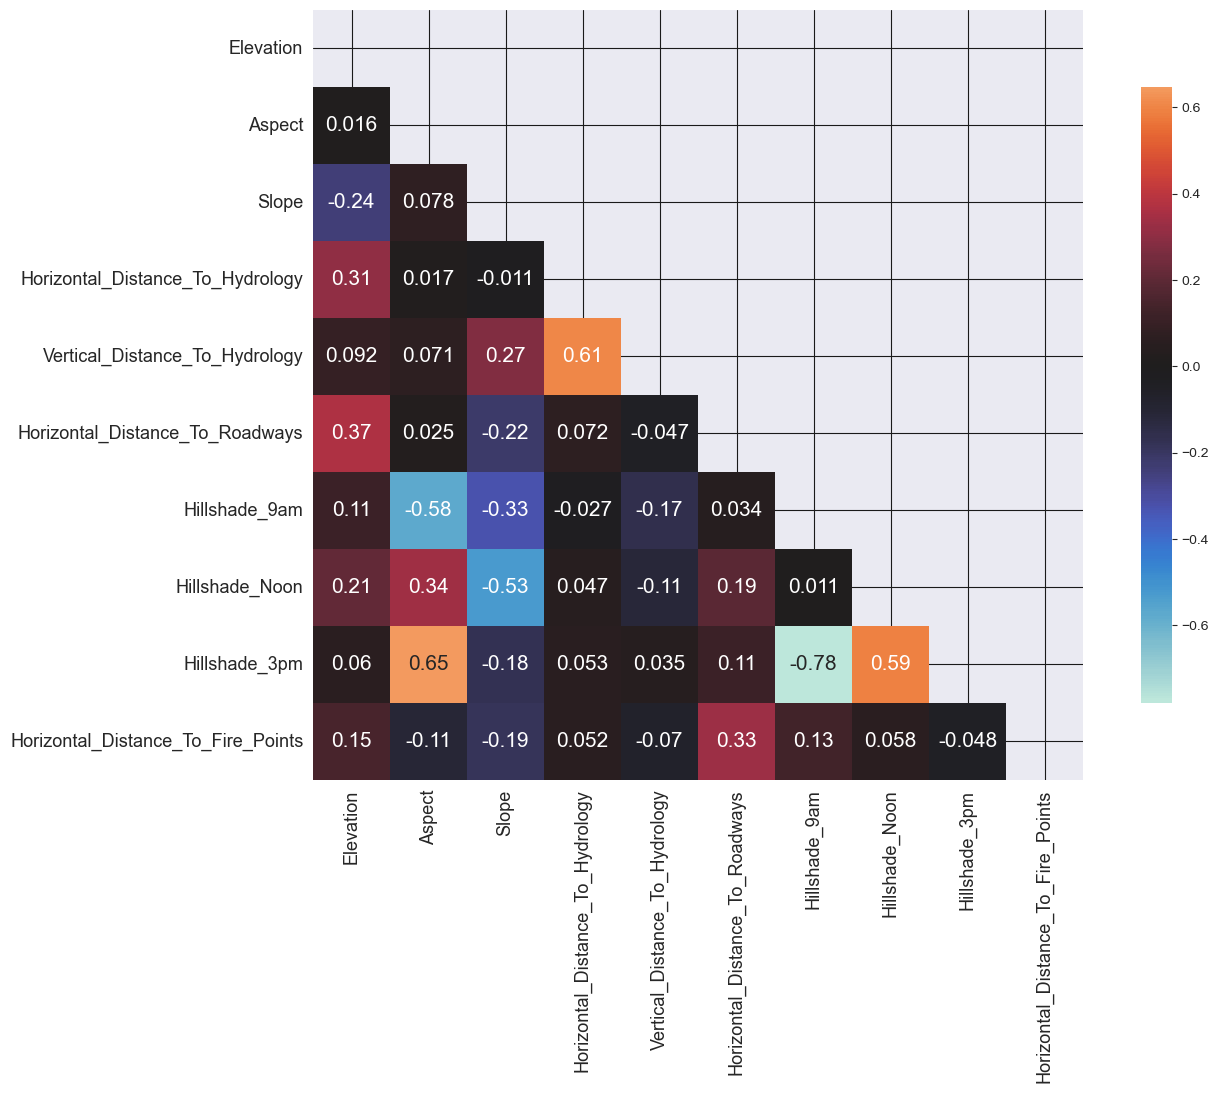

In [24]:
######    5    #######
# Correlation Plot
# Correlation of each feature

# fig size
plt.subplots(figsize=(15, 10))

# Compute the correlation matrix
num_fea_corr = num_fea.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(num_fea_corr, dtype=bool)  # Remplacer np.bool par bool
mask[np.triu_indices_from(mask)] = True

# Generates heatmap masking the upper triangle and shrinking the cbar
sns.heatmap(num_fea_corr, mask=mask, center=0, square=True, annot=True, annot_kws={"size": 15}, cbar_kws={"shrink": .8})

# x-axis label size
plt.xticks(size=13)
# y-axis label size
plt.yticks(size=13)

# display plot
plt.show()


- Features that have less or no correlation are colored `black` while features with positive correlation are colored `orange` and `blue` for negative correlation.

- As we can see from the above figure, correlation values of the features are given in their respective boxes. 

- `Hillshade_3pm and Hillshade_9am` show highly `negative correlation` while `hillshade_3pm and Aspect` show highest positive correlation.

- `Hillshade_3pm and Aspect` also had almost normal distribution compared to forest cover types classes. ([Plot 4.1](#Feature-Visualization))

- Other features which have correlations are `Vertical and Horizonal Distance to Hydrology`, `Hillshade_3m and Hillshade_Noon`, `Hillshade_9am and Aspect` and `Hillshade_Noon and Slope`. So in total we have `6` pairs of correlation.

- Less Correlated value tell us that the features have different valueable information to tell us and model, hence important features for predictions.

**Plotting scatter plots of all features that have correlation greater than 0.5 with each other.**

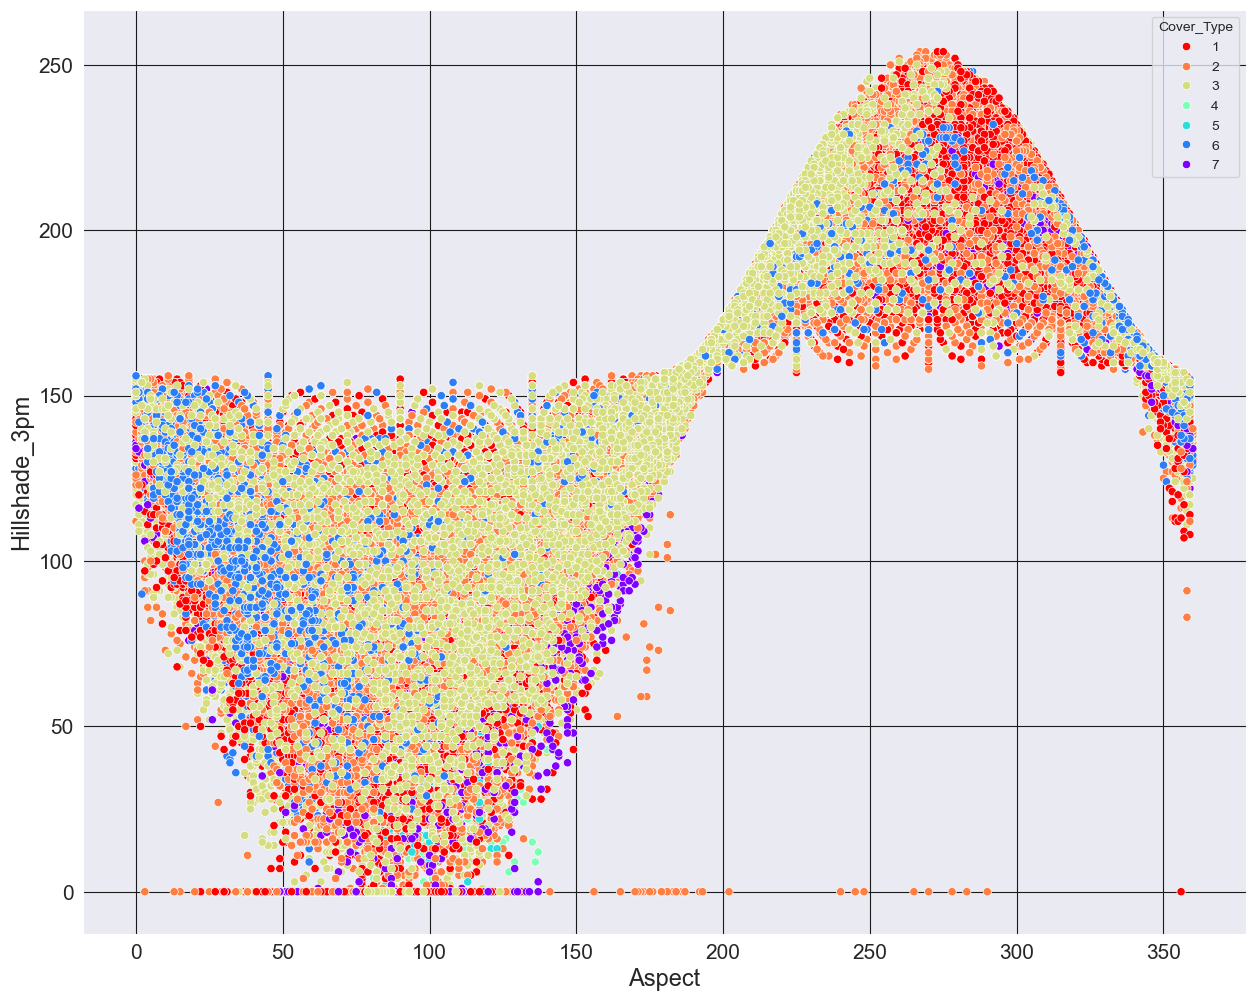

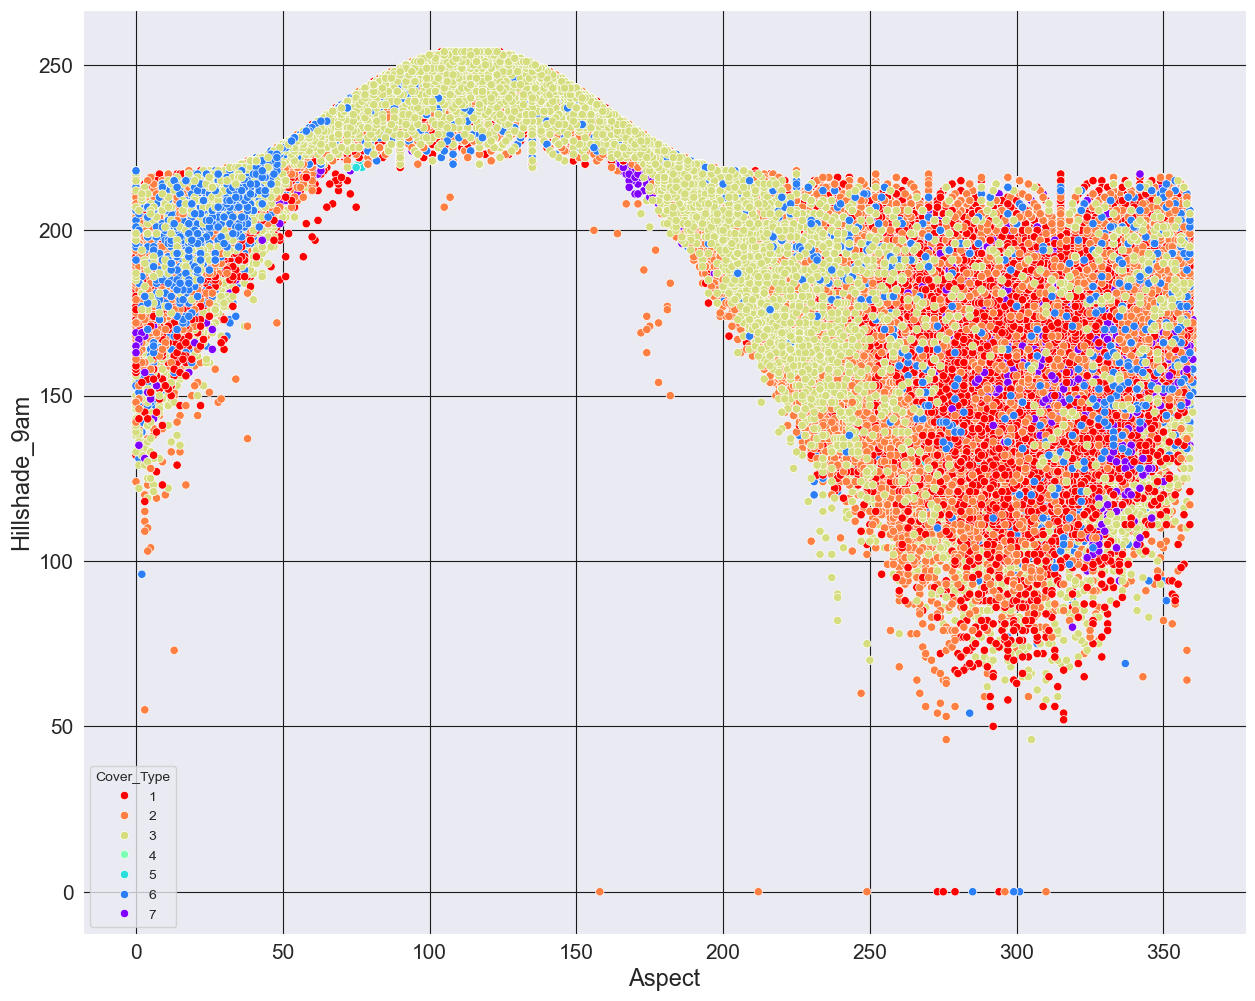

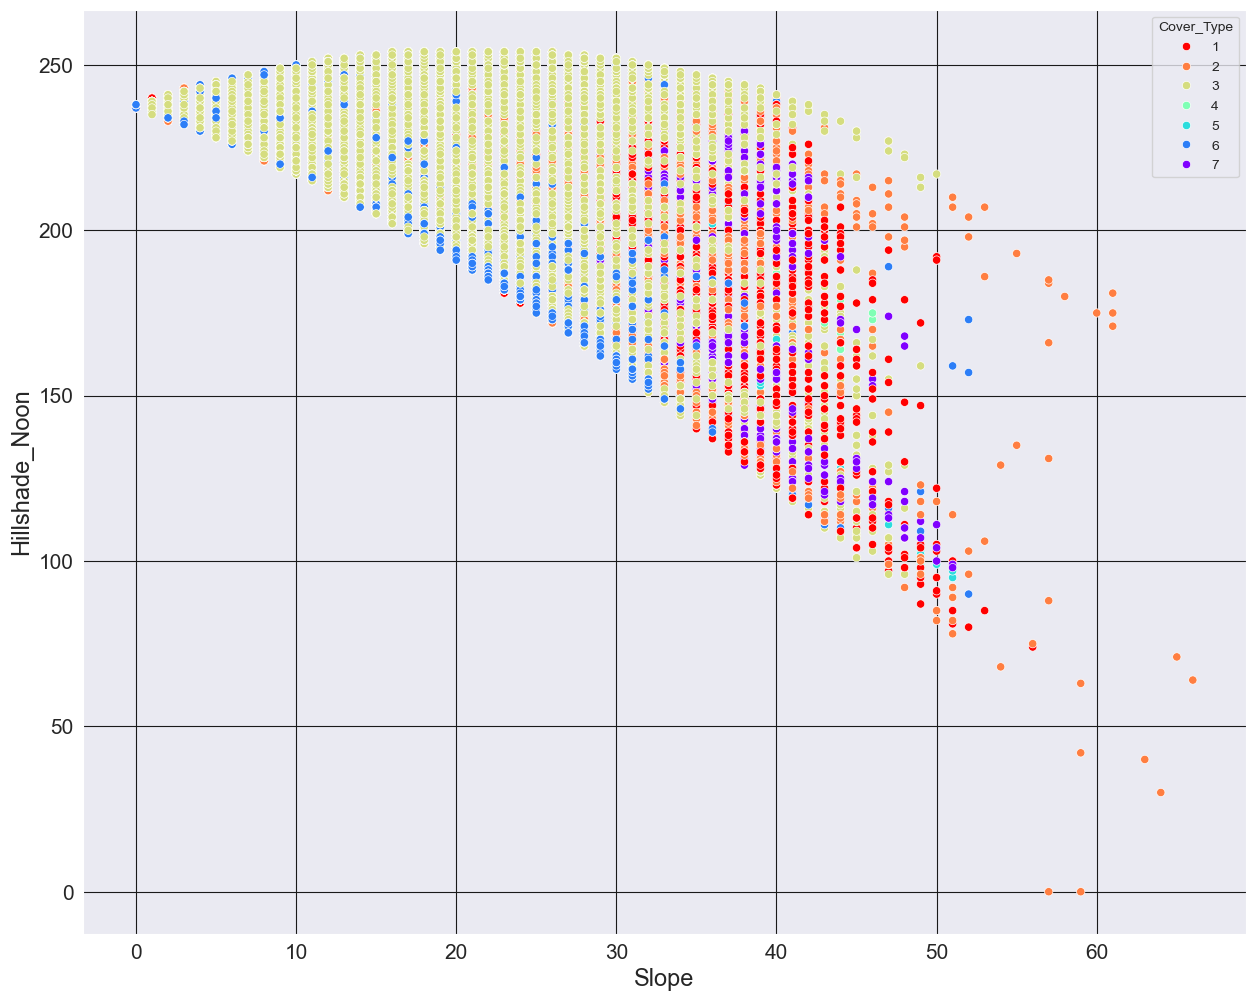

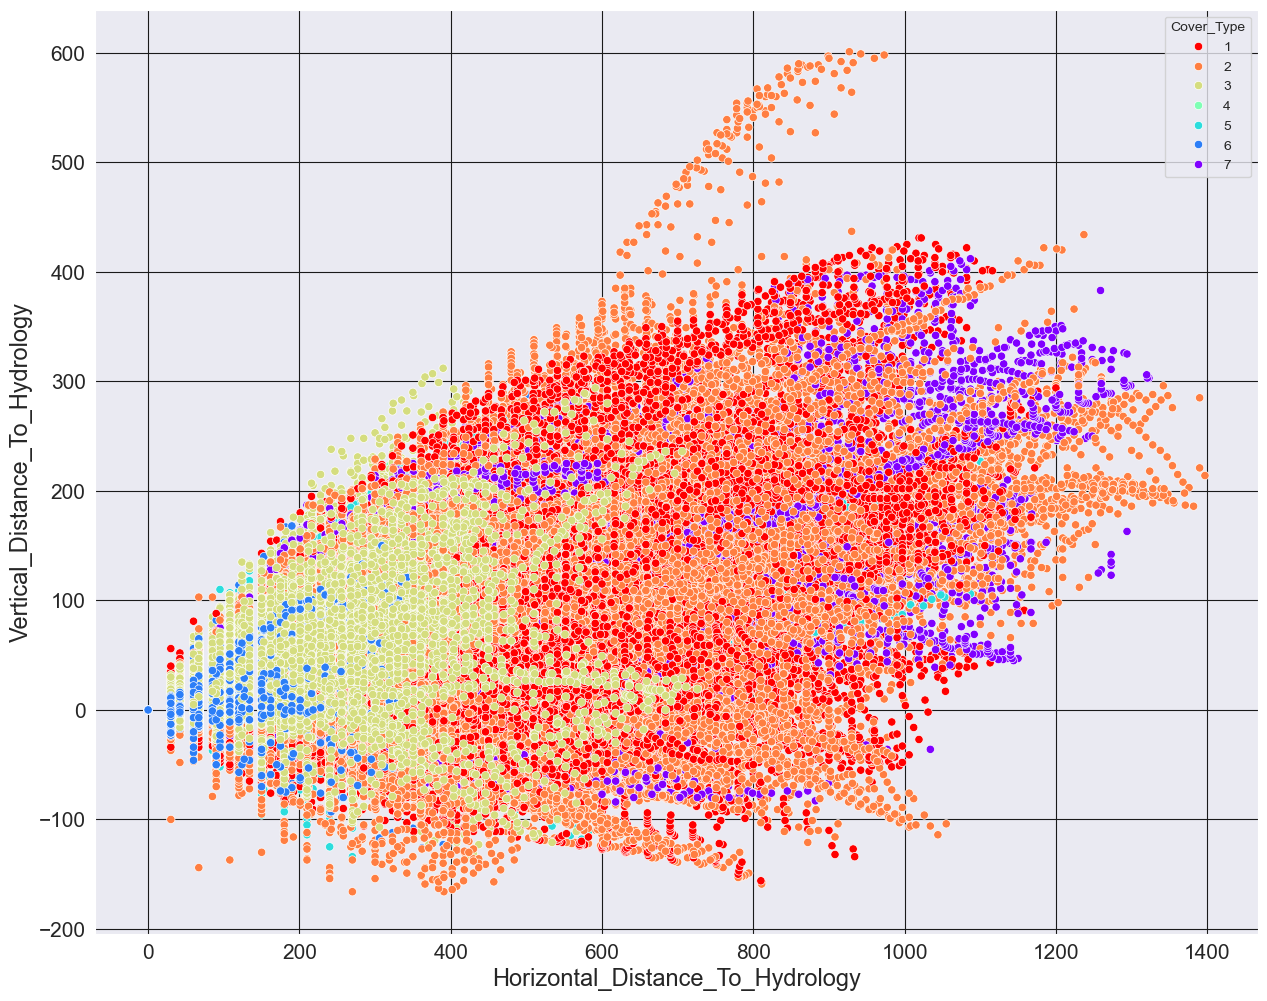

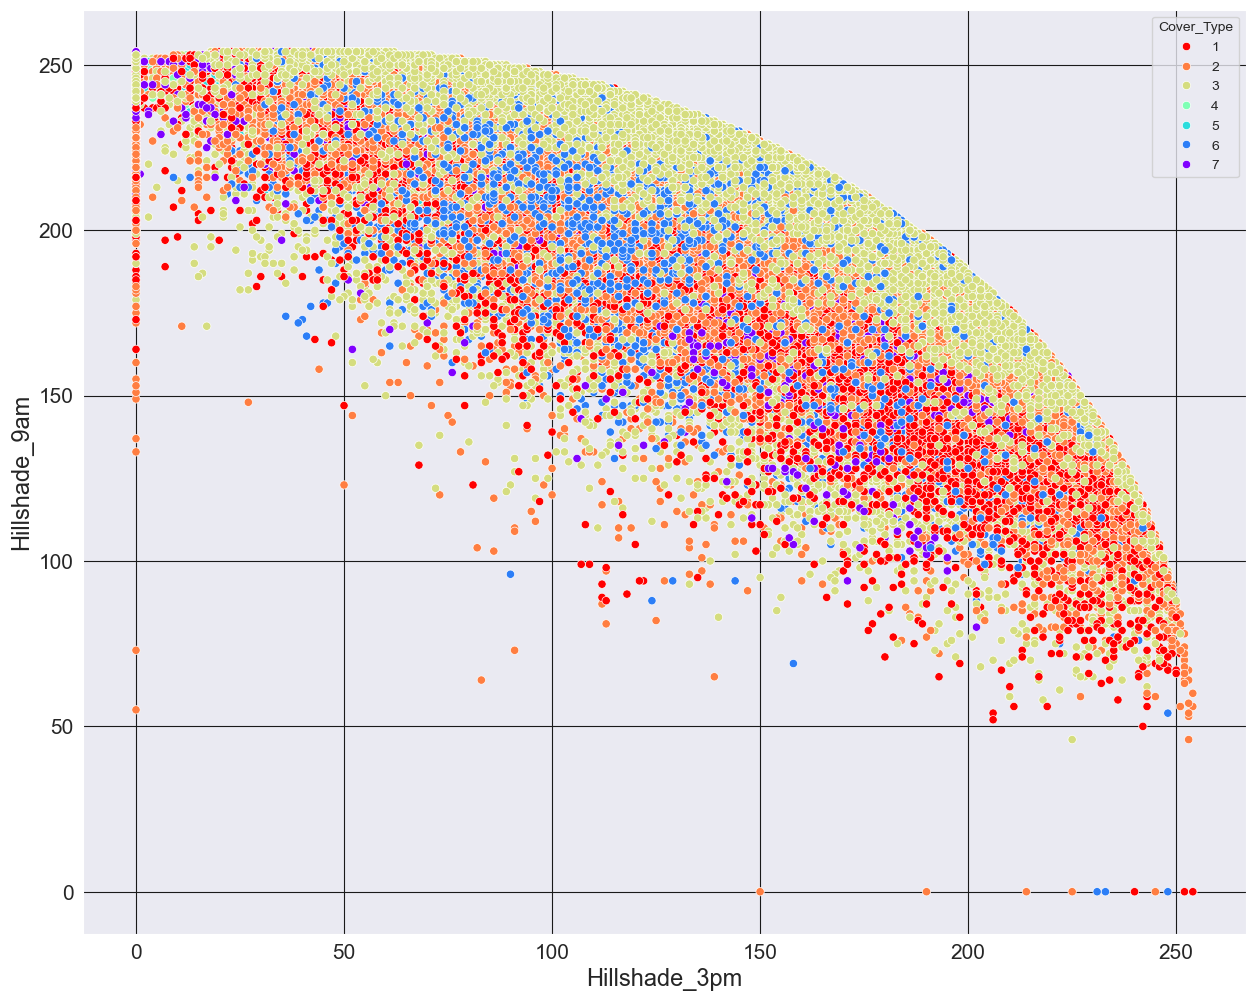

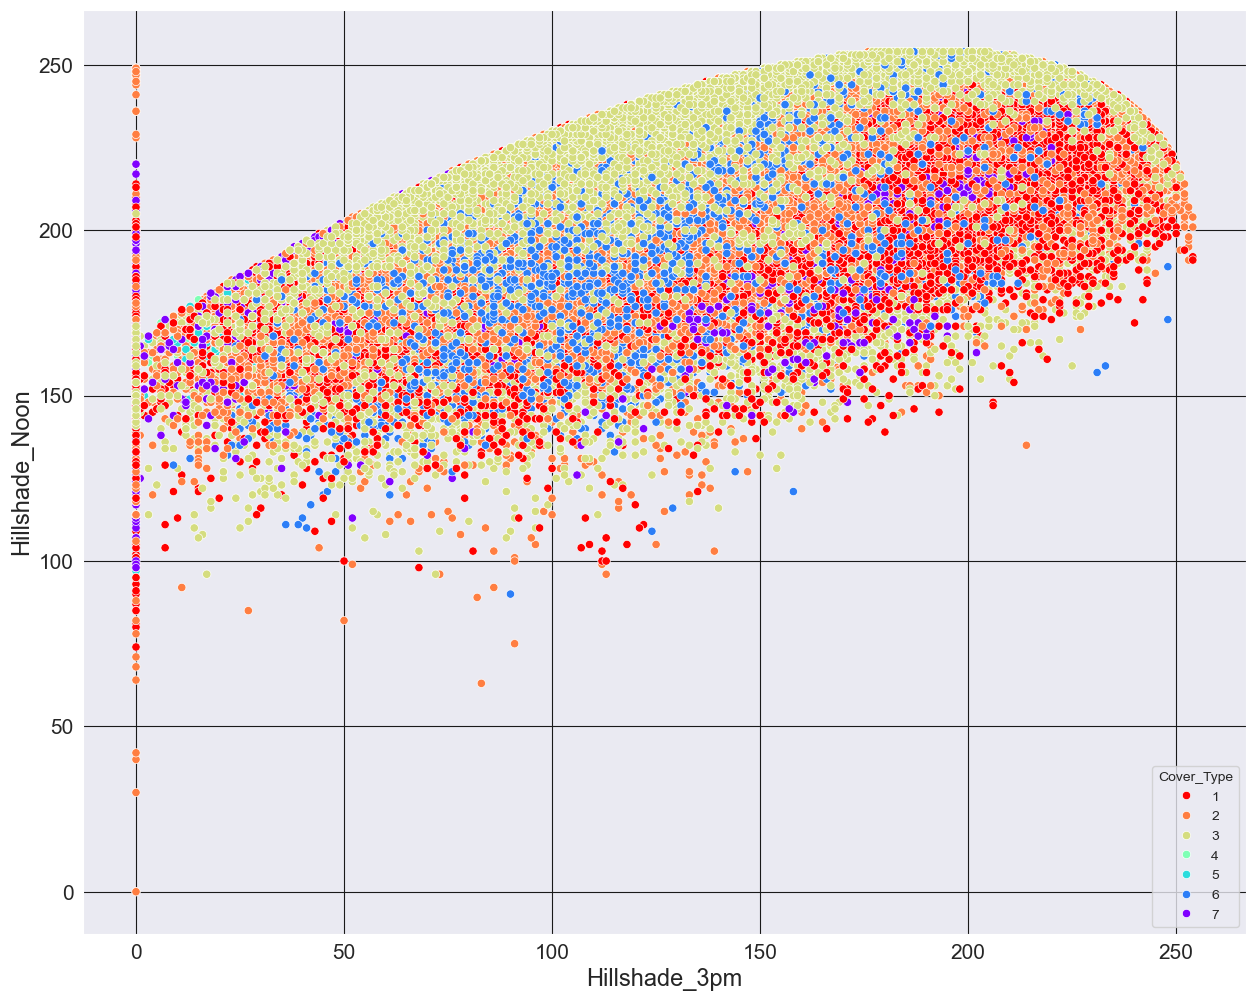

In [25]:
#####    6    #####
# Scatter Plots
# Correlation that have greater than 0.5

# plot bg
sns.set_style("darkgrid", {'grid.color': '.1'})

# giving list of lists
# inner lists conatains pairs of feature which have high correlation
list_data_cor = [['Aspect','Hillshade_3pm'], ['Aspect', 'Hillshade_9am'], ['Slope', 'Hillshade_Noon'], ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology'], 
                 ['Hillshade_3pm', 'Hillshade_9am'], ['Hillshade_3pm', 'Hillshade_Noon']]


# Looping through outer list
# taking 2 features from inner list
for i,j in list_data_cor:
    
    # fig size
    plt.subplots(figsize=(15, 12))
    
    #plot 1 feature on x axis and other on y axis, each point shows which cover forest they belong to
    sns.scatterplot(data = data, x = i, y = j, hue="Cover_Type", legend = 'full', palette='rainbow_r')

    # x-axis label size
    plt.xticks(size = 15)
    # y-axis label size
    plt.yticks(size = 15)

    # Horizontal axis Label
    plt.xlabel(i, size = 17)
    # Vertical axis Label
    plt.ylabel(j, size = 17)
  
    # display plot
    plt.show()

- `Hillshade_3pm and Aspect` represent relationship of a `sigmoid function`. The data points at the boundaries of the figure mostly belong to `forest cover type class 1` while `class 3` takes on most of datapoints in the figure followed by `forest cover type class 6`. The datapoints when `Hillshade_3pm` is `0` belongs to `class 1,2,3 or 7` regardless of what `Aspect` values it has.

- The figure `Hillshade_9am and Aspect` also represent relationship of a `sigmoid function` just its flipped over the y-axis. `Class type 3` has the highest observation here followed by the `class type 1 and 6`.

- `Hillshade_Noon and Slope` have a horizontal `'V' shaped` representation. Lower degrees represent `class 4 and 6` while high degree values represent `class 1, 2 and 7` also we can see decrease in `Hillshade_Noon` value as slope increases and it geographically makes sense.

- `Vertical and Horizontal Distance to Hydrology` represent a `linear` but spreaded out type, not a single line fit to all datapoints. `Class type 7 and 2` have more observation here and spreaded out while `class type 3 and 6` are densely packed between the range `0-800m` of `Horizontal Distance to Hydrology`.

- ` Hilshade_9am and Hillshade_3pm` figure represents relationship of a sliced-out part of a circle where top most of the datapoints belong to `class 3` and middle and bottom area belong to rest of the classes.

- `Hillshade_Noon and Hillshade_3pm` have similar observation as described before just a difference here is that it's flipped over y-aixs. We also see similar patterns of datapoints too as before.

**Now lets move on to the next part of the project, Data Engimeering** where we are going to :

- Delete columns which has `'0'` value for all observation.
- Delete observation which has null values in any of its features.
- Deleting duplicate entries but keeping first.
- Take a look at if any observations is present in more than one type in same category of Wilderness and Soil Type.
- Reducing features by keeping best.
- Scaling values in specific range.
- Peform Train-Test Split.

-------
-------

## Data Engineering

### Observation Cleaning

There's a possibility where we can have an observation where `Soil Type` and `Wilderness Area` are recorded as present for more than one type or maybe none.

Below code will show us if we have any..

**Checking for Wilderness Area.**

In [21]:
# Checking if any observation have more than 1 presence of Wilderness area at same time or None

# Count for more than 1 presence
more_count = 0
# Count for none presence
none_count = 0
# total count
total = 0

#looping through each row of wilderness area column
for index, row in Wild_data.iterrows():
    # adding the values of each column of that row
    total = row.sum(axis=0)
    
    #checking greater than 1
    if total > 1:
        # if found, increment count by 1
        more_count =+ 1
        # reset the total
        total = 0
        # do not execute code below, start from top
        break
        
    #checking for none   
    if total == 0:
        # if found, increment count by 1
        none_count =+ 1
        # reset the total
        total = 0      

# priting results found
print('We have ', more_count, ' observations that shows presence in more than 1 Wilderness Area.')
print('We have ' ,none_count, ' observations that shows no presence in any Wilderness Area.')

We have  0  observations that shows presence in more than 1 Wilderness Area.
We have  0  observations that shows no presence in any Wilderness Area.


**Checking for Soil Type.**

In [27]:
# Checking if any observation have more than 1 presence of Soil Type area at same time or None

# Count for more than 1 presence
more_count = 0
# Count for none presence
none_count = 0
# total count
total = 0

#looping through each row of Soil Type area column
for index, row in Soil_data.iterrows():
    # adding the values of each column of that row
    total = row.sum(axis=0)
    
    #checking greater than 1
    if total > 1:
        # if found, increment count by 1
        more_count =+ 1
        # reset the total
        total = 0
        # do not execute code below, start from top
        break
        
    #checking for none   
    if total == 0:
        # if found, increment count by 1
        none_count =+ 1
        # reset the total
        total = 0      

# priting results found
print('We have ', more_count, ' observations that shows presence in more than 1 Soil Type Area.')
print('We have ' ,none_count, ' observations that shows no presence in any Soil Type Area.')

We have  0  observations that shows presence in more than 1 Soil Type Area.
We have  0  observations that shows no presence in any Soil Type Area.


So we have none.

#### Handling Missing Values

**Removing Observation which has any Missing Values in it....**

In [22]:
# will delete observation if it has any missing values in any of the features.
data.dropna()

# shape of the data after deleting missing entries
data.shape

(464810, 55)

No missing values.

#### Handling Duplicates

In [23]:
# deleting duplicates, except the first observation
data.drop_duplicates(keep='first')

# shape of the data after deleting duplicate entries
data.shape

(464810, 55)

No duplicates too.

--------

### Dimentionality Reduction

- Since we already have lots of observation now to train the model, we also happen to have lots of features. This will make algorithm run very slowly, have difficulty in learning and also tend to overfit in training set and do worse in testing.

- We also see above in visualization section that `Wilderness Area` and `Soil Type` Area have no category that has no observations of it. So every feature has presence or values of an observations so we can't just delete any feature since it may have an important informations for our models in predicting classes.

- To approach such a problem, we need to see how each feature has an impact on prediciting classes, and the best way to do this is by asking the models only.

- Classifiers like `Extra Trees, Random Forest, Gradient Boosting Classifiers and AdaBoost` offer an attribute called `'feature_importance_'` with which we can see that which feature has more importance compared to others and by how much.

So now let's run all the 4 classifiers on our entire model, train from it and give us which feature for that was important in terms of predicting classes.

#### Random Forest Classifier

In [32]:
# importing model for feature importance
from sklearn.ensemble import RandomForestClassifier

# defining features and target variable
X = data.drop(columns=['Cover_Type'])
y = data['Cover_Type']

# passing the model
model = RandomForestClassifier(random_state = 53)

# training the model
model.fit(X, y)

# extracting feature importance from model and making a dataframe of it in descending order
RFC_feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['RFC']).sort_values('RFC', ascending=False)

# removing traces of this model
model = None

# show top 10 features
RFC_feature_importances.head(10)

RFC
Elevation                           0.239298
Horizontal_Distance_To_Roadways     0.118792
Horizontal_Distance_To_Fire_Points  0.110111
Horizontal_Distance_To_Hydrology    0.060215
Vertical_Distance_To_Hydrology      0.057650
Aspect                              0.048154
Hillshade_Noon                      0.042760
Hillshade_3pm                       0.041082
Hillshade_9am                       0.040812
Wilderness_Area4                    0.035885

#### GradientBoostingClassifier

In [33]:
# importing model for feature importance
from sklearn.ensemble import GradientBoostingClassifier

# passing the model
model = GradientBoostingClassifier(random_state = 53)

# training the model
model.fit(X, y)

# extracting feature importance from model and making a dataframe of it in descending order
GBC_feature_importances = pd.DataFrame(model.feature_importances_, index = X.columns, columns=['GBC']).sort_values('GBC', ascending=False)

# removing traces of this model
model = None

# show top 10 features
GBC_feature_importances.head(10)

GBC
Elevation                           0.646804
Horizontal_Distance_To_Roadways     0.055609
Horizontal_Distance_To_Fire_Points  0.042331
Horizontal_Distance_To_Hydrology    0.037868
Hillshade_Noon                      0.025767
Wilderness_Area1                    0.024793
Soil_Type4                          0.016629
Soil_Type22                         0.016585
Soil_Type2                          0.012891
Wilderness_Area3                    0.012592

- Each classifier provides its top feature choices, showing similar patterns overall.

- `RF` and `SGDC` have consistent top features, with minor differences in rank.

- `LR` also shows similar patterns but slightly different feature rankings compared to `RF` and `SGDC`.

- `Elevation` consistently appears as an important feature across all classifiers, contributing around `22-24%`.

- `Hillshade` features appear in the top 10 for `RF` and `SGDC` but not for `LR`.

- Features like `Elevation`, `Vertical and Horizontal Distance to Hydrology` are present in the top 10 for all classifiers, indicating their importance.

- Numerical features dominate when predicting forest classes.

- We will use the top `15-20` features that appear in most classifiers as a reasonable choice for further analysis.

Out of these top 24 features, I would take like to go with **Top 20**. Like this, we will have something really close to reality.

---
## MODELING
---

In [123]:
## feeding top 20 features in a variable as dataframe including target variable

## AdaBoost Sample
#sample = data[['Wilderness_Area4', 'Elevation','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Aspect','Wilderness_Area4', 'Soil_Type4', 'Soil_Type10' 'Cover_Type']]

sample = data[['Elevation','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology','Aspect','Wilderness_Area4',
            'Hillshade_Noon','Hillshade_3pm','Hillshade_9am','Slope','Soil_Type22','Soil_Type10','Soil_Type4','Soil_Type34','Soil_Type34','Wilderness_Area3','Soil_Type12',
            'Soil_Type2','Wilderness_Area1', 'Cover_Type']]

Finding Useful features and having reasonable dimentions we are ready to move on to our nest step of feature scaling.

---------

### Feature Scaling

One last step before we move to splitting our data to Train-Test Split is to scale the features to some specific range. This is called Feature Scaling. We will scale all feature values to specific range of `0 to 1`. but before we do this we will split the feature and target variables because we dont want to scale our target variable..

In [124]:
# importing feature scaling function
from sklearn.preprocessing import MinMaxScaler

# passing range to the function and then save it
scaler = MinMaxScaler(feature_range = (0,1))

# feeding sample features to var 'X'
X = sample.iloc[:,:-1]

# feeding our target variable to var 'y'
y = sample['Cover_Type']

# apply feature scaling to all features
X_scaled = scaler.fit_transform(X)

In [125]:
# our data after feature scaling
X_scaled

array([[0.36568284, 0.05479837, 0.86783772, ..., 0.        , 0.        ,
        1.        ],
       [0.46323162, 0.4341717 , 0.86588596, ..., 0.        , 0.        ,
        1.        ],
       [0.36818409, 0.05493888, 0.86044891, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.26613307, 0.01334832, 0.11780287, ..., 0.        , 1.        ,
        0.        ],
       [0.26363182, 0.01264578, 0.11905758, ..., 0.        , 1.        ,
        0.        ],
       [0.26263132, 0.01264578, 0.12045169, ..., 0.        , 1.        ,
        0.        ]])

-------

### Train-Test Split

Now our data is ready to be splitted into **75%-25% train-test set respectively**.

In [126]:
# importing train-test function
from sklearn.model_selection import train_test_split

# split the data in 75%-25% train-test respectively with fixed state
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 53)

In [127]:
# number of training observation
print(X_train.shape, X_test.shape)

(348607, 20) (116203, 20)


Lots of data to train and test on.

-------

-----------

## Model Evaluations


Now its time to feed our data to the models to see how each models performs using 2 different `evaluation metrics` **`accuracy`** and **`f1 score`** and see which model performs the best. 

But before that, we will train our data on training set and test the performance of the Benchmark model we discussed about in the start of the project. I will use 10 K-Fold CV to test the performance of our model. I had choosen Naive Bayes Classifier as my benchmark model and I am going to use **`Multimonial Naive Bayes classifier`** since we have a claasification problem to solve.

The `Evaluation Metric` I am going to use are `f1 score` and `accuracy` to see how well our model performs.

- `Accuracy` is the measure of the correct predicted data divided by total number of observations hence giving a value ranging between `0 and 1`, while `0` is no correctly predicted class whereas `1` is all correctly predicted class. We can multiply the result by `100` to get the accuracy score in terms of percent.

- `F1 score` is more useful than accuracy specially in the case where you have uneven amount of class distribution as in our case. It's the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 

-  `Accuracy` works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall or `F1 score`. 

First I will define a function which will train the `models` using training data and calculate model's performance using `accuracy` and `f1 score`. One sets of instruction for all `models`!

In [128]:
### defining function for training models and measuring performance 

# to measure performance
from sklearn.model_selection import cross_val_score

# for calculating time elapsed
import time

# fucntion
def model_evaluation(clf):
    
    # passing classifier to a variable
    clf = clf
    
    # records time
    t_start = time.time()
    # classifier learning the model
    clf = clf.fit(X_train, y_train)
    # records time
    t_end = time.time()
    
    
    # records time
    c_start = time.time()     
    # Using 10 K-Fold CV on data, gives peroformance measures
    accuracy  = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'accuracy')
    f1_score = cross_val_score(clf, X_train, y_train, cv = 10, scoring = 'f1_macro')
    # records the time
    c_end = time.time()    
    
    
    # calculating mean of all 10 observation's accuracy and f1, taking percent and rounding to two decimal places
    acc_mean = np.round(accuracy.mean() * 100, 2)
    f1_mean = np.round(f1_score.mean() * 100, 2)
    
    
    # substracts end time with start to give actual time taken in seconds
    # divides by 60 to convert in minutes and rounds the answer to three decimal places
    # time in training
    t_time = np.round((t_end - t_start) / 60, 3)
    # time for evaluating scores
    c_time = np.round((c_end - c_start) / 60, 3)
    
    
    # Removing traces of classifier
    clf = None
    
    
    # returns performance measure and time of the classifier 
    print("The accuracy score of this classifier on our training set is", acc_mean,"% and f1 score is", f1_mean,"% taking", t_time,"minutes to train and", c_time,
          "minutes to evaluate cross validation and metric scores.")

------

Let's measure performance with thoses models:
 
    1. Random Forest (RF)
    2. Stochastic Gradient Descent Classifier (SGDC)
    3. Logistic Regression (LR)

**we have evaluated below models without tuning any parameters and using just default set by sklearn except for `n_job`s and `random_state` where `n_jobs` is set to `-1` to use all cpu's and `random_state` is set to `53` for getting even results across runs. I have chosen default parameters just to see how each models perform on this data with its default parameters.

### 1. Random Forest Classifier

In [21]:
# importing Random Forest function
from sklearn.ensemble import RandomForestClassifier

model_evaluation(RandomForestClassifier(n_jobs=-1, random_state = 53))

The accuracy score of this classifier on our training set is 94.31 % and f1 score is 90.6 % taking 0.157 minutes to train and 2.762 minutes to evaluate cross validation and metric scores.


### 2. Stochastic Gradient Descent Classifier

In [42]:
# importing Stochastic Gradient Descent Classifier function
from sklearn.linear_model import SGDClassifier

model_evaluation(SGDClassifier(n_jobs=-1, random_state = 53))

The accuracy score of this classifier on our training set is 69.58 % and f1 score is 30.85 % taking 0.014 minutes to train and 0.243 minutes to evaluate cross validation and metric scores.


### 3. Logistic Regression


In [43]:
# importing Logistic Regression function    
from sklearn.linear_model import LogisticRegression

model_evaluation(LogisticRegression(n_jobs=-1, random_state=53))


The accuracy score of this classifier on our training set is 70.63 % and f1 score is 42.16 % taking 0.14 minutes to train and 2.352 minutes to evaluate cross validation and metric scores.


Here are all the values of all the parameters of the models used above that is given by default by sklearn.
    
**Parameters Values for RFC:**
    - n_estimators = 10, 
    - criterion = ’gini’, 
    - max_depth = None, 
    - min_samples_split = 2, 
    - min_samples_leaf = 1, 
    - min_weight_fraction_leaf = 0.0, 
    - max_features = ’auto’, 
    - max_leaf_nodes = None, 
    - min_impurity_decrease = 0.0, 
    - min_impurity_split = None, 
    - bootstrap = True, 
    - oob_score = False, 
    - n_jobs = -1, 
    - random_state = 53, 
    - verbose = 0, 
    - warm_start = False, 
    - class_weight = None

**Parameters Values for SGDC:**
    - loss = ’hinge’, 
    - penalty = ’l2’, 
    - alpha = 0.0001, 
    - l1_ratio = 0.15, 
    - fit_intercept = True, 
    - max_iter = None, 
    - tol = None, 
    - shuffle = True, 
    - verbose = 0, 
    - epsilon = 0.1, 
    - n_jobs = -1, 
    - random_state = 53, 
    - learning_rate = ’optimal’, 
    - eta0 = 0.0, 
    - power_t = 0.5, 
    - class_weight = None, 
    - warm_start = False, 
    - average = False, 
    - n_iter = None
    
**Parameters Values for LR:**    
    - penalty = ’l2’, 
    - dual = False, 
    - tol = 0.0001, 
    - C = 1.0, 
    - fit_intercept = True, 
    - intercept_scaling = 1, 
    - class_weight = None, 
    - random_state = 53, 
    - solver = ’liblinear’, 
    - max_iter = 100, 
    - multi_class = ’ovr’, 
    - verbose = 0, 
    - warm_start = False, 
    - n_jobs = 1

-------

### Choosing Model

Out of 5 Models evaluated above and benchmark model, which performs better? Lets see all the scores of all the models in a table below:

| Model | Accuracy | F1 Score | Train Time (m) | Evaluation Time (m) |
| ----- | -------- | -------- | ---------- | --------------- |
| **RF** | **94.31%** | **90.6%** | **0.939** | **15.49** |
| **SGDC** | 69.58% | 30.85% | 0.046 | 0.671 |
| **LR** | 70.63% | 42.1% | 0.255 | 4.183 |



-------
-------

## Testing Model

Since we had chosen default params above in `Random Forest` in training set, we will **tuning important parameters** that might give us more better results.

In [129]:
# defining best chosen classifier
clf = RandomForestClassifier(n_estimators=50, random_state=53)

# training our model
clf = clf.fit(X_train, y_train)

# predicting unseen data
predict = clf.predict(X_test)

# calculating accuracy
accuracy = accuracy_score(y_test, predict)

# calculating f1 score
f1_metric = f1_score(y_test, predict, average='macro')

# taking percentage and rounding to 3 places
accuracy = np.round(accuracy * 100, 3)
f1_metric = np.round(f1_metric * 100, 3)

# cleaning traces
clf = None

# results
print("The accuracy score of our final model Random Forest Classifier on our testing set is", accuracy, "% and F1 score is", f1_metric, "%.")


The accuracy score of our final model Random Forest Classifier on our testing set is 94.357 % and F1 score is 90.193 %.


---
## TRAINING MODEL WITH MLFLOW
---

In [141]:
import os, mlflow, pandas as pd, boto3, datetime, seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from mlflow.store.tracking.sqlalchemy_store import SqlAlchemyStore
from datetime import datetime

# Configuration initiale
load_dotenv('../.env')
load_dotenv('../.secrets')

tracking_uri = "postgresql+psycopg2://" + os.getenv("NEON_DATABASE_URL").replace("postgresql://", "")
store = SqlAlchemyStore(tracking_uri, "./mlruns") 

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("forest_cover_type")

# Test avec RandomForest
print("Démarrage du test MLflow...")

# Utiliser X_train, X_test, y_train, y_test existants
rf_model = RandomForestClassifier(n_estimators=10, random_state=53)

with mlflow.start_run(run_name=f"rf_test_{datetime.now().strftime('%Y%m%d_%H%M')}"):
    print("Entraînement du modèle...")
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_metric = f1_score(y_test, y_pred, average='macro')
    
    print(f"Métriques calculées - Accuracy: {acc:.4f}, F1: {f1_metric:.4f}")
    
    # log des paramètres et métriques
    mlflow.log_params(rf_model.get_params())
    mlflow.log_metrics({
        "accuracy": acc,
        "f1_score": f1_metric
    })
    
    # sauvegarde du modèle
    print("Sauvegarde du modèle...")
    mlflow.sklearn.log_model(rf_model, "random_forest_model")
    
    # création matrice de confusion
    print("Création des visualisations...")
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion - RandomForest')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

print("Test MLflow terminé!")

# vérif des runs
client = mlflow.tracking.MlflowClient()
runs = client.search_runs(experiment_ids=["3"])  # Utiliser votre experiment_id
if runs:
    last_run = runs[0]
    print("\nDernière exécution enregistrée :")
    print(f"Run ID : {last_run.info.run_id}")
    print(f"Métriques : {last_run.data.metrics}")

2025/01/06 19:44:21 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/01/06 19:44:21 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl PostgresqlImpl.
INFO  [alembic.runtime.migration] Will assume transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Démarrage du test MLflow...
Entraînement du modèle...
Métriques calculées - Accuracy: 0.9282, F1: 0.8775
Sauvegarde du modèle...


2025/01/06 19:44:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Création des visualisations...
Test MLflow terminé!


In [142]:
#sauvegarde de la matrice de confusion sur le S3 :

# Get parent directory (where .env and .secrets are located)
project_root = os.path.dirname(os.getcwd())

# Construct paths to config files
env_path = os.path.join(project_root, '.env')
secrets_path = os.path.join(project_root, '.secrets')

print(f"Loading .env from: {env_path}")
print(f"Loading .secrets from: {secrets_path}")

# Load environment variables
load_dotenv(env_path)
load_dotenv(secrets_path)

# Verify credentials
aws_access_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_bucket = os.getenv("S3_BUCKET")

# Upload matrice confusion vers S3
s3 = boto3.client('s3')
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
s3_path = f'covertype/mlflow_artifact/confusion_matrix_{timestamp}.png'

print("Upload de la matrice de confusion vers S3...")
try:
    s3.upload_file(
        'confusion_matrix.png', 
        os.getenv('S3_BUCKET'), 
        s3_path
    )
    print(f"Upload réussi: {s3_path}")
except Exception as e:
    print(f"Erreur lors de l'upload: {str(e)}")

Loading .env from: c:\IAI-B4-MLops_pipeline_CoverTypeForest\.env
Loading .secrets from: c:\IAI-B4-MLops_pipeline_CoverTypeForest\.secrets
Upload de la matrice de confusion vers S3...
Upload réussi: covertype/mlflow_artifact/confusion_matrix_20250106_1944.png


---
## WITH MLFLOW, PKL CREATION AND SAVE ON S3
---

In [ ]:

# Chargement des variables d'environnement
load_dotenv()
load_dotenv(".secrets")

# Configuration MLflow avec NeonDB
mlflow.set_tracking_uri(os.getenv("NEON_DATABASE_URL"))
mlflow.set_experiment("forest_cover_type")

# Création et entraînement du modèle
rf_model = RandomForestClassifier(n_estimators=10, random_state=53)
print("Entraînement du modèle...")
rf_model.fit(X_train, y_train)

# Prédictions et calcul des métriques
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

# Affichage des résultats
print(f"Accuracy: {accuracy * 100:.3f}%")
print(f"F1 Score: {f1 * 100:.3f}%")

# Sauvegarde du modèle en local avec pickle
print("Sauvegarde du modèle en local...")
filename = 'forest_cover_type_model.pkl'
with open(filename, 'wb') as f:
    pickle.dump(rf_model, f)

# Logging avec MLflow
with mlflow.start_run(run_name=f"rf_model_{datetime.now().strftime('%Y%m%d_%H%M')}"):
    # Log des paramètres et métriques
    mlflow.log_params(rf_model.get_params())
    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1
    })

    # Sauvegarde du modèle dans MLflow
    mlflow.sklearn.log_model(rf_model, "random_forest_model")

    # Création et sauvegarde de la matrice de confusion
    print("Création de la matrice de confusion...")
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matrice de confusion - RandomForest')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.close()

# Vérification que le modèle a été correctement sauvegardé
print("Vérification de la sauvegarde en local...")
try:
    with open(filename, 'rb') as f:
        loaded_model = pickle.load(f)
    print("✓ Le modèle a été correctement sauvegardé")
    print(f"✓ Type du modèle : {type(loaded_model)}")
except Exception as e:
    print("✗ Erreur lors de la vérification de la sauvegarde :", str(e))

# Vérification des runs MLflow
client = mlflow.tracking.MlflowClient()
runs = client.search_runs(experiment_ids=["3"])
if runs:
    last_run = runs[0]
    print("\nDernière exécution enregistrée :")
    print(f"Run ID : {last_run.info.run_id}")
    print(f"Métriques : {last_run.data.metrics}")

print("Entraînement et suivi terminés!")


---
### pkl saving on S3
---

In [41]:

# Get parent directory (where .env and .secrets are located)
project_root = os.path.dirname(os.getcwd())

# Construct paths to config files
env_path = os.path.join(project_root, '.env')
secrets_path = os.path.join(project_root, '.secrets')

print(f"Loading .env from: {env_path}")
print(f"Loading .secrets from: {secrets_path}")

# Load environment variables
load_dotenv(env_path)
load_dotenv(secrets_path)

# Verify credentials
aws_access_key = os.getenv("AWS_ACCESS_KEY_ID")
aws_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY")

if not aws_access_key or not aws_secret_key:
    print("Erreur: AWS credentials non trouvés")
    print(f"AWS_ACCESS_KEY_ID: {'Défini' if aws_access_key else 'Non défini'}")
    print(f"AWS_SECRET_ACCESS_KEY: {'Défini' if aws_secret_key else 'Non défini'}")
else:
    print("AWS credentials chargés avec succès")

#uploading model to S3
def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3', 
                      aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
                      aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"))
    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload réussi")
        return True
    except FileNotFoundError:
        print("Le fichier n'a pas été trouvé")
        return False
    except NoCredentialsError:
        print("Les informations d'identification d'AWS n'ont pas été trouvées")
        return False
    
# Get bucket name from .env
bucket_name = os.getenv("S3_BUCKET")

# Define S3 path
s3_path = 'covertype/models/forest_cover_type_model.pkl'

# Upload model to S3
upload_to_aws(filename, bucket_name, s3_path)


Loading .env from: c:\IAI-B4-MLops_pipeline_CoverTypeForest\.env
Loading .secrets from: c:\IAI-B4-MLops_pipeline_CoverTypeForest\.secrets
AWS credentials chargés avec succès
Upload réussi


True